## Progeny pathway analysis for Stroma cells

In [1]:
import os
import sys
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import hdf5plugin

# Add repo path to sys path (allows to access scripts and metadata from repo)
repo_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/TEC_compartment'
sys.path.insert(1, repo_path) 
sys.path.insert(2, '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts')


In [2]:
import decoupler as dc

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

In [4]:
# Define plot and path dirs
plot_path = os.path.join(repo_path, 'plots')
data_path = os.path.join(repo_path, 'data')
model_path = os.path.join(repo_path, 'models')
# Define plot and path dirs
results_path = os.path.join(repo_path, 'results')
general_data_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/data'

In [5]:
# Formatting
from matplotlib import font_manager
font_manager.fontManager.addfont("/nfs/team205/ny1/ThymusSpatialAtlas/software/Arial.ttf")
#plt.style.use('/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')


In [6]:
# Import custom scripts
from utils import get_latest_version,update_obs,freq_by_donor
from anno_levels import get_ct_levels, get_ct_palette, age_group_levels, age_group_palette
from plotting.utils import plot_grouped_boxplot, calc_figsize

In [7]:
plt.style.use('/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')

## Load adata

In [8]:
# Load adata
object_version = 'v5_2025-04-03'
adata = ad.read_h5ad(f'{general_data_path}/objects/rna/thyAgeing_all_scvi_{object_version}.zarr')
# Add final annotations to adata and remove non-annotated cells
ct_anno = pd.read_csv(f'{general_data_path}/objects/rna/thyAgeing_all_scvi_v5_2025-10-15_curatedAnno_v11.csv', index_col = 0)

for c in ct_anno.columns:
    if c in adata.obs.columns:
        adata.obs.drop(c, axis = 1, inplace = True)
adata.obs = adata.obs.join(ct_anno)

adata = adata[~adata.obs['taa_l5'].isnull(),].copy()
# Update metadata
latest_meta_path = get_latest_version(dir = f'{general_data_path}/metadata', file_prefix='Thymus_ageing_metadata')
latest_meta = pd.read_excel(latest_meta_path)

update_obs(adata, latest_meta, on = 'index')


Latest file: Thymus_ageing_metadata_v28_2025-03-13.xlsx
No columns specified to update. Automatically determining columns to update...
Updating columns: ['age', 'age_cont', 'age_group', 'age_group2', 'age_months', 'age_num', 'age_unit', 'chemistry_detail', 'chemistry_orig', 'chemistry_simple', 'cite', 'comment', 'donor', 'health_status', 'in_HTSA', 'library', 'library_bcr', 'library_tcr_ab', 'library_tcr_gd', 'origin_institute', 'path_bcr', 'path_cellbender_gex', 'path_cellranger_arc', 'path_raw_gex', 'path_tcr_ab', 'path_tcr_gd', 'public_data', 'research_no', 'sample', 'sex', 'sort', 'sort_type', 'starsolo_version', 'study', 'type']
On columns: index


## Load progeny pathways

In [9]:
progeny = dc.op.progeny(organism="human")
progeny

source   target     weight          padj
0      Androgen  TMPRSS2  11.490631  2.384806e-47
1      Androgen   NKX3-1  10.622551  2.205102e-44
2      Androgen   MBOAT2  10.472733  4.632376e-44
3      Androgen     KLK2  10.176186  1.944410e-40
4      Androgen     SARG  11.386852  2.790210e-40
...         ...      ...        ...           ...
62416       p53    ENPP2   2.771405  4.993215e-02
62417       p53   ARRDC4   3.494328  4.996747e-02
62418       p53    MYO1B  -1.148057  4.997905e-02
62419       p53     CTSC  -1.784693  4.998864e-02
62420       p53    NAA50  -1.435013  4.998884e-02

[62421 rows x 4 columns]

In [10]:
progeny['source'].unique()

array(['Androgen', 'EGFR', 'Estrogen', 'Hypoxia', 'JAK-STAT', 'MAPK',
       'NFkB', 'PI3K', 'TGFb', 'TNFa', 'Trail', 'VEGF', 'WNT', 'p53'],
      dtype=object)

In [11]:
progeny['source'].value_counts()

source
MAPK        9518
NFkB        8158
EGFR        7045
PI3K        6771
Hypoxia     6602
TNFa        5629
p53         5367
VEGF        4502
Estrogen    2620
Androgen    2059
JAK-STAT    1870
TGFb        1805
WNT          273
Trail        202
Name: count, dtype: int64

In [12]:
stroma_lev3 = get_ct_levels(level='taa_l3', taa_l1=['TEC','Fb','EC','Mural'])

Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx


In [13]:
tec_lev3 = get_ct_levels(level='taa_l3', taa_l1=['TEC'])

Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx


In [14]:
adata_stroma = adata[adata.obs['taa_l1'].isin(['TEC','Fb','EC','Mural']),].copy()

In [15]:
sc.pp.normalize_total(adata_stroma, target_sum=1e4)
sc.pp.log1p(adata_stroma)

In [16]:
del adata
import gc

In [17]:
gc.collect()

4755

In [18]:
%%time
dc.mt.ulm(data=adata_stroma, net=progeny, bsize = 100000)

CPU times: user 1min 36s, sys: 14min 16s, total: 15min 53s
Wall time: 15min 40s


In [19]:
score_stroma = dc.pp.get_obsm(adata=adata_stroma, key="score_ulm")

2025-11-17 12:42:43 | [INFO] maxp pruned
2025-11-17 12:42:43 | [INFO] LTSH dropped
2025-11-17 12:42:43 | [INFO] cmap pruned
2025-11-17 12:42:43 | [INFO] kern pruned
2025-11-17 12:42:43 | [INFO] post pruned
2025-11-17 12:42:43 | [INFO] PCLT dropped
2025-11-17 12:42:43 | [INFO] JSTF dropped
2025-11-17 12:42:43 | [INFO] DSIG dropped
2025-11-17 12:42:43 | [INFO] GSUB pruned
2025-11-17 12:42:43 | [INFO] glyf pruned
2025-11-17 12:42:43 | [INFO] Added gid0 to subset
2025-11-17 12:42:43 | [INFO] Added first four glyphs to subset
2025-11-17 12:42:43 | [INFO] Closing glyph list over 'GSUB': 50 glyphs before
2025-11-17 12:42:43 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'M', 'N', 'P', 'R', 'S', 'T', 'V', 'W', 'Z', 'a', 'b', 'c', 'd', 'e', 'five', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'underscore', 'v', 'x', 'y', 'zero']
2025-11-17 12:42:43 | [INFO] Glyph IDs:   [

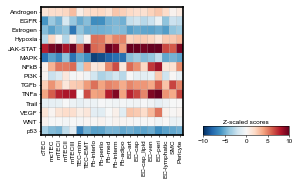

In [73]:
path_stroma_infant = sc.pl.matrixplot(
    adata=score_stroma[(score_stroma.obs['age_group'] == 'infant')],
    var_names=score_stroma.var_names,
    groupby="taa_l3",
    categories_order = stroma_lev3,
    dendrogram=False,
    colorbar_title="Z-scaled scores", figsize = (4.0, 2.0),
    cmap="RdBu_r", vcenter = 0, vmin = -10, vmax = 10,swap_axes = True, return_fig = True).savefig(f'{plot_path}/ThyAge_progeny_Stroma_infant.pdf')

2025-11-17 12:43:19 | [INFO] maxp pruned
2025-11-17 12:43:19 | [INFO] LTSH dropped
2025-11-17 12:43:19 | [INFO] cmap pruned
2025-11-17 12:43:19 | [INFO] kern pruned
2025-11-17 12:43:19 | [INFO] post pruned
2025-11-17 12:43:19 | [INFO] PCLT dropped
2025-11-17 12:43:19 | [INFO] JSTF dropped
2025-11-17 12:43:19 | [INFO] DSIG dropped
2025-11-17 12:43:19 | [INFO] GSUB pruned
2025-11-17 12:43:19 | [INFO] glyf pruned
2025-11-17 12:43:19 | [INFO] Added gid0 to subset
2025-11-17 12:43:19 | [INFO] Added first four glyphs to subset
2025-11-17 12:43:19 | [INFO] Closing glyph list over 'GSUB': 50 glyphs before
2025-11-17 12:43:19 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'M', 'N', 'P', 'R', 'S', 'T', 'V', 'W', 'Z', 'a', 'b', 'c', 'd', 'e', 'five', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'underscore', 'v', 'x', 'y', 'zero']
2025-11-17 12:43:19 | [INFO] Glyph IDs:   [

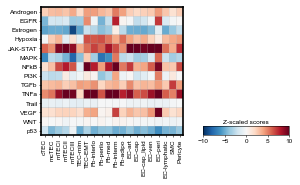

In [74]:
path_stroma_adult= sc.pl.matrixplot(
    adata=score_stroma[(score_stroma.obs['age_group'] == 'adult')],
    var_names=score_stroma.var_names,
    groupby="taa_l3",
    categories_order = stroma_lev3,
    dendrogram=False,
    colorbar_title="Z-scaled scores", figsize = (4.0, 2.0),
    cmap="RdBu_r", vcenter = 0, vmin = -10, vmax = 10,swap_axes = True, return_fig = True).savefig(f'{plot_path}/ThyAge_progeny_Stroma_adult.pdf')

2025-11-17 12:43:49 | [INFO] maxp pruned
2025-11-17 12:43:49 | [INFO] LTSH dropped
2025-11-17 12:43:49 | [INFO] cmap pruned
2025-11-17 12:43:49 | [INFO] kern pruned
2025-11-17 12:43:49 | [INFO] post pruned
2025-11-17 12:43:49 | [INFO] PCLT dropped
2025-11-17 12:43:49 | [INFO] JSTF dropped
2025-11-17 12:43:49 | [INFO] DSIG dropped
2025-11-17 12:43:49 | [INFO] GSUB pruned
2025-11-17 12:43:49 | [INFO] glyf pruned
2025-11-17 12:43:49 | [INFO] Added gid0 to subset
2025-11-17 12:43:49 | [INFO] Added first four glyphs to subset
2025-11-17 12:43:49 | [INFO] Closing glyph list over 'GSUB': 50 glyphs before
2025-11-17 12:43:49 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'M', 'N', 'P', 'R', 'S', 'T', 'V', 'W', 'Z', 'a', 'b', 'c', 'd', 'e', 'five', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'underscore', 'v', 'x', 'y', 'zero']
2025-11-17 12:43:49 | [INFO] Glyph IDs:   [

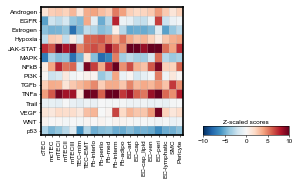

In [75]:
path_stroma_all = sc.pl.matrixplot(
    adata=score_stroma,
    var_names=score_stroma.var_names,
    groupby="taa_l3",
    categories_order = stroma_lev3,
    dendrogram=False,
    colorbar_title="Z-scaled scores", figsize = (4.0, 2.0),
    cmap="RdBu_r", vcenter = 0, vmin = -10, vmax = 10,swap_axes = True, return_fig = True).savefig(f'{plot_path}/ThyAge_progeny_Stroma_all.pdf')

In [79]:
score_stroma.obs

barcode                    sample  \
TA13072046-ACACCCTTCAGCACAT  ACACCCTTCAGCACAT  A67-THY-0-SC-FACS-3_5GEX   
TA13072046-GCATGTACATGTAGTC  GCATGTACATGTAGTC  A67-THY-0-SC-FACS-3_5GEX   
TA13072046-CCGGTAGTCAGCTTAG  CCGGTAGTCAGCTTAG  A67-THY-0-SC-FACS-3_5GEX   
TA13072046-GGCCGATCAGTCGTGC  GGCCGATCAGTCGTGC  A67-THY-0-SC-FACS-3_5GEX   
TA13072046-CGATCGGGTACGCTGC  CGATCGGGTACGCTGC  A67-THY-0-SC-FACS-3_5GEX   
...                                       ...                       ...   
TEC_96-ATACCTTCATCGATAC      ATACCTTCATCGATAC                    TEC_96   
TEC_96-TTACGTTCAGTGTGCC      TTACGTTCAGTGTGCC                    TEC_96   
TEC_96-AACAAAGCATCGCTCT      AACAAAGCATCGCTCT                    TEC_96   
TEC_96-GCCGTGACAGAGAAAG      GCCGTGACAGAGAAAG                    TEC_96   
TEC_96-CGTTGGGTCGTTCTGC      CGTTGGGTCGTTCTGC                    TEC_96   

                                library       index library_tcr_ab  \
TA13072046-ACACCCTTCAGCACAT  TA13072046  TA13072046            NaN   
TA13072046-GCATGTACATGTAGTC  TA13072046  TA13072046            NaN   
TA13072046-CCGGTAGTCAGCTTAG  TA13072046  TA13072046            NaN   
TA13072046-GGCCGATCAGTCGTGC  TA13072046  TA13072046            NaN   
TA13072046-CGATCGGGTACGCTGC  TA13072046  TA13072046            NaN   
...                                 ...         ...            ...   
TEC_96-ATACCTTCATCGATAC       TEC_95_96      TEC_96            NaN   
TEC_96-TTACGTTCAGTGTGCC       TEC_95_96      TEC_96            NaN   
TEC_96-AACAAAGCATCGCTCT       TEC_95_96      TEC_96            NaN   
TEC_96-GCCGTGACAGAGAAAG       TEC_95_96      TEC_96            NaN   
TEC_96-CGTTGGGTCGTTCTGC       TEC_95_96      TEC_96            NaN   

                            library_tcr_gd library_bcr  \
TA13072046-ACACCCTTCAGCACAT            NaN         NaN   
TA13072046-GCATGTACATGTAGTC            NaN         NaN   
TA13072046-CCGGTAGTCAGCTTAG            NaN         NaN   
TA13072046-GGCCGATCAGTCGTGC            NaN         NaN   
TA13072046-CGATCGGGTACGCTGC            NaN         NaN   
...                                    ...         ...   
TEC_96-ATACCTTCATCGATAC                NaN         NaN   
TEC_96-TTACGTTCAGTGTGCC                NaN         NaN   
TEC_96-AACAAAGCATCGCTCT                NaN         NaN   
TEC_96-GCCGTGACAGAGAAAG                NaN         NaN   
TEC_96-CGTTGGGTCGTTCTGC                NaN         NaN   

                                                                  path_raw_gex  \
TA13072046-ACACCCTTCAGCACAT  /lustre/scratch126/cellgen/team205/vk8/irods_d...   
TA13072046-GCATGTACATGTAGTC  /lustre/scratch126/cellgen/team205/vk8/irods_d...   
TA13072046-CCGGTAGTCAGCTTAG  /lustre/scratch126/cellgen/team205/vk8/irods_d...   
TA13072046-GGCCGATCAGTCGTGC  /lustre/scratch126/cellgen/team205/vk8/irods_d...   
TA13072046-CGATCGGGTACGCTGC  /lustre/scratch126/cellgen/team205/vk8/irods_d...   
...                                                                        ...   
TEC_96-ATACCTTCATCGATAC      /lustre/scratch126/cellgen/team205/lm25/raw_da...   
TEC_96-TTACGTTCAGTGTGCC      /lustre/scratch126/cellgen/team205/lm25/raw_da...   
TEC_96-AACAAAGCATCGCTCT      /lustre/scratch126/cellgen/team205/lm25/raw_da...   
TEC_96-GCCGTGACAGAGAAAG      /lustre/scratch126/cellgen/team205/lm25/raw_da...   
TEC_96-CGTTGGGTCGTTCTGC      /lustre/scratch126/cellgen/team205/lm25/raw_da...   

                            starsolo_version  \
TA13072046-ACACCCTTCAGCACAT           2.7.4a   
TA13072046-GCATGTACATGTAGTC           2.7.4a   
TA13072046-CCGGTAGTCAGCTTAG           2.7.4a   
TA13072046-GGCCGATCAGTCGTGC           2.7.4a   
TA13072046-CGATCGGGTACGCTGC           2.7.4a   
...                                      ...   
TEC_96-ATACCTTCATCGATAC                  NaN   
TEC_96-TTACGTTCAGTGTGCC                  NaN   
TEC_96-AACAAAGCATCGCTCT                  NaN   
TEC_96-GCCGTGACAGAGAAAG                  NaN   
TEC_96-CGTTGGGTCGTTCTGC                  NaN   

                                     

2025-11-17 13:45:28 | [INFO] maxp pruned
2025-11-17 13:45:28 | [INFO] LTSH dropped
2025-11-17 13:45:28 | [INFO] cmap pruned
2025-11-17 13:45:28 | [INFO] kern pruned
2025-11-17 13:45:28 | [INFO] post pruned
2025-11-17 13:45:28 | [INFO] PCLT dropped
2025-11-17 13:45:28 | [INFO] JSTF dropped
2025-11-17 13:45:28 | [INFO] DSIG dropped
2025-11-17 13:45:28 | [INFO] GSUB pruned
2025-11-17 13:45:28 | [INFO] glyf pruned
2025-11-17 13:45:28 | [INFO] Added gid0 to subset
2025-11-17 13:45:28 | [INFO] Added first four glyphs to subset
2025-11-17 13:45:28 | [INFO] Closing glyph list over 'GSUB': 47 glyphs before
2025-11-17 13:45:28 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'M', 'N', 'P', 'R', 'S', 'T', 'V', 'W', 'Z', 'a', 'b', 'c', 'd', 'e', 'five', 'g', 'hyphen', 'i', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'x', 'y', 'zero']
2025-11-17 13:45:28 | [INFO] Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 

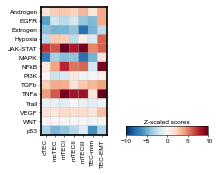

In [84]:
path_stroma_all = sc.pl.matrixplot(
    adata=score_stroma[score_stroma.obs['taa_l3'].isin(tec_lev3),],
    var_names=score_stroma.var_names,
    groupby="taa_l3",
    categories_order = tec_lev3,
    dendrogram=False,
    colorbar_title="Z-scaled scores", figsize = (2.7, 2.0),
    cmap="RdBu_r", vcenter = 0, vmin = -10, vmax = 10,swap_axes = True, return_fig = True).savefig(f'{plot_path}/ThyAge_progeny_TEC_all.pdf')

### Quantify change in the pathways

In [22]:
progeny_stroma_df = adata_stroma.obs.merge(adata_stroma.obsm['score_ulm'], how = 'left', left_index = True, right_index = True)

In [40]:
results_path

'/nfs/team205/vk8/projects/thymus_ageing_atlas/TEC_compartment/results'

In [41]:
progeny_stroma_df.to_csv(f'{results_path}/Progeny_Stroma_path_activity_{today}.csv', index=True)

In [23]:
progeny_paths = adata_stroma.obsm['score_ulm'].columns.tolist()

In [24]:
progeny2donor = progeny_stroma_df.groupby(['sample', 'donor', 'taa_l3'], observed = True).mean(numeric_only = True)[progeny_paths].groupby(['donor', 'taa_l3']).mean().reset_index()

In [25]:
donor2meta = adata_stroma.obs[['donor', 'age_group', 'age', 'age_months', 'sex']].drop_duplicates().reset_index(drop = True)

In [26]:
progeny2donor_freq = progeny2donor.merge(donor2meta, how = 'left', on = 'donor')

In [27]:
from plotting.utils import plot_grouped_boxplot,thyAgeing_colors,thyAgeing_greys,get_tint_palette

In [28]:
progeny2donor_freq = progeny2donor_freq[progeny2donor_freq['age_group']!='aged'].copy()

In [29]:
progeny2donor_freq

donor        taa_l3  Androgen       EGFR  Estrogen   Hypoxia   JAK-STAT  \
0      A16        EC-art  1.464234  -2.907697 -5.065059  2.535857  16.450195   
1      A16        EC-cap  1.090084  -3.336987 -4.808700  1.624055  10.702410   
2      A16  EC-cap_lipid  0.231196  -3.618417 -4.796598  1.114045  10.754454   
3      A16  EC-lymphatic  1.782674  -7.485799 -6.578007  2.505289   8.360447   
4      A16        EC-ven  1.546817  -4.257650 -5.323807  2.586572  12.900885   
..     ...           ...       ...        ...       ...       ...        ...   
733  camp1          cTEC  1.028542  -7.508743 -3.918835 -6.597049   7.264051   
734  camp1         mTECI  1.730771  -7.006652 -4.593437 -2.304011  11.176398   
735  camp1        mTECII  2.117780 -10.213858 -6.087570 -5.483923   8.842235   
736  camp1       mTECIII  2.431373  -1.919589 -3.901959 -0.364464  26.521710   
737  camp1         mcTEC  1.272220  -5.195165 -3.200643 -1.429368   6.455232   

          MAPK       NFkB      PI3K      TGFb       TNFa     Trail      VEGF  \
0    -4.016254   4.998785 -0.482018  4.295072   6.959900 -0.376087  3.538092   
1    -3.792093   2.252022 -1.610895  2.894736   4.803664 -0.356252  2.186404   
2    -4.539001   1.174883 -1.549572  1.905300   4.140092 -0.270611  1.271307   
3    -6.649456  -0.118548 -3.066918  1.571157   3.306354 -0.334281  1.825226   
4    -5.047324   4.601666 -2.088563  2.952548   6.736203 -0.516280  2.474449   
..         ...        ...       ...       ...        ...       ...       ...   
733  -8.602262  -3.026084  0.784001  1.684749   0.960501 -0.704258  1.681171   
734  -7.373712   1.902076 -0.479590  3.138997   5.389367 -1.273769  2.217406   
735 -10.933420  -2.239637  0.199082  2.725499   2.719602 -1.257783  1.292002   
736  -4.266131  12.386273  2.464809  1.613723  13.428663 -0.943280  5.087266   
737  -4.108523  -0.523862  0.287494  3.350476   2.396089 -1.320872  1.938374   

          WNT       p53 age_group  age age_months sex  
0    0.062450 -4.810161     adult  24y        288   F  
1   -0.123588 -5.652552     adult  24y        288   F  
2   -0.430648 -5.920409     adult  24y        288   F  
3   -0.169141 -6.517164     adult  24y        288   F  
4   -0.176815 -5.087435     adult  24y        288   F  
..        ...       ...       ...  ...        ...  ..  
733  0.393051 -5.095367    infant   6m          6   F  
734  0.129878 -7.751592    infant   6m          6   F  
735  0.979512 -7.050302    infant   6m          6   F  
736 -0.159748 -4.719903    infant   6m          6   F  
737  0.323653 -7.871729    infant   6m          6   F  

[676 rows x 20 columns]

### Quantify change across all stroma

Performing Kruskal-Wallis and Dunn tests
No significant results found


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Androgen signalling'>

2025-11-20 17:57:36 | [INFO] maxp pruned
2025-11-20 17:57:36 | [INFO] LTSH dropped
2025-11-20 17:57:36 | [INFO] cmap pruned
2025-11-20 17:57:36 | [INFO] kern pruned
2025-11-20 17:57:36 | [INFO] post pruned
2025-11-20 17:57:36 | [INFO] PCLT dropped
2025-11-20 17:57:36 | [INFO] JSTF dropped
2025-11-20 17:57:36 | [INFO] DSIG dropped
2025-11-20 17:57:36 | [INFO] GSUB pruned
2025-11-20 17:57:36 | [INFO] glyf pruned
2025-11-20 17:57:36 | [INFO] Added gid0 to subset
2025-11-20 17:57:36 | [INFO] Added first four glyphs to subset
2025-11-20 17:57:36 | [INFO] Closing glyph list over 'GSUB': 40 glyphs before
2025-11-20 17:57:36 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'P', 'S', 'T', 'a', 'b', 'c', 'd', 'e', 'eight', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-20 17:57:36 | [INFO] Glyph IDs:   [0, 1, 2, 3, 16, 19, 21, 23, 25, 27, 36, 38, 40, 

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='EGFR signalling'>

2025-11-20 17:57:37 | [INFO] maxp pruned
2025-11-20 17:57:37 | [INFO] LTSH dropped
2025-11-20 17:57:37 | [INFO] cmap pruned
2025-11-20 17:57:37 | [INFO] kern pruned
2025-11-20 17:57:37 | [INFO] post pruned
2025-11-20 17:57:37 | [INFO] PCLT dropped
2025-11-20 17:57:37 | [INFO] JSTF dropped
2025-11-20 17:57:37 | [INFO] DSIG dropped
2025-11-20 17:57:37 | [INFO] GSUB pruned
2025-11-20 17:57:37 | [INFO] glyf pruned
2025-11-20 17:57:37 | [INFO] Added gid0 to subset
2025-11-20 17:57:37 | [INFO] Added first four glyphs to subset
2025-11-20 17:57:37 | [INFO] Closing glyph list over 'GSUB': 40 glyphs before
2025-11-20 17:57:37 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'G', 'I', 'M', 'P', 'R', 'S', 'T', 'a', 'asterisk', 'b', 'c', 'd', 'e', 'five', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-20 17:57:37 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 24, 38, 40, 41, 42,

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Estrogen signalling'>

2025-11-20 17:57:39 | [INFO] maxp pruned
2025-11-20 17:57:39 | [INFO] LTSH dropped
2025-11-20 17:57:39 | [INFO] cmap pruned
2025-11-20 17:57:39 | [INFO] kern pruned
2025-11-20 17:57:39 | [INFO] post pruned
2025-11-20 17:57:39 | [INFO] PCLT dropped
2025-11-20 17:57:39 | [INFO] JSTF dropped
2025-11-20 17:57:39 | [INFO] DSIG dropped
2025-11-20 17:57:39 | [INFO] GSUB pruned
2025-11-20 17:57:39 | [INFO] glyf pruned
2025-11-20 17:57:39 | [INFO] Added gid0 to subset
2025-11-20 17:57:39 | [INFO] Added first four glyphs to subset
2025-11-20 17:57:39 | [INFO] Closing glyph list over 'GSUB': 41 glyphs before
2025-11-20 17:57:39 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'I', 'M', 'P', 'S', 'T', 'a', 'asterisk', 'b', 'c', 'd', 'e', 'five', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-20 17:57:39 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 17, 19, 20,

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Hypoxia signalling'>

2025-11-20 17:57:40 | [INFO] maxp pruned
2025-11-20 17:57:40 | [INFO] LTSH dropped
2025-11-20 17:57:40 | [INFO] cmap pruned
2025-11-20 17:57:40 | [INFO] kern pruned
2025-11-20 17:57:40 | [INFO] post pruned
2025-11-20 17:57:40 | [INFO] PCLT dropped
2025-11-20 17:57:40 | [INFO] JSTF dropped
2025-11-20 17:57:40 | [INFO] DSIG dropped
2025-11-20 17:57:40 | [INFO] GSUB pruned
2025-11-20 17:57:40 | [INFO] glyf pruned
2025-11-20 17:57:40 | [INFO] Added gid0 to subset
2025-11-20 17:57:40 | [INFO] Added first four glyphs to subset
2025-11-20 17:57:40 | [INFO] Closing glyph list over 'GSUB': 40 glyphs before
2025-11-20 17:57:40 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'H', 'I', 'M', 'P', 'S', 'T', 'a', 'asterisk', 'b', 'c', 'd', 'e', 'five', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'u', 'underscore', 'v', 'x', 'y', 'zero']
2025-11-20 17:57:40 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 24, 38, 40, 41, 43,

Performing Kruskal-Wallis and Dunn tests
No significant results found


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='JAK-STAT signalling'>

2025-11-20 17:57:40 | [INFO] maxp pruned
2025-11-20 17:57:40 | [INFO] LTSH dropped
2025-11-20 17:57:40 | [INFO] cmap pruned
2025-11-20 17:57:40 | [INFO] kern pruned
2025-11-20 17:57:40 | [INFO] post pruned
2025-11-20 17:57:40 | [INFO] PCLT dropped
2025-11-20 17:57:40 | [INFO] JSTF dropped
2025-11-20 17:57:40 | [INFO] DSIG dropped
2025-11-20 17:57:40 | [INFO] GSUB pruned
2025-11-20 17:57:40 | [INFO] glyf pruned
2025-11-20 17:57:40 | [INFO] Added gid0 to subset
2025-11-20 17:57:40 | [INFO] Added first four glyphs to subset
2025-11-20 17:57:40 | [INFO] Closing glyph list over 'GSUB': 41 glyphs before
2025-11-20 17:57:40 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'J', 'K', 'M', 'P', 'S', 'T', 'a', 'b', 'c', 'd', 'e', 'five', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-20 17:57:40 | [INFO] Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 24, 36, 38, 40,

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='MAPK signalling'>

2025-11-20 17:57:42 | [INFO] maxp pruned
2025-11-20 17:57:42 | [INFO] LTSH dropped
2025-11-20 17:57:42 | [INFO] cmap pruned
2025-11-20 17:57:42 | [INFO] kern pruned
2025-11-20 17:57:42 | [INFO] post pruned
2025-11-20 17:57:42 | [INFO] PCLT dropped
2025-11-20 17:57:42 | [INFO] JSTF dropped
2025-11-20 17:57:42 | [INFO] DSIG dropped
2025-11-20 17:57:42 | [INFO] GSUB pruned
2025-11-20 17:57:42 | [INFO] glyf pruned
2025-11-20 17:57:42 | [INFO] Added gid0 to subset
2025-11-20 17:57:42 | [INFO] Added first four glyphs to subset
2025-11-20 17:57:42 | [INFO] Closing glyph list over 'GSUB': 40 glyphs before
2025-11-20 17:57:42 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'K', 'M', 'P', 'S', 'T', 'a', 'asterisk', 'b', 'c', 'd', 'e', 'five', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-20 17:57:42 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 24, 36, 38, 40, 41,

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='NFkB signalling'>

2025-11-20 17:57:43 | [INFO] maxp pruned
2025-11-20 17:57:43 | [INFO] LTSH dropped
2025-11-20 17:57:43 | [INFO] cmap pruned
2025-11-20 17:57:43 | [INFO] kern pruned
2025-11-20 17:57:43 | [INFO] post pruned
2025-11-20 17:57:43 | [INFO] PCLT dropped
2025-11-20 17:57:43 | [INFO] JSTF dropped
2025-11-20 17:57:43 | [INFO] DSIG dropped
2025-11-20 17:57:43 | [INFO] GSUB pruned
2025-11-20 17:57:43 | [INFO] glyf pruned
2025-11-20 17:57:43 | [INFO] Added gid0 to subset
2025-11-20 17:57:43 | [INFO] Added first four glyphs to subset
2025-11-20 17:57:43 | [INFO] Closing glyph list over 'GSUB': 42 glyphs before
2025-11-20 17:57:43 | [INFO] Glyph names: ['.notdef', '.null', 'B', 'C', 'E', 'F', 'I', 'M', 'N', 'P', 'S', 'T', 'a', 'asterisk', 'b', 'c', 'd', 'e', 'five', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-20 17:57:43 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 21, 24,

Performing Kruskal-Wallis and Dunn tests
No significant results found


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='PI3K signalling'>

2025-11-20 17:57:44 | [INFO] maxp pruned
2025-11-20 17:57:44 | [INFO] LTSH dropped
2025-11-20 17:57:44 | [INFO] cmap pruned
2025-11-20 17:57:44 | [INFO] kern pruned
2025-11-20 17:57:44 | [INFO] post pruned
2025-11-20 17:57:44 | [INFO] PCLT dropped
2025-11-20 17:57:44 | [INFO] JSTF dropped
2025-11-20 17:57:44 | [INFO] DSIG dropped
2025-11-20 17:57:44 | [INFO] GSUB pruned
2025-11-20 17:57:44 | [INFO] glyf pruned
2025-11-20 17:57:44 | [INFO] Added gid0 to subset
2025-11-20 17:57:44 | [INFO] Added first four glyphs to subset
2025-11-20 17:57:44 | [INFO] Closing glyph list over 'GSUB': 39 glyphs before
2025-11-20 17:57:44 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'I', 'K', 'M', 'P', 'S', 'T', 'a', 'b', 'c', 'd', 'e', 'five', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-20 17:57:44 | [INFO] Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 22, 24, 38, 40, 41, 44, 46, 48,

Performing Kruskal-Wallis and Dunn tests
No significant results found


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='TGFb signalling'>

2025-11-20 17:57:45 | [INFO] maxp pruned
2025-11-20 17:57:45 | [INFO] LTSH dropped
2025-11-20 17:57:45 | [INFO] cmap pruned
2025-11-20 17:57:45 | [INFO] kern pruned
2025-11-20 17:57:45 | [INFO] post pruned
2025-11-20 17:57:45 | [INFO] PCLT dropped
2025-11-20 17:57:45 | [INFO] JSTF dropped
2025-11-20 17:57:45 | [INFO] DSIG dropped
2025-11-20 17:57:45 | [INFO] GSUB pruned
2025-11-20 17:57:45 | [INFO] glyf pruned
2025-11-20 17:57:45 | [INFO] Added gid0 to subset
2025-11-20 17:57:45 | [INFO] Added first four glyphs to subset
2025-11-20 17:57:45 | [INFO] Closing glyph list over 'GSUB': 41 glyphs before
2025-11-20 17:57:45 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'G', 'I', 'M', 'P', 'S', 'T', 'a', 'b', 'c', 'd', 'e', 'eight', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-20 17:57:45 | [INFO] Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 23, 25, 27, 3

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='TNFa signalling'>

2025-11-20 17:57:46 | [INFO] maxp pruned
2025-11-20 17:57:46 | [INFO] LTSH dropped
2025-11-20 17:57:46 | [INFO] cmap pruned
2025-11-20 17:57:46 | [INFO] kern pruned
2025-11-20 17:57:46 | [INFO] post pruned
2025-11-20 17:57:46 | [INFO] PCLT dropped
2025-11-20 17:57:46 | [INFO] JSTF dropped
2025-11-20 17:57:46 | [INFO] DSIG dropped
2025-11-20 17:57:46 | [INFO] GSUB pruned
2025-11-20 17:57:46 | [INFO] glyf pruned
2025-11-20 17:57:46 | [INFO] Added gid0 to subset
2025-11-20 17:57:46 | [INFO] Added first four glyphs to subset
2025-11-20 17:57:46 | [INFO] Closing glyph list over 'GSUB': 40 glyphs before
2025-11-20 17:57:46 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'I', 'M', 'N', 'P', 'S', 'T', 'a', 'asterisk', 'b', 'c', 'd', 'e', 'five', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-20 17:57:46 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 21, 24, 38, 40, 4

Performing Kruskal-Wallis and Dunn tests
No significant results found


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Trail signalling'>

2025-11-20 17:57:47 | [INFO] maxp pruned
2025-11-20 17:57:47 | [INFO] LTSH dropped
2025-11-20 17:57:47 | [INFO] cmap pruned
2025-11-20 17:57:47 | [INFO] kern pruned
2025-11-20 17:57:47 | [INFO] post pruned
2025-11-20 17:57:47 | [INFO] PCLT dropped
2025-11-20 17:57:47 | [INFO] JSTF dropped
2025-11-20 17:57:47 | [INFO] DSIG dropped
2025-11-20 17:57:47 | [INFO] GSUB pruned
2025-11-20 17:57:47 | [INFO] glyf pruned
2025-11-20 17:57:47 | [INFO] Added gid0 to subset
2025-11-20 17:57:47 | [INFO] Added first four glyphs to subset
2025-11-20 17:57:47 | [INFO] Closing glyph list over 'GSUB': 39 glyphs before
2025-11-20 17:57:47 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'I', 'M', 'P', 'S', 'T', 'a', 'b', 'c', 'd', 'e', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-20 17:57:47 | [INFO] Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 23, 38, 40, 41, 44, 4

Performing Kruskal-Wallis and Dunn tests
No significant results found


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='VEGF signalling'>

2025-11-20 17:57:47 | [INFO] maxp pruned
2025-11-20 17:57:47 | [INFO] LTSH dropped
2025-11-20 17:57:47 | [INFO] cmap pruned
2025-11-20 17:57:47 | [INFO] kern pruned
2025-11-20 17:57:47 | [INFO] post pruned
2025-11-20 17:57:47 | [INFO] PCLT dropped
2025-11-20 17:57:47 | [INFO] JSTF dropped
2025-11-20 17:57:47 | [INFO] DSIG dropped
2025-11-20 17:57:47 | [INFO] GSUB pruned
2025-11-20 17:57:47 | [INFO] glyf pruned
2025-11-20 17:57:47 | [INFO] Added gid0 to subset
2025-11-20 17:57:47 | [INFO] Added first four glyphs to subset
2025-11-20 17:57:47 | [INFO] Closing glyph list over 'GSUB': 42 glyphs before
2025-11-20 17:57:47 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'G', 'I', 'M', 'P', 'S', 'T', 'V', 'a', 'b', 'c', 'd', 'e', 'eight', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-20 17:57:47 | [INFO] Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 23, 25, 

Performing Kruskal-Wallis and Dunn tests
No significant results found


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='WNT signalling'>

2025-11-20 17:57:48 | [INFO] maxp pruned
2025-11-20 17:57:48 | [INFO] LTSH dropped
2025-11-20 17:57:48 | [INFO] cmap pruned
2025-11-20 17:57:48 | [INFO] kern pruned
2025-11-20 17:57:48 | [INFO] post pruned
2025-11-20 17:57:48 | [INFO] PCLT dropped
2025-11-20 17:57:48 | [INFO] JSTF dropped
2025-11-20 17:57:48 | [INFO] DSIG dropped
2025-11-20 17:57:48 | [INFO] GSUB pruned
2025-11-20 17:57:48 | [INFO] glyf pruned
2025-11-20 17:57:48 | [INFO] Added gid0 to subset
2025-11-20 17:57:48 | [INFO] Added first four glyphs to subset
2025-11-20 17:57:48 | [INFO] Closing glyph list over 'GSUB': 41 glyphs before
2025-11-20 17:57:48 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'I', 'M', 'N', 'P', 'S', 'T', 'W', 'a', 'b', 'c', 'd', 'e', 'five', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-20 17:57:48 | [INFO] Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 24, 38, 40

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='p53 signalling'>

2025-11-20 17:57:49 | [INFO] maxp pruned
2025-11-20 17:57:49 | [INFO] LTSH dropped
2025-11-20 17:57:49 | [INFO] cmap pruned
2025-11-20 17:57:49 | [INFO] kern pruned
2025-11-20 17:57:49 | [INFO] post pruned
2025-11-20 17:57:49 | [INFO] PCLT dropped
2025-11-20 17:57:49 | [INFO] JSTF dropped
2025-11-20 17:57:49 | [INFO] DSIG dropped
2025-11-20 17:57:49 | [INFO] GSUB pruned
2025-11-20 17:57:49 | [INFO] glyf pruned
2025-11-20 17:57:49 | [INFO] Added gid0 to subset
2025-11-20 17:57:49 | [INFO] Added first four glyphs to subset
2025-11-20 17:57:49 | [INFO] Closing glyph list over 'GSUB': 40 glyphs before
2025-11-20 17:57:49 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'I', 'M', 'P', 'S', 'T', 'a', 'asterisk', 'b', 'c', 'd', 'e', 'five', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-20 17:57:49 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 21, 22, 24, 3

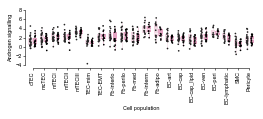

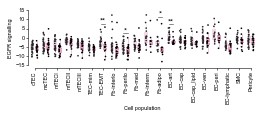

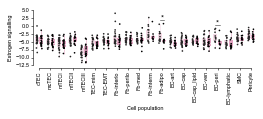

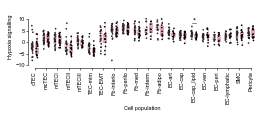

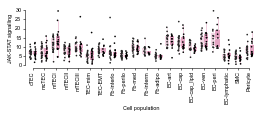

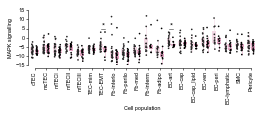

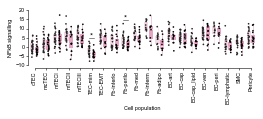

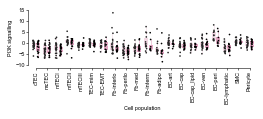

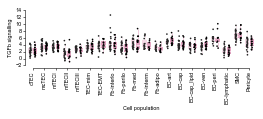

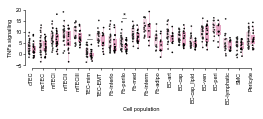

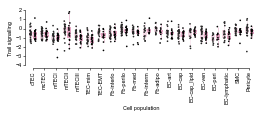

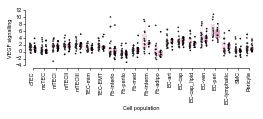

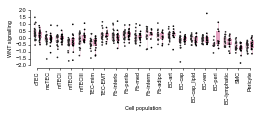

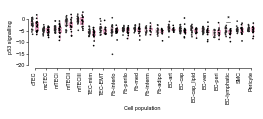

In [31]:
for path in progeny_paths:
    plot_grouped_boxplot(data = progeny2donor_freq, x = 'taa_l3', y = path, hue = 'sex', 
                      order = stroma_lev3, 
                     hue_order = ['M', 'F'], 
                     x_label = 'Cell population', y_label = f'{path} signalling', 
                     legend_title = 'Age group', add_stats = True, format_percent = False, 
                     figsize = (3.3, 1.5), remove_legend = True,
                     palette  = get_tint_palette(thyAgeing_colors['magenta']), 
                     save_stats = f'{results_path}/thyAgeing_stroma_taa_l3_{path}_sex')
    plt.savefig(f'{plot_path}/thyAgeing_stroma_taa_l3_{path}_sex_LM_style_boxplot_pink.pdf')
    

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Androgen signalling'>

2025-11-17 12:46:46 | [INFO] maxp pruned
2025-11-17 12:46:46 | [INFO] LTSH dropped
2025-11-17 12:46:46 | [INFO] cmap pruned
2025-11-17 12:46:46 | [INFO] kern pruned
2025-11-17 12:46:46 | [INFO] post pruned
2025-11-17 12:46:46 | [INFO] PCLT dropped
2025-11-17 12:46:46 | [INFO] JSTF dropped
2025-11-17 12:46:46 | [INFO] DSIG dropped
2025-11-17 12:46:46 | [INFO] GSUB pruned
2025-11-17 12:46:46 | [INFO] glyf pruned
2025-11-17 12:46:46 | [INFO] Added gid0 to subset
2025-11-17 12:46:46 | [INFO] Added first four glyphs to subset
2025-11-17 12:46:46 | [INFO] Closing glyph list over 'GSUB': 42 glyphs before
2025-11-17 12:46:46 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'P', 'S', 'T', 'a', 'asterisk', 'b', 'c', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-17 12:46:46 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 21, 23,

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='EGFR signalling'>

2025-11-17 12:46:48 | [INFO] maxp pruned
2025-11-17 12:46:48 | [INFO] LTSH dropped
2025-11-17 12:46:48 | [INFO] cmap pruned
2025-11-17 12:46:48 | [INFO] kern pruned
2025-11-17 12:46:48 | [INFO] post pruned
2025-11-17 12:46:48 | [INFO] PCLT dropped
2025-11-17 12:46:48 | [INFO] JSTF dropped
2025-11-17 12:46:48 | [INFO] DSIG dropped
2025-11-17 12:46:48 | [INFO] GSUB pruned
2025-11-17 12:46:48 | [INFO] glyf pruned
2025-11-17 12:46:48 | [INFO] Added gid0 to subset
2025-11-17 12:46:48 | [INFO] Added first four glyphs to subset
2025-11-17 12:46:48 | [INFO] Closing glyph list over 'GSUB': 42 glyphs before
2025-11-17 12:46:48 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'G', 'I', 'M', 'P', 'R', 'S', 'T', 'a', 'asterisk', 'b', 'c', 'd', 'e', 'f', 'five', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-17 12:46:48 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 24, 36, 3

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Estrogen signalling'>

2025-11-17 12:46:50 | [INFO] maxp pruned
2025-11-17 12:46:50 | [INFO] LTSH dropped
2025-11-17 12:46:50 | [INFO] cmap pruned
2025-11-17 12:46:50 | [INFO] kern pruned
2025-11-17 12:46:50 | [INFO] post pruned
2025-11-17 12:46:50 | [INFO] PCLT dropped
2025-11-17 12:46:50 | [INFO] JSTF dropped
2025-11-17 12:46:50 | [INFO] DSIG dropped
2025-11-17 12:46:50 | [INFO] GSUB pruned
2025-11-17 12:46:50 | [INFO] glyf pruned
2025-11-17 12:46:50 | [INFO] Added gid0 to subset
2025-11-17 12:46:50 | [INFO] Added first four glyphs to subset
2025-11-17 12:46:50 | [INFO] Closing glyph list over 'GSUB': 43 glyphs before
2025-11-17 12:46:50 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'P', 'S', 'T', 'a', 'asterisk', 'b', 'c', 'd', 'e', 'f', 'five', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-17 12:46:50 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 1

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Hypoxia signalling'>

2025-11-17 12:46:53 | [INFO] maxp pruned
2025-11-17 12:46:53 | [INFO] LTSH dropped
2025-11-17 12:46:53 | [INFO] cmap pruned
2025-11-17 12:46:53 | [INFO] kern pruned
2025-11-17 12:46:53 | [INFO] post pruned
2025-11-17 12:46:53 | [INFO] PCLT dropped
2025-11-17 12:46:53 | [INFO] JSTF dropped
2025-11-17 12:46:53 | [INFO] DSIG dropped
2025-11-17 12:46:53 | [INFO] GSUB pruned
2025-11-17 12:46:53 | [INFO] glyf pruned
2025-11-17 12:46:53 | [INFO] Added gid0 to subset
2025-11-17 12:46:53 | [INFO] Added first four glyphs to subset
2025-11-17 12:46:53 | [INFO] Closing glyph list over 'GSUB': 42 glyphs before
2025-11-17 12:46:53 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'H', 'I', 'M', 'P', 'S', 'T', 'a', 'asterisk', 'b', 'c', 'd', 'e', 'f', 'five', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'u', 'underscore', 'v', 'x', 'y', 'zero']
2025-11-17 12:46:53 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 24, 36, 3

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='JAK-STAT signalling'>

2025-11-17 12:46:56 | [INFO] maxp pruned
2025-11-17 12:46:56 | [INFO] LTSH dropped
2025-11-17 12:46:56 | [INFO] cmap pruned
2025-11-17 12:46:56 | [INFO] kern pruned
2025-11-17 12:46:56 | [INFO] post pruned
2025-11-17 12:46:56 | [INFO] PCLT dropped
2025-11-17 12:46:56 | [INFO] JSTF dropped
2025-11-17 12:46:56 | [INFO] DSIG dropped
2025-11-17 12:46:56 | [INFO] GSUB pruned
2025-11-17 12:46:56 | [INFO] glyf pruned
2025-11-17 12:46:56 | [INFO] Added gid0 to subset
2025-11-17 12:46:56 | [INFO] Added first four glyphs to subset
2025-11-17 12:46:56 | [INFO] Closing glyph list over 'GSUB': 43 glyphs before
2025-11-17 12:46:56 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'J', 'K', 'M', 'P', 'S', 'T', 'a', 'asterisk', 'b', 'c', 'd', 'e', 'f', 'five', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-17 12:46:56 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 21

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='MAPK signalling'>

2025-11-17 12:46:59 | [INFO] maxp pruned
2025-11-17 12:46:59 | [INFO] LTSH dropped
2025-11-17 12:46:59 | [INFO] cmap pruned
2025-11-17 12:46:59 | [INFO] kern pruned
2025-11-17 12:46:59 | [INFO] post pruned
2025-11-17 12:46:59 | [INFO] PCLT dropped
2025-11-17 12:46:59 | [INFO] JSTF dropped
2025-11-17 12:46:59 | [INFO] DSIG dropped
2025-11-17 12:46:59 | [INFO] GSUB pruned
2025-11-17 12:46:59 | [INFO] glyf pruned
2025-11-17 12:46:59 | [INFO] Added gid0 to subset
2025-11-17 12:46:59 | [INFO] Added first four glyphs to subset
2025-11-17 12:46:59 | [INFO] Closing glyph list over 'GSUB': 41 glyphs before
2025-11-17 12:46:59 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'K', 'M', 'P', 'S', 'T', 'a', 'asterisk', 'b', 'c', 'd', 'e', 'f', 'five', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-17 12:46:59 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 24, 36, 38, 40

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='NFkB signalling'>

2025-11-17 12:47:02 | [INFO] maxp pruned
2025-11-17 12:47:02 | [INFO] LTSH dropped
2025-11-17 12:47:02 | [INFO] cmap pruned
2025-11-17 12:47:02 | [INFO] kern pruned
2025-11-17 12:47:02 | [INFO] post pruned
2025-11-17 12:47:02 | [INFO] PCLT dropped
2025-11-17 12:47:02 | [INFO] JSTF dropped
2025-11-17 12:47:02 | [INFO] DSIG dropped
2025-11-17 12:47:02 | [INFO] GSUB pruned
2025-11-17 12:47:02 | [INFO] glyf pruned
2025-11-17 12:47:02 | [INFO] Added gid0 to subset
2025-11-17 12:47:02 | [INFO] Added first four glyphs to subset
2025-11-17 12:47:02 | [INFO] Closing glyph list over 'GSUB': 44 glyphs before
2025-11-17 12:47:02 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'I', 'M', 'N', 'P', 'S', 'T', 'a', 'asterisk', 'b', 'c', 'd', 'e', 'f', 'five', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-17 12:47:02 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 2

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='PI3K signalling'>

2025-11-17 12:47:04 | [INFO] maxp pruned
2025-11-17 12:47:04 | [INFO] LTSH dropped
2025-11-17 12:47:04 | [INFO] cmap pruned
2025-11-17 12:47:04 | [INFO] kern pruned
2025-11-17 12:47:04 | [INFO] post pruned
2025-11-17 12:47:04 | [INFO] PCLT dropped
2025-11-17 12:47:04 | [INFO] JSTF dropped
2025-11-17 12:47:04 | [INFO] DSIG dropped
2025-11-17 12:47:04 | [INFO] GSUB pruned
2025-11-17 12:47:04 | [INFO] glyf pruned
2025-11-17 12:47:04 | [INFO] Added gid0 to subset
2025-11-17 12:47:04 | [INFO] Added first four glyphs to subset
2025-11-17 12:47:04 | [INFO] Closing glyph list over 'GSUB': 42 glyphs before
2025-11-17 12:47:04 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'K', 'M', 'P', 'S', 'T', 'a', 'asterisk', 'b', 'c', 'd', 'e', 'f', 'five', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-17 12:47:04 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 22, 2

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='TGFb signalling'>

2025-11-17 12:47:06 | [INFO] maxp pruned
2025-11-17 12:47:06 | [INFO] LTSH dropped
2025-11-17 12:47:06 | [INFO] cmap pruned
2025-11-17 12:47:06 | [INFO] kern pruned
2025-11-17 12:47:06 | [INFO] post pruned
2025-11-17 12:47:06 | [INFO] PCLT dropped
2025-11-17 12:47:06 | [INFO] JSTF dropped
2025-11-17 12:47:06 | [INFO] DSIG dropped
2025-11-17 12:47:06 | [INFO] GSUB pruned
2025-11-17 12:47:06 | [INFO] glyf pruned
2025-11-17 12:47:06 | [INFO] Added gid0 to subset
2025-11-17 12:47:06 | [INFO] Added first four glyphs to subset
2025-11-17 12:47:06 | [INFO] Closing glyph list over 'GSUB': 43 glyphs before
2025-11-17 12:47:06 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'G', 'I', 'M', 'P', 'S', 'T', 'a', 'asterisk', 'b', 'c', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-17 12:47:06 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 

Performing Kruskal-Wallis and Dunn tests
No significant results found


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='TNFa signalling'>

2025-11-17 12:47:07 | [INFO] maxp pruned
2025-11-17 12:47:07 | [INFO] LTSH dropped
2025-11-17 12:47:07 | [INFO] cmap pruned
2025-11-17 12:47:07 | [INFO] kern pruned
2025-11-17 12:47:07 | [INFO] post pruned
2025-11-17 12:47:07 | [INFO] PCLT dropped
2025-11-17 12:47:07 | [INFO] JSTF dropped
2025-11-17 12:47:07 | [INFO] DSIG dropped
2025-11-17 12:47:07 | [INFO] GSUB pruned
2025-11-17 12:47:07 | [INFO] glyf pruned
2025-11-17 12:47:07 | [INFO] Added gid0 to subset
2025-11-17 12:47:07 | [INFO] Added first four glyphs to subset
2025-11-17 12:47:07 | [INFO] Closing glyph list over 'GSUB': 41 glyphs before
2025-11-17 12:47:07 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'N', 'P', 'S', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'five', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-17 12:47:07 | [INFO] Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 24, 36, 38, 40, 41,

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Trail signalling'>

2025-11-17 12:47:09 | [INFO] maxp pruned
2025-11-17 12:47:09 | [INFO] LTSH dropped
2025-11-17 12:47:09 | [INFO] cmap pruned
2025-11-17 12:47:09 | [INFO] kern pruned
2025-11-17 12:47:09 | [INFO] post pruned
2025-11-17 12:47:09 | [INFO] PCLT dropped
2025-11-17 12:47:09 | [INFO] JSTF dropped
2025-11-17 12:47:09 | [INFO] DSIG dropped
2025-11-17 12:47:09 | [INFO] GSUB pruned
2025-11-17 12:47:09 | [INFO] glyf pruned
2025-11-17 12:47:09 | [INFO] Added gid0 to subset
2025-11-17 12:47:09 | [INFO] Added first four glyphs to subset
2025-11-17 12:47:09 | [INFO] Closing glyph list over 'GSUB': 42 glyphs before
2025-11-17 12:47:09 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'P', 'S', 'T', 'a', 'asterisk', 'b', 'c', 'd', 'e', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-17 12:47:09 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 21,

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='VEGF signalling'>

2025-11-17 12:47:12 | [INFO] maxp pruned
2025-11-17 12:47:12 | [INFO] LTSH dropped
2025-11-17 12:47:12 | [INFO] cmap pruned
2025-11-17 12:47:12 | [INFO] kern pruned
2025-11-17 12:47:12 | [INFO] post pruned
2025-11-17 12:47:12 | [INFO] PCLT dropped
2025-11-17 12:47:12 | [INFO] JSTF dropped
2025-11-17 12:47:12 | [INFO] DSIG dropped
2025-11-17 12:47:12 | [INFO] GSUB pruned
2025-11-17 12:47:12 | [INFO] glyf pruned
2025-11-17 12:47:12 | [INFO] Added gid0 to subset
2025-11-17 12:47:12 | [INFO] Added first four glyphs to subset
2025-11-17 12:47:12 | [INFO] Closing glyph list over 'GSUB': 45 glyphs before
2025-11-17 12:47:12 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'G', 'I', 'M', 'P', 'S', 'T', 'V', 'a', 'asterisk', 'b', 'c', 'd', 'e', 'f', 'five', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-17 12:47:12 | [INFO] Glyph IDs:   [0, 1, 2, 3,

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='WNT signalling'>

2025-11-17 12:47:14 | [INFO] maxp pruned
2025-11-17 12:47:14 | [INFO] LTSH dropped
2025-11-17 12:47:14 | [INFO] cmap pruned
2025-11-17 12:47:14 | [INFO] kern pruned
2025-11-17 12:47:14 | [INFO] post pruned
2025-11-17 12:47:14 | [INFO] PCLT dropped
2025-11-17 12:47:14 | [INFO] JSTF dropped
2025-11-17 12:47:14 | [INFO] DSIG dropped
2025-11-17 12:47:14 | [INFO] GSUB pruned
2025-11-17 12:47:14 | [INFO] glyf pruned
2025-11-17 12:47:14 | [INFO] Added gid0 to subset
2025-11-17 12:47:14 | [INFO] Added first four glyphs to subset
2025-11-17 12:47:14 | [INFO] Closing glyph list over 'GSUB': 42 glyphs before
2025-11-17 12:47:14 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'N', 'P', 'S', 'T', 'W', 'a', 'asterisk', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-17 12:47:14 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 21, 36, 38

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='p53 signalling'>

2025-11-17 12:47:16 | [INFO] maxp pruned
2025-11-17 12:47:16 | [INFO] LTSH dropped
2025-11-17 12:47:16 | [INFO] cmap pruned
2025-11-17 12:47:16 | [INFO] kern pruned
2025-11-17 12:47:16 | [INFO] post pruned
2025-11-17 12:47:16 | [INFO] PCLT dropped
2025-11-17 12:47:16 | [INFO] JSTF dropped
2025-11-17 12:47:16 | [INFO] DSIG dropped
2025-11-17 12:47:16 | [INFO] GSUB pruned
2025-11-17 12:47:16 | [INFO] glyf pruned
2025-11-17 12:47:16 | [INFO] Added gid0 to subset
2025-11-17 12:47:16 | [INFO] Added first four glyphs to subset
2025-11-17 12:47:16 | [INFO] Closing glyph list over 'GSUB': 42 glyphs before
2025-11-17 12:47:16 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'P', 'S', 'T', 'a', 'asterisk', 'b', 'c', 'd', 'e', 'f', 'five', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-17 12:47:16 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 21,

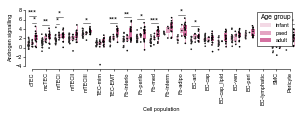

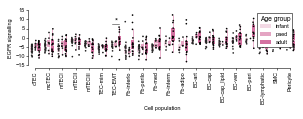

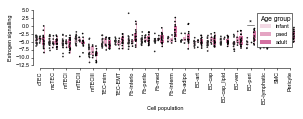

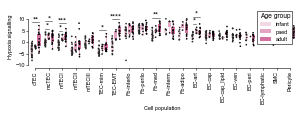

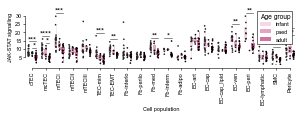

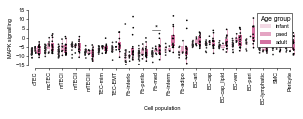

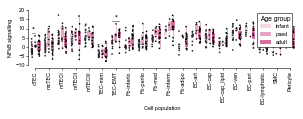

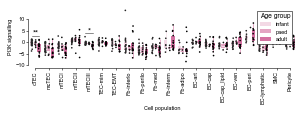

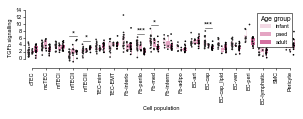

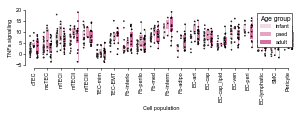

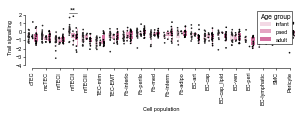

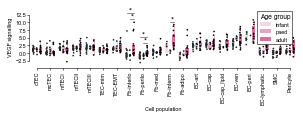

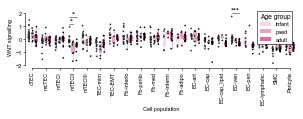

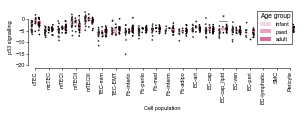

In [77]:
for path in progeny_paths:
    plot_grouped_boxplot(data = progeny2donor_freq, x = 'taa_l3', y = path, hue = 'age_group', 
                      order = stroma_lev3, 
                     hue_order = ['infant', 'paed', 'adult'], 
                     x_label = 'Cell population', y_label = f'{path} signalling', 
                     legend_title = 'Age group', add_stats = True, format_percent = False, 
                     figsize = (3.8, 1.5), remove_legend = False,
                     palette  = get_tint_palette(thyAgeing_colors['magenta']), 
                     save_stats = f'{results_path}/thyAgeing_stroma_taa_l3_{path}')
    plt.savefig(f'{plot_path}/thyAgeing_stroma_taa_l3_{path}_LM_style_boxplot_pink.pdf')
    

In [86]:
tec_lev3

['cTEC', 'mcTEC', 'mTECI', 'mTECII', 'mTECIII', 'TEC-mim', 'TEC-EMT']

### Quantify change across TECs specifically

In [32]:
progeny2donor_freq_tec = progeny2donor_freq.loc[progeny2donor_freq['taa_l3'].isin(tec_lev3),].copy()

In [36]:
progeny2donor_freq_tec['age_group'].unique().tolist()

['adult', 'infant', 'paed']

In [37]:
progeny2donor_freq_tec_inf = progeny2donor_freq_tec.loc[progeny2donor_freq_tec['age_group']=='infant',].copy()
progeny2donor_freq_tec_paed = progeny2donor_freq_tec.loc[progeny2donor_freq_tec['age_group']=='paed',].copy()
progeny2donor_freq_tec_adult = progeny2donor_freq_tec.loc[progeny2donor_freq_tec['age_group']=='adult',].copy()

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Androgen signalling'>

2025-11-17 13:50:47 | [INFO] maxp pruned
2025-11-17 13:50:47 | [INFO] LTSH dropped
2025-11-17 13:50:47 | [INFO] cmap pruned
2025-11-17 13:50:47 | [INFO] kern pruned
2025-11-17 13:50:47 | [INFO] post pruned
2025-11-17 13:50:47 | [INFO] PCLT dropped
2025-11-17 13:50:47 | [INFO] JSTF dropped
2025-11-17 13:50:47 | [INFO] DSIG dropped
2025-11-17 13:50:47 | [INFO] GSUB pruned
2025-11-17 13:50:47 | [INFO] glyf pruned
2025-11-17 13:50:47 | [INFO] Added gid0 to subset
2025-11-17 13:50:47 | [INFO] Added first four glyphs to subset
2025-11-17 13:50:47 | [INFO] Closing glyph list over 'GSUB': 32 glyphs before
2025-11-17 13:50:47 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'I', 'M', 'T', 'a', 'asterisk', 'c', 'd', 'e', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'zero']
2025-11-17 13:50:47 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 21, 23, 25, 36, 38, 40, 44, 48, 55, 68, 70, 71, 72, 74, 76, 79, 80, 81

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='EGFR signalling'>

2025-11-17 13:50:50 | [INFO] maxp pruned
2025-11-17 13:50:50 | [INFO] LTSH dropped
2025-11-17 13:50:50 | [INFO] cmap pruned
2025-11-17 13:50:50 | [INFO] kern pruned
2025-11-17 13:50:50 | [INFO] post pruned
2025-11-17 13:50:50 | [INFO] PCLT dropped
2025-11-17 13:50:50 | [INFO] JSTF dropped
2025-11-17 13:50:50 | [INFO] DSIG dropped
2025-11-17 13:50:50 | [INFO] GSUB pruned
2025-11-17 13:50:50 | [INFO] glyf pruned
2025-11-17 13:50:50 | [INFO] Added gid0 to subset
2025-11-17 13:50:50 | [INFO] Added first four glyphs to subset
2025-11-17 13:50:50 | [INFO] Closing glyph list over 'GSUB': 31 glyphs before
2025-11-17 13:50:50 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'G', 'I', 'M', 'R', 'T', 'a', 'asterisk', 'c', 'e', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 's', 'space', 't', 'u', 'zero']
2025-11-17 13:50:50 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 24, 38, 40, 41, 42, 44, 48, 53, 55, 68, 70, 72, 74, 76, 79, 80, 81, 82, 8

Performing Kruskal-Wallis and Dunn tests
No significant results found


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Estrogen signalling'>

2025-11-17 13:50:52 | [INFO] maxp pruned
2025-11-17 13:50:52 | [INFO] LTSH dropped
2025-11-17 13:50:52 | [INFO] cmap pruned
2025-11-17 13:50:52 | [INFO] kern pruned
2025-11-17 13:50:52 | [INFO] post pruned
2025-11-17 13:50:52 | [INFO] PCLT dropped
2025-11-17 13:50:52 | [INFO] JSTF dropped
2025-11-17 13:50:52 | [INFO] DSIG dropped
2025-11-17 13:50:52 | [INFO] GSUB pruned
2025-11-17 13:50:52 | [INFO] glyf pruned
2025-11-17 13:50:52 | [INFO] Added gid0 to subset
2025-11-17 13:50:52 | [INFO] Added first four glyphs to subset
2025-11-17 13:50:52 | [INFO] Closing glyph list over 'GSUB': 31 glyphs before
2025-11-17 13:50:52 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'I', 'M', 'T', 'a', 'c', 'e', 'eight', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'zero']
2025-11-17 13:50:52 | [INFO] Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 23, 25, 27, 38, 40, 44, 48, 55, 68, 70, 72, 74, 76, 79, 80, 81, 82, 83, 

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Hypoxia signalling'>

2025-11-17 13:50:55 | [INFO] maxp pruned
2025-11-17 13:50:55 | [INFO] LTSH dropped
2025-11-17 13:50:55 | [INFO] cmap pruned
2025-11-17 13:50:55 | [INFO] kern pruned
2025-11-17 13:50:55 | [INFO] post pruned
2025-11-17 13:50:55 | [INFO] PCLT dropped
2025-11-17 13:50:55 | [INFO] JSTF dropped
2025-11-17 13:50:55 | [INFO] DSIG dropped
2025-11-17 13:50:55 | [INFO] GSUB pruned
2025-11-17 13:50:55 | [INFO] glyf pruned
2025-11-17 13:50:55 | [INFO] Added gid0 to subset
2025-11-17 13:50:55 | [INFO] Added first four glyphs to subset
2025-11-17 13:50:55 | [INFO] Closing glyph list over 'GSUB': 31 glyphs before
2025-11-17 13:50:55 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'H', 'I', 'M', 'T', 'a', 'asterisk', 'c', 'e', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 's', 'space', 't', 'u', 'x', 'y', 'zero']
2025-11-17 13:50:55 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 24, 38, 40, 43, 44, 48, 55, 68, 70, 72, 74, 76, 79, 80, 81, 82, 83, 86, 8

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='JAK-STAT signalling'>

2025-11-17 13:50:58 | [INFO] maxp pruned
2025-11-17 13:50:58 | [INFO] LTSH dropped
2025-11-17 13:50:58 | [INFO] cmap pruned
2025-11-17 13:50:58 | [INFO] kern pruned
2025-11-17 13:50:58 | [INFO] post pruned
2025-11-17 13:50:58 | [INFO] PCLT dropped
2025-11-17 13:50:58 | [INFO] JSTF dropped
2025-11-17 13:50:58 | [INFO] DSIG dropped
2025-11-17 13:50:58 | [INFO] GSUB pruned
2025-11-17 13:50:58 | [INFO] glyf pruned
2025-11-17 13:50:58 | [INFO] Added gid0 to subset
2025-11-17 13:50:58 | [INFO] Added first four glyphs to subset
2025-11-17 13:50:58 | [INFO] Closing glyph list over 'GSUB': 33 glyphs before
2025-11-17 13:50:58 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'I', 'J', 'K', 'M', 'S', 'T', 'a', 'asterisk', 'c', 'e', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 's', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-17 13:50:58 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 21, 22, 24, 36, 38, 40, 44, 45, 46, 48, 54, 55, 68, 70, 72, 7

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='MAPK signalling'>

2025-11-17 13:51:00 | [INFO] maxp pruned
2025-11-17 13:51:00 | [INFO] LTSH dropped
2025-11-17 13:51:00 | [INFO] cmap pruned
2025-11-17 13:51:00 | [INFO] kern pruned
2025-11-17 13:51:00 | [INFO] post pruned
2025-11-17 13:51:00 | [INFO] PCLT dropped
2025-11-17 13:51:00 | [INFO] JSTF dropped
2025-11-17 13:51:00 | [INFO] DSIG dropped
2025-11-17 13:51:00 | [INFO] GSUB pruned
2025-11-17 13:51:00 | [INFO] glyf pruned
2025-11-17 13:51:00 | [INFO] Added gid0 to subset
2025-11-17 13:51:00 | [INFO] Added first four glyphs to subset
2025-11-17 13:51:00 | [INFO] Closing glyph list over 'GSUB': 33 glyphs before
2025-11-17 13:51:00 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'I', 'K', 'M', 'P', 'T', 'a', 'c', 'e', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 's', 'seven', 'space', 't', 'two', 'u', 'zero']
2025-11-17 13:51:00 | [INFO] Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 24, 26, 36, 38, 40, 44, 46, 48, 51, 55, 68, 70, 72, 74,

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='NFkB signalling'>

2025-11-17 13:51:02 | [INFO] maxp pruned
2025-11-17 13:51:02 | [INFO] LTSH dropped
2025-11-17 13:51:02 | [INFO] cmap pruned
2025-11-17 13:51:02 | [INFO] kern pruned
2025-11-17 13:51:02 | [INFO] post pruned
2025-11-17 13:51:02 | [INFO] PCLT dropped
2025-11-17 13:51:02 | [INFO] JSTF dropped
2025-11-17 13:51:02 | [INFO] DSIG dropped
2025-11-17 13:51:02 | [INFO] GSUB pruned
2025-11-17 13:51:02 | [INFO] glyf pruned
2025-11-17 13:51:02 | [INFO] Added gid0 to subset
2025-11-17 13:51:02 | [INFO] Added first four glyphs to subset
2025-11-17 13:51:02 | [INFO] Closing glyph list over 'GSUB': 33 glyphs before
2025-11-17 13:51:02 | [INFO] Glyph names: ['.notdef', '.null', 'B', 'C', 'E', 'F', 'I', 'M', 'N', 'T', 'a', 'asterisk', 'c', 'e', 'five', 'g', 'hyphen', 'i', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 's', 'space', 't', 'two', 'u', 'zero']
2025-11-17 13:51:02 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 21, 24, 37, 38, 40, 41, 44, 48, 49, 55, 68, 70, 72, 74, 76, 7

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='PI3K signalling'>

2025-11-17 13:51:04 | [INFO] maxp pruned
2025-11-17 13:51:04 | [INFO] LTSH dropped
2025-11-17 13:51:04 | [INFO] cmap pruned
2025-11-17 13:51:04 | [INFO] kern pruned
2025-11-17 13:51:04 | [INFO] post pruned
2025-11-17 13:51:04 | [INFO] PCLT dropped
2025-11-17 13:51:04 | [INFO] JSTF dropped
2025-11-17 13:51:04 | [INFO] DSIG dropped
2025-11-17 13:51:04 | [INFO] GSUB pruned
2025-11-17 13:51:04 | [INFO] glyf pruned
2025-11-17 13:51:04 | [INFO] Added gid0 to subset
2025-11-17 13:51:04 | [INFO] Added first four glyphs to subset
2025-11-17 13:51:04 | [INFO] Closing glyph list over 'GSUB': 33 glyphs before
2025-11-17 13:51:04 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'I', 'K', 'M', 'P', 'T', 'a', 'asterisk', 'c', 'e', 'eight', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'p', 's', 'six', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-17 13:51:04 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 21, 22, 23, 25, 27, 38, 40, 44, 46, 48, 51, 55, 68, 70, 7

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='TGFb signalling'>

2025-11-17 13:51:06 | [INFO] maxp pruned
2025-11-17 13:51:06 | [INFO] LTSH dropped
2025-11-17 13:51:06 | [INFO] cmap pruned
2025-11-17 13:51:06 | [INFO] kern pruned
2025-11-17 13:51:06 | [INFO] post pruned
2025-11-17 13:51:06 | [INFO] PCLT dropped
2025-11-17 13:51:06 | [INFO] JSTF dropped
2025-11-17 13:51:06 | [INFO] DSIG dropped
2025-11-17 13:51:06 | [INFO] GSUB pruned
2025-11-17 13:51:06 | [INFO] glyf pruned
2025-11-17 13:51:06 | [INFO] Added gid0 to subset
2025-11-17 13:51:06 | [INFO] Added first four glyphs to subset
2025-11-17 13:51:06 | [INFO] Closing glyph list over 'GSUB': 35 glyphs before
2025-11-17 13:51:06 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'G', 'I', 'M', 'T', 'a', 'asterisk', 'b', 'c', 'e', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-17 13:51:06 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 21, 22, 23, 24, 25, 26, 38, 40, 41, 42, 44

Performing Kruskal-Wallis and Dunn tests
No significant results found


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='TNFa signalling'>

2025-11-17 13:51:07 | [INFO] maxp pruned
2025-11-17 13:51:07 | [INFO] LTSH dropped
2025-11-17 13:51:07 | [INFO] cmap pruned
2025-11-17 13:51:07 | [INFO] kern pruned
2025-11-17 13:51:07 | [INFO] post pruned
2025-11-17 13:51:07 | [INFO] PCLT dropped
2025-11-17 13:51:07 | [INFO] JSTF dropped
2025-11-17 13:51:07 | [INFO] DSIG dropped
2025-11-17 13:51:07 | [INFO] GSUB pruned
2025-11-17 13:51:07 | [INFO] glyf pruned
2025-11-17 13:51:07 | [INFO] Added gid0 to subset
2025-11-17 13:51:07 | [INFO] Added first four glyphs to subset
2025-11-17 13:51:07 | [INFO] Closing glyph list over 'GSUB': 30 glyphs before
2025-11-17 13:51:07 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'I', 'M', 'N', 'T', 'a', 'c', 'e', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 's', 'space', 't', 'two', 'u', 'zero']
2025-11-17 13:51:07 | [INFO] Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 24, 38, 40, 41, 44, 48, 49, 55, 68, 70, 72, 74, 76, 79, 80, 81, 82, 83, 86, 87, 88,

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Trail signalling'>

2025-11-17 13:51:09 | [INFO] maxp pruned
2025-11-17 13:51:09 | [INFO] LTSH dropped
2025-11-17 13:51:09 | [INFO] cmap pruned
2025-11-17 13:51:09 | [INFO] kern pruned
2025-11-17 13:51:09 | [INFO] post pruned
2025-11-17 13:51:09 | [INFO] PCLT dropped
2025-11-17 13:51:09 | [INFO] JSTF dropped
2025-11-17 13:51:09 | [INFO] DSIG dropped
2025-11-17 13:51:09 | [INFO] GSUB pruned
2025-11-17 13:51:09 | [INFO] glyf pruned
2025-11-17 13:51:09 | [INFO] Added gid0 to subset
2025-11-17 13:51:09 | [INFO] Added first four glyphs to subset
2025-11-17 13:51:09 | [INFO] Closing glyph list over 'GSUB': 31 glyphs before
2025-11-17 13:51:09 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'I', 'M', 'T', 'a', 'asterisk', 'c', 'e', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-17 13:51:09 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 21, 22, 23, 38, 40, 44, 48, 55, 68, 70, 72, 74, 76, 79, 80, 81, 82,

Performing Kruskal-Wallis and Dunn tests
No significant results found


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='VEGF signalling'>

2025-11-17 13:51:10 | [INFO] maxp pruned
2025-11-17 13:51:10 | [INFO] LTSH dropped
2025-11-17 13:51:10 | [INFO] cmap pruned
2025-11-17 13:51:10 | [INFO] kern pruned
2025-11-17 13:51:10 | [INFO] post pruned
2025-11-17 13:51:10 | [INFO] PCLT dropped
2025-11-17 13:51:10 | [INFO] JSTF dropped
2025-11-17 13:51:10 | [INFO] DSIG dropped
2025-11-17 13:51:10 | [INFO] GSUB pruned
2025-11-17 13:51:10 | [INFO] glyf pruned
2025-11-17 13:51:10 | [INFO] Added gid0 to subset
2025-11-17 13:51:10 | [INFO] Added first four glyphs to subset
2025-11-17 13:51:10 | [INFO] Closing glyph list over 'GSUB': 31 glyphs before
2025-11-17 13:51:10 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'G', 'I', 'M', 'T', 'V', 'a', 'c', 'e', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'p', 's', 'six', 'space', 't', 'two', 'u', 'zero']
2025-11-17 13:51:10 | [INFO] Glyph IDs:   [0, 1, 2, 3, 16, 19, 21, 23, 25, 38, 40, 41, 42, 44, 48, 55, 57, 68, 70, 72, 74, 76, 79, 80, 81, 82, 83, 86

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='WNT signalling'>

2025-11-17 13:51:12 | [INFO] maxp pruned
2025-11-17 13:51:12 | [INFO] LTSH dropped
2025-11-17 13:51:12 | [INFO] cmap pruned
2025-11-17 13:51:12 | [INFO] kern pruned
2025-11-17 13:51:12 | [INFO] post pruned
2025-11-17 13:51:12 | [INFO] PCLT dropped
2025-11-17 13:51:12 | [INFO] JSTF dropped
2025-11-17 13:51:12 | [INFO] DSIG dropped
2025-11-17 13:51:12 | [INFO] GSUB pruned
2025-11-17 13:51:12 | [INFO] glyf pruned
2025-11-17 13:51:12 | [INFO] Added gid0 to subset
2025-11-17 13:51:12 | [INFO] Added first four glyphs to subset
2025-11-17 13:51:12 | [INFO] Closing glyph list over 'GSUB': 30 glyphs before
2025-11-17 13:51:12 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'I', 'M', 'N', 'T', 'W', 'a', 'asterisk', 'c', 'e', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 's', 'space', 't', 'two', 'u', 'zero']
2025-11-17 13:51:12 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 21, 38, 40, 44, 48, 49, 55, 58, 68, 70, 72, 74, 76, 79, 80, 81, 82, 83, 86, 87,

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='p53 signalling'>

2025-11-17 13:51:17 | [INFO] maxp pruned
2025-11-17 13:51:17 | [INFO] LTSH dropped
2025-11-17 13:51:17 | [INFO] cmap pruned
2025-11-17 13:51:17 | [INFO] kern pruned
2025-11-17 13:51:17 | [INFO] post pruned
2025-11-17 13:51:17 | [INFO] PCLT dropped
2025-11-17 13:51:17 | [INFO] JSTF dropped
2025-11-17 13:51:17 | [INFO] DSIG dropped
2025-11-17 13:51:17 | [INFO] GSUB pruned
2025-11-17 13:51:17 | [INFO] glyf pruned
2025-11-17 13:51:17 | [INFO] Added gid0 to subset
2025-11-17 13:51:17 | [INFO] Added first four glyphs to subset
2025-11-17 13:51:17 | [INFO] Closing glyph list over 'GSUB': 32 glyphs before
2025-11-17 13:51:17 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'I', 'M', 'T', 'a', 'c', 'e', 'eight', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 's', 'six', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-17 13:51:17 | [INFO] Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 23, 24, 25, 27, 38, 40, 44, 48, 55, 68, 70, 72, 74, 76, 

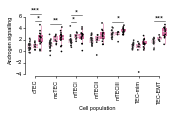

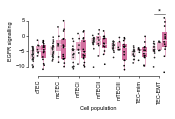

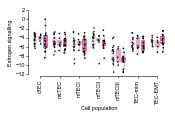

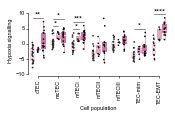

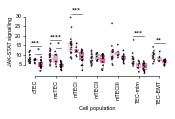

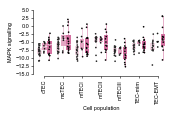

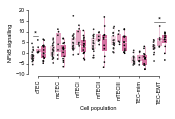

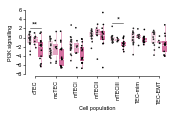

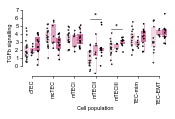

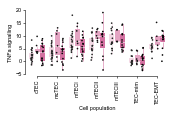

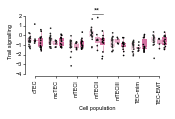

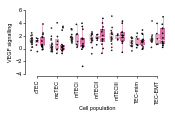

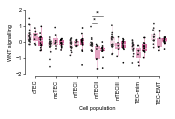

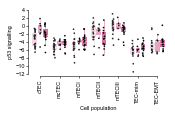

In [91]:
for path in progeny_paths:
    plot_grouped_boxplot(data = progeny2donor_freq_tec, x = 'taa_l3', y = path, hue = 'age_group', 
                      order = tec_lev3, 
                     hue_order = ['infant', 'paed', 'adult'], 
                     x_label = 'Cell population', y_label = f'{path} signalling', 
                     legend_title = 'Age group', add_stats = True, format_percent = False, 
                     figsize = (2.2, 1.5), remove_legend = True,
                     palette  = get_tint_palette(thyAgeing_colors['magenta']), 
                     save_stats = f'{results_path}/thyAgeing_TEC_taa_l3_{path}')
    plt.savefig(f'{plot_path}/thyAgeing_TEC_taa_l3_{path}_LM_style_boxplot_pink.pdf')
    

Performing Kruskal-Wallis and Dunn tests
No significant results found


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Androgen signalling, infant'>

2025-11-20 18:06:32 | [INFO] maxp pruned
2025-11-20 18:06:32 | [INFO] LTSH dropped
2025-11-20 18:06:32 | [INFO] cmap pruned
2025-11-20 18:06:32 | [INFO] kern pruned
2025-11-20 18:06:32 | [INFO] post pruned
2025-11-20 18:06:32 | [INFO] PCLT dropped
2025-11-20 18:06:32 | [INFO] JSTF dropped
2025-11-20 18:06:32 | [INFO] DSIG dropped
2025-11-20 18:06:32 | [INFO] GSUB pruned
2025-11-20 18:06:32 | [INFO] glyf pruned
2025-11-20 18:06:32 | [INFO] Added gid0 to subset
2025-11-20 18:06:32 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:32 | [INFO] Closing glyph list over 'GSUB': 36 glyphs before
2025-11-20 18:06:32 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'T', 'a', 'c', 'comma', 'd', 'e', 'f', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-20 18:06:32 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 21, 22, 23, 24, 36, 38, 40, 41, 44, 48, 55

Performing Kruskal-Wallis and Dunn tests
No significant results found


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Androgen signalling, lpaed'>

2025-11-20 18:06:33 | [INFO] maxp pruned
2025-11-20 18:06:33 | [INFO] LTSH dropped
2025-11-20 18:06:33 | [INFO] cmap pruned
2025-11-20 18:06:33 | [INFO] kern pruned
2025-11-20 18:06:33 | [INFO] post pruned
2025-11-20 18:06:33 | [INFO] PCLT dropped
2025-11-20 18:06:33 | [INFO] JSTF dropped
2025-11-20 18:06:33 | [INFO] DSIG dropped
2025-11-20 18:06:33 | [INFO] GSUB pruned
2025-11-20 18:06:33 | [INFO] glyf pruned
2025-11-20 18:06:33 | [INFO] Added gid0 to subset
2025-11-20 18:06:33 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:33 | [INFO] Closing glyph list over 'GSUB': 34 glyphs before
2025-11-20 18:06:33 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'T', 'a', 'c', 'comma', 'd', 'e', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-20 18:06:33 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 21, 22, 23, 36, 38, 40, 41, 44, 48, 55, 68, 70, 71, 72,

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='Androgen signalling, adult'>

2025-11-20 18:06:33 | [INFO] maxp pruned
2025-11-20 18:06:33 | [INFO] LTSH dropped
2025-11-20 18:06:33 | [INFO] cmap pruned
2025-11-20 18:06:33 | [INFO] kern pruned
2025-11-20 18:06:33 | [INFO] post pruned
2025-11-20 18:06:33 | [INFO] PCLT dropped
2025-11-20 18:06:33 | [INFO] JSTF dropped
2025-11-20 18:06:33 | [INFO] DSIG dropped
2025-11-20 18:06:33 | [INFO] GSUB pruned
2025-11-20 18:06:33 | [INFO] glyf pruned
2025-11-20 18:06:33 | [INFO] Added gid0 to subset
2025-11-20 18:06:33 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:33 | [INFO] Closing glyph list over 'GSUB': 35 glyphs before
2025-11-20 18:06:33 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'T', 'a', 'c', 'comma', 'd', 'e', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-20 18:06:33 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 21, 22, 23, 24, 36, 38, 40, 41, 44, 48, 55, 68,

Performing Kruskal-Wallis and Dunn tests
No significant results found


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='EGFR signalling, infant'>

2025-11-20 18:06:33 | [INFO] maxp pruned
2025-11-20 18:06:33 | [INFO] LTSH dropped
2025-11-20 18:06:33 | [INFO] cmap pruned
2025-11-20 18:06:33 | [INFO] kern pruned
2025-11-20 18:06:33 | [INFO] post pruned
2025-11-20 18:06:33 | [INFO] PCLT dropped
2025-11-20 18:06:33 | [INFO] JSTF dropped
2025-11-20 18:06:33 | [INFO] DSIG dropped
2025-11-20 18:06:33 | [INFO] GSUB pruned
2025-11-20 18:06:33 | [INFO] glyf pruned
2025-11-20 18:06:33 | [INFO] Added gid0 to subset
2025-11-20 18:06:33 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:33 | [INFO] Closing glyph list over 'GSUB': 37 glyphs before
2025-11-20 18:06:33 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'G', 'I', 'M', 'R', 'T', 'a', 'c', 'comma', 'e', 'eight', 'f', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'zero']
2025-11-20 18:06:33 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 21, 23, 25, 27, 36, 38, 40, 41, 42, 44

Performing Kruskal-Wallis and Dunn tests
No significant results found


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='EGFR signalling, lpaed'>

2025-11-20 18:06:34 | [INFO] maxp pruned
2025-11-20 18:06:34 | [INFO] LTSH dropped
2025-11-20 18:06:34 | [INFO] cmap pruned
2025-11-20 18:06:34 | [INFO] kern pruned
2025-11-20 18:06:34 | [INFO] post pruned
2025-11-20 18:06:34 | [INFO] PCLT dropped
2025-11-20 18:06:34 | [INFO] JSTF dropped
2025-11-20 18:06:34 | [INFO] DSIG dropped
2025-11-20 18:06:34 | [INFO] GSUB pruned
2025-11-20 18:06:34 | [INFO] glyf pruned
2025-11-20 18:06:34 | [INFO] Added gid0 to subset
2025-11-20 18:06:34 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:34 | [INFO] Closing glyph list over 'GSUB': 37 glyphs before
2025-11-20 18:06:34 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'G', 'I', 'M', 'R', 'T', 'a', 'c', 'comma', 'd', 'e', 'eight', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'zero']
2025-11-20 18:06:34 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 21, 23, 25, 27, 36, 38, 40, 41, 42, 44

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='EGFR signalling, adult'>

2025-11-20 18:06:34 | [INFO] maxp pruned
2025-11-20 18:06:34 | [INFO] LTSH dropped
2025-11-20 18:06:34 | [INFO] cmap pruned
2025-11-20 18:06:34 | [INFO] kern pruned
2025-11-20 18:06:34 | [INFO] post pruned
2025-11-20 18:06:34 | [INFO] PCLT dropped
2025-11-20 18:06:34 | [INFO] JSTF dropped
2025-11-20 18:06:34 | [INFO] DSIG dropped
2025-11-20 18:06:34 | [INFO] GSUB pruned
2025-11-20 18:06:34 | [INFO] glyf pruned
2025-11-20 18:06:34 | [INFO] Added gid0 to subset
2025-11-20 18:06:34 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:34 | [INFO] Closing glyph list over 'GSUB': 37 glyphs before
2025-11-20 18:06:34 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'G', 'I', 'M', 'R', 'T', 'a', 'c', 'comma', 'd', 'e', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'space', 't', 'two', 'u', 'zero']
2025-11-20 18:06:34 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 24, 26, 36, 38, 40, 41, 42,

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='Estrogen signalling, infant'>

2025-11-20 18:06:35 | [INFO] maxp pruned
2025-11-20 18:06:35 | [INFO] LTSH dropped
2025-11-20 18:06:35 | [INFO] cmap pruned
2025-11-20 18:06:35 | [INFO] kern pruned
2025-11-20 18:06:35 | [INFO] post pruned
2025-11-20 18:06:35 | [INFO] PCLT dropped
2025-11-20 18:06:35 | [INFO] JSTF dropped
2025-11-20 18:06:35 | [INFO] DSIG dropped
2025-11-20 18:06:35 | [INFO] GSUB pruned
2025-11-20 18:06:35 | [INFO] glyf pruned
2025-11-20 18:06:35 | [INFO] Added gid0 to subset
2025-11-20 18:06:35 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:35 | [INFO] Closing glyph list over 'GSUB': 35 glyphs before
2025-11-20 18:06:35 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'T', 'a', 'c', 'comma', 'e', 'eight', 'f', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'zero']
2025-11-20 18:06:35 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 21, 23, 25, 27, 36, 38, 40, 41, 44, 48, 55, 68, 

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='Estrogen signalling, lpaed'>

2025-11-20 18:06:35 | [INFO] maxp pruned
2025-11-20 18:06:35 | [INFO] LTSH dropped
2025-11-20 18:06:35 | [INFO] cmap pruned
2025-11-20 18:06:35 | [INFO] kern pruned
2025-11-20 18:06:35 | [INFO] post pruned
2025-11-20 18:06:35 | [INFO] PCLT dropped
2025-11-20 18:06:35 | [INFO] JSTF dropped
2025-11-20 18:06:35 | [INFO] DSIG dropped
2025-11-20 18:06:35 | [INFO] GSUB pruned
2025-11-20 18:06:35 | [INFO] glyf pruned
2025-11-20 18:06:35 | [INFO] Added gid0 to subset
2025-11-20 18:06:35 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:35 | [INFO] Closing glyph list over 'GSUB': 38 glyphs before
2025-11-20 18:06:35 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'T', 'a', 'c', 'comma', 'd', 'e', 'eight', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'u', 'zero']
2025-11-20 18:06:35 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 22, 23, 24, 25, 26, 2

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='Estrogen signalling, adult'>

2025-11-20 18:06:35 | [INFO] maxp pruned
2025-11-20 18:06:35 | [INFO] LTSH dropped
2025-11-20 18:06:35 | [INFO] cmap pruned
2025-11-20 18:06:35 | [INFO] kern pruned
2025-11-20 18:06:35 | [INFO] post pruned
2025-11-20 18:06:35 | [INFO] PCLT dropped
2025-11-20 18:06:35 | [INFO] JSTF dropped
2025-11-20 18:06:35 | [INFO] DSIG dropped
2025-11-20 18:06:35 | [INFO] GSUB pruned
2025-11-20 18:06:35 | [INFO] glyf pruned
2025-11-20 18:06:35 | [INFO] Added gid0 to subset
2025-11-20 18:06:35 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:35 | [INFO] Closing glyph list over 'GSUB': 35 glyphs before
2025-11-20 18:06:35 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'T', 'a', 'c', 'comma', 'd', 'e', 'eight', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'zero']
2025-11-20 18:06:35 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 21, 23, 25, 27, 36, 38, 40, 41, 44, 48, 55, 68, 

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='Hypoxia signalling, infant'>

2025-11-20 18:06:36 | [INFO] maxp pruned
2025-11-20 18:06:36 | [INFO] LTSH dropped
2025-11-20 18:06:36 | [INFO] cmap pruned
2025-11-20 18:06:36 | [INFO] kern pruned
2025-11-20 18:06:36 | [INFO] post pruned
2025-11-20 18:06:36 | [INFO] PCLT dropped
2025-11-20 18:06:36 | [INFO] JSTF dropped
2025-11-20 18:06:36 | [INFO] DSIG dropped
2025-11-20 18:06:36 | [INFO] GSUB pruned
2025-11-20 18:06:36 | [INFO] glyf pruned
2025-11-20 18:06:36 | [INFO] Added gid0 to subset
2025-11-20 18:06:36 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:36 | [INFO] Closing glyph list over 'GSUB': 37 glyphs before
2025-11-20 18:06:36 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'H', 'I', 'M', 'T', 'a', 'c', 'comma', 'e', 'eight', 'f', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'x', 'y', 'zero']
2025-11-20 18:06:36 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 21, 23, 25, 27, 36, 38, 40, 41, 43, 44, 48, 

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='Hypoxia signalling, lpaed'>

2025-11-20 18:06:36 | [INFO] maxp pruned
2025-11-20 18:06:36 | [INFO] LTSH dropped
2025-11-20 18:06:36 | [INFO] cmap pruned
2025-11-20 18:06:36 | [INFO] kern pruned
2025-11-20 18:06:36 | [INFO] post pruned
2025-11-20 18:06:36 | [INFO] PCLT dropped
2025-11-20 18:06:36 | [INFO] JSTF dropped
2025-11-20 18:06:36 | [INFO] DSIG dropped
2025-11-20 18:06:36 | [INFO] GSUB pruned
2025-11-20 18:06:36 | [INFO] glyf pruned
2025-11-20 18:06:36 | [INFO] Added gid0 to subset
2025-11-20 18:06:36 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:36 | [INFO] Closing glyph list over 'GSUB': 36 glyphs before
2025-11-20 18:06:36 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'H', 'I', 'M', 'T', 'a', 'c', 'comma', 'd', 'e', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'x', 'y', 'zero']
2025-11-20 18:06:36 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 21, 23, 25, 36, 38, 40, 41, 43, 44, 48, 55, 68, 70, 7

Performing Kruskal-Wallis and Dunn tests


<Axes: xlabel='Cell population', ylabel='Hypoxia signalling, adult'>

2025-11-20 18:06:37 | [INFO] maxp pruned
2025-11-20 18:06:37 | [INFO] LTSH dropped
2025-11-20 18:06:37 | [INFO] cmap pruned
2025-11-20 18:06:37 | [INFO] kern pruned
2025-11-20 18:06:37 | [INFO] post pruned
2025-11-20 18:06:37 | [INFO] PCLT dropped
2025-11-20 18:06:37 | [INFO] JSTF dropped
2025-11-20 18:06:37 | [INFO] DSIG dropped
2025-11-20 18:06:37 | [INFO] GSUB pruned
2025-11-20 18:06:37 | [INFO] glyf pruned
2025-11-20 18:06:37 | [INFO] Added gid0 to subset
2025-11-20 18:06:37 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:37 | [INFO] Closing glyph list over 'GSUB': 39 glyphs before
2025-11-20 18:06:37 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'H', 'I', 'M', 'T', 'a', 'asterisk', 'c', 'comma', 'd', 'e', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'space', 't', 'two', 'u', 'x', 'y', 'zero']
2025-11-20 18:06:37 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 15, 16, 17, 19, 20, 21, 24, 26

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='JAK-STAT signalling, infant'>

2025-11-20 18:06:37 | [INFO] maxp pruned
2025-11-20 18:06:37 | [INFO] LTSH dropped
2025-11-20 18:06:37 | [INFO] cmap pruned
2025-11-20 18:06:37 | [INFO] kern pruned
2025-11-20 18:06:37 | [INFO] post pruned
2025-11-20 18:06:37 | [INFO] PCLT dropped
2025-11-20 18:06:37 | [INFO] JSTF dropped
2025-11-20 18:06:37 | [INFO] DSIG dropped
2025-11-20 18:06:37 | [INFO] GSUB pruned
2025-11-20 18:06:37 | [INFO] glyf pruned
2025-11-20 18:06:37 | [INFO] Added gid0 to subset
2025-11-20 18:06:37 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:37 | [INFO] Closing glyph list over 'GSUB': 36 glyphs before
2025-11-20 18:06:37 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'J', 'K', 'M', 'S', 'T', 'a', 'c', 'comma', 'e', 'f', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-20 18:06:37 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 21, 22, 24, 36, 38, 40, 41, 44, 45, 46, 48, 54, 5

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='JAK-STAT signalling, lpaed'>

2025-11-20 18:06:38 | [INFO] maxp pruned
2025-11-20 18:06:38 | [INFO] LTSH dropped
2025-11-20 18:06:38 | [INFO] cmap pruned
2025-11-20 18:06:38 | [INFO] kern pruned
2025-11-20 18:06:38 | [INFO] post pruned
2025-11-20 18:06:38 | [INFO] PCLT dropped
2025-11-20 18:06:38 | [INFO] JSTF dropped
2025-11-20 18:06:38 | [INFO] DSIG dropped
2025-11-20 18:06:38 | [INFO] GSUB pruned
2025-11-20 18:06:38 | [INFO] glyf pruned
2025-11-20 18:06:38 | [INFO] Added gid0 to subset
2025-11-20 18:06:38 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:38 | [INFO] Closing glyph list over 'GSUB': 37 glyphs before
2025-11-20 18:06:38 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'J', 'K', 'M', 'S', 'T', 'a', 'c', 'comma', 'd', 'e', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'space', 't', 'two', 'u', 'zero']
2025-11-20 18:06:38 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 24, 26, 36, 38, 40, 41, 44, 45,

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='JAK-STAT signalling, adult'>

2025-11-20 18:06:38 | [INFO] maxp pruned
2025-11-20 18:06:38 | [INFO] LTSH dropped
2025-11-20 18:06:38 | [INFO] cmap pruned
2025-11-20 18:06:38 | [INFO] kern pruned
2025-11-20 18:06:38 | [INFO] post pruned
2025-11-20 18:06:38 | [INFO] PCLT dropped
2025-11-20 18:06:38 | [INFO] JSTF dropped
2025-11-20 18:06:38 | [INFO] DSIG dropped
2025-11-20 18:06:38 | [INFO] GSUB pruned
2025-11-20 18:06:38 | [INFO] glyf pruned
2025-11-20 18:06:38 | [INFO] Added gid0 to subset
2025-11-20 18:06:38 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:38 | [INFO] Closing glyph list over 'GSUB': 37 glyphs before
2025-11-20 18:06:38 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'J', 'K', 'M', 'S', 'T', 'a', 'c', 'comma', 'd', 'e', 'eight', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'zero']
2025-11-20 18:06:38 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 21, 23, 25, 27, 36, 38, 40, 41, 44, 45, 46

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='MAPK signalling, infant'>

2025-11-20 18:06:38 | [INFO] maxp pruned
2025-11-20 18:06:38 | [INFO] LTSH dropped
2025-11-20 18:06:38 | [INFO] cmap pruned
2025-11-20 18:06:38 | [INFO] kern pruned
2025-11-20 18:06:38 | [INFO] post pruned
2025-11-20 18:06:38 | [INFO] PCLT dropped
2025-11-20 18:06:38 | [INFO] JSTF dropped
2025-11-20 18:06:38 | [INFO] DSIG dropped
2025-11-20 18:06:38 | [INFO] GSUB pruned
2025-11-20 18:06:38 | [INFO] glyf pruned
2025-11-20 18:06:38 | [INFO] Added gid0 to subset
2025-11-20 18:06:38 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:38 | [INFO] Closing glyph list over 'GSUB': 37 glyphs before
2025-11-20 18:06:38 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'K', 'M', 'P', 'T', 'a', 'c', 'comma', 'e', 'eight', 'f', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'zero']
2025-11-20 18:06:38 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 21, 23, 25, 27, 36, 38, 40, 41, 44, 46

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='MAPK signalling, lpaed'>

2025-11-20 18:06:39 | [INFO] maxp pruned
2025-11-20 18:06:39 | [INFO] LTSH dropped
2025-11-20 18:06:39 | [INFO] cmap pruned
2025-11-20 18:06:39 | [INFO] kern pruned
2025-11-20 18:06:39 | [INFO] post pruned
2025-11-20 18:06:39 | [INFO] PCLT dropped
2025-11-20 18:06:39 | [INFO] JSTF dropped
2025-11-20 18:06:39 | [INFO] DSIG dropped
2025-11-20 18:06:39 | [INFO] GSUB pruned
2025-11-20 18:06:39 | [INFO] glyf pruned
2025-11-20 18:06:39 | [INFO] Added gid0 to subset
2025-11-20 18:06:39 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:39 | [INFO] Closing glyph list over 'GSUB': 37 glyphs before
2025-11-20 18:06:39 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'K', 'M', 'P', 'T', 'a', 'c', 'comma', 'd', 'e', 'eight', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'zero']
2025-11-20 18:06:39 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 21, 23, 25, 27, 36, 38, 40, 41, 44, 46

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='MAPK signalling, adult'>

2025-11-20 18:06:39 | [INFO] maxp pruned
2025-11-20 18:06:39 | [INFO] LTSH dropped
2025-11-20 18:06:39 | [INFO] cmap pruned
2025-11-20 18:06:39 | [INFO] kern pruned
2025-11-20 18:06:39 | [INFO] post pruned
2025-11-20 18:06:39 | [INFO] PCLT dropped
2025-11-20 18:06:39 | [INFO] JSTF dropped
2025-11-20 18:06:39 | [INFO] DSIG dropped
2025-11-20 18:06:39 | [INFO] GSUB pruned
2025-11-20 18:06:39 | [INFO] glyf pruned
2025-11-20 18:06:39 | [INFO] Added gid0 to subset
2025-11-20 18:06:39 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:39 | [INFO] Closing glyph list over 'GSUB': 37 glyphs before
2025-11-20 18:06:39 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'K', 'M', 'P', 'T', 'a', 'c', 'comma', 'd', 'e', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'space', 't', 'two', 'u', 'zero']
2025-11-20 18:06:39 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 24, 26, 36, 38, 40, 41, 44,

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='NFkB signalling, infant'>

2025-11-20 18:06:39 | [INFO] maxp pruned
2025-11-20 18:06:39 | [INFO] LTSH dropped
2025-11-20 18:06:39 | [INFO] cmap pruned
2025-11-20 18:06:39 | [INFO] kern pruned
2025-11-20 18:06:39 | [INFO] post pruned
2025-11-20 18:06:39 | [INFO] PCLT dropped
2025-11-20 18:06:39 | [INFO] JSTF dropped
2025-11-20 18:06:39 | [INFO] DSIG dropped
2025-11-20 18:06:39 | [INFO] GSUB pruned
2025-11-20 18:06:39 | [INFO] glyf pruned
2025-11-20 18:06:39 | [INFO] Added gid0 to subset
2025-11-20 18:06:39 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:39 | [INFO] Closing glyph list over 'GSUB': 36 glyphs before
2025-11-20 18:06:39 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'I', 'M', 'N', 'T', 'a', 'c', 'comma', 'e', 'f', 'five', 'g', 'hyphen', 'i', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'two', 'u', 'zero']
2025-11-20 18:06:39 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 21, 24, 36, 37, 38, 40, 41, 44, 48, 49, 55, 68, 7

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='NFkB signalling, lpaed'>

2025-11-20 18:06:40 | [INFO] maxp pruned
2025-11-20 18:06:40 | [INFO] LTSH dropped
2025-11-20 18:06:40 | [INFO] cmap pruned
2025-11-20 18:06:40 | [INFO] kern pruned
2025-11-20 18:06:40 | [INFO] post pruned
2025-11-20 18:06:40 | [INFO] PCLT dropped
2025-11-20 18:06:40 | [INFO] JSTF dropped
2025-11-20 18:06:40 | [INFO] DSIG dropped
2025-11-20 18:06:40 | [INFO] GSUB pruned
2025-11-20 18:06:40 | [INFO] glyf pruned
2025-11-20 18:06:40 | [INFO] Added gid0 to subset
2025-11-20 18:06:40 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:40 | [INFO] Closing glyph list over 'GSUB': 35 glyphs before
2025-11-20 18:06:40 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'I', 'M', 'N', 'T', 'a', 'c', 'comma', 'd', 'e', 'five', 'g', 'hyphen', 'i', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'u', 'zero']
2025-11-20 18:06:40 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 24, 36, 37, 38, 40, 41, 44, 48, 49, 55, 68, 70, 71, 72, 

Performing Kruskal-Wallis and Dunn tests


<Axes: xlabel='Cell population', ylabel='NFkB signalling, adult'>

2025-11-20 18:06:41 | [INFO] maxp pruned
2025-11-20 18:06:41 | [INFO] LTSH dropped
2025-11-20 18:06:41 | [INFO] cmap pruned
2025-11-20 18:06:41 | [INFO] kern pruned
2025-11-20 18:06:41 | [INFO] post pruned
2025-11-20 18:06:41 | [INFO] PCLT dropped
2025-11-20 18:06:41 | [INFO] JSTF dropped
2025-11-20 18:06:41 | [INFO] DSIG dropped
2025-11-20 18:06:41 | [INFO] GSUB pruned
2025-11-20 18:06:41 | [INFO] glyf pruned
2025-11-20 18:06:41 | [INFO] Added gid0 to subset
2025-11-20 18:06:41 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:41 | [INFO] Closing glyph list over 'GSUB': 37 glyphs before
2025-11-20 18:06:41 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'I', 'M', 'N', 'T', 'a', 'asterisk', 'c', 'comma', 'd', 'e', 'five', 'g', 'hyphen', 'i', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'two', 'u', 'zero']
2025-11-20 18:06:41 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 15, 16, 19, 20, 21, 24, 36, 37, 38, 40, 41, 44, 4

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='PI3K signalling, infant'>

2025-11-20 18:06:41 | [INFO] maxp pruned
2025-11-20 18:06:41 | [INFO] LTSH dropped
2025-11-20 18:06:41 | [INFO] cmap pruned
2025-11-20 18:06:41 | [INFO] kern pruned
2025-11-20 18:06:41 | [INFO] post pruned
2025-11-20 18:06:41 | [INFO] PCLT dropped
2025-11-20 18:06:41 | [INFO] JSTF dropped
2025-11-20 18:06:41 | [INFO] DSIG dropped
2025-11-20 18:06:41 | [INFO] GSUB pruned
2025-11-20 18:06:41 | [INFO] glyf pruned
2025-11-20 18:06:41 | [INFO] Added gid0 to subset
2025-11-20 18:06:41 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:41 | [INFO] Closing glyph list over 'GSUB': 36 glyphs before
2025-11-20 18:06:41 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'K', 'M', 'P', 'T', 'a', 'c', 'comma', 'e', 'f', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-20 18:06:41 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 21, 22, 23, 25, 36, 38, 40, 41, 44, 46, 48, 51, 5

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='PI3K signalling, lpaed'>

2025-11-20 18:06:42 | [INFO] maxp pruned
2025-11-20 18:06:42 | [INFO] LTSH dropped
2025-11-20 18:06:42 | [INFO] cmap pruned
2025-11-20 18:06:42 | [INFO] kern pruned
2025-11-20 18:06:42 | [INFO] post pruned
2025-11-20 18:06:42 | [INFO] PCLT dropped
2025-11-20 18:06:42 | [INFO] JSTF dropped
2025-11-20 18:06:42 | [INFO] DSIG dropped
2025-11-20 18:06:42 | [INFO] GSUB pruned
2025-11-20 18:06:42 | [INFO] glyf pruned
2025-11-20 18:06:42 | [INFO] Added gid0 to subset
2025-11-20 18:06:42 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:42 | [INFO] Closing glyph list over 'GSUB': 37 glyphs before
2025-11-20 18:06:42 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'K', 'M', 'P', 'T', 'a', 'c', 'comma', 'd', 'e', 'eight', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-20 18:06:42 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 21, 22, 23, 25, 27, 36, 38, 40, 41, 44, 

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='PI3K signalling, adult'>

2025-11-20 18:06:42 | [INFO] maxp pruned
2025-11-20 18:06:42 | [INFO] LTSH dropped
2025-11-20 18:06:42 | [INFO] cmap pruned
2025-11-20 18:06:42 | [INFO] kern pruned
2025-11-20 18:06:42 | [INFO] post pruned
2025-11-20 18:06:42 | [INFO] PCLT dropped
2025-11-20 18:06:42 | [INFO] JSTF dropped
2025-11-20 18:06:42 | [INFO] DSIG dropped
2025-11-20 18:06:42 | [INFO] GSUB pruned
2025-11-20 18:06:42 | [INFO] glyf pruned
2025-11-20 18:06:42 | [INFO] Added gid0 to subset
2025-11-20 18:06:42 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:42 | [INFO] Closing glyph list over 'GSUB': 37 glyphs before
2025-11-20 18:06:42 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'K', 'M', 'P', 'T', 'a', 'c', 'comma', 'd', 'e', 'eight', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-20 18:06:42 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 21, 22, 23, 25, 27, 36, 38, 40, 41, 44, 

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='TGFb signalling, infant'>

2025-11-20 18:06:42 | [INFO] maxp pruned
2025-11-20 18:06:42 | [INFO] LTSH dropped
2025-11-20 18:06:42 | [INFO] cmap pruned
2025-11-20 18:06:42 | [INFO] kern pruned
2025-11-20 18:06:42 | [INFO] post pruned
2025-11-20 18:06:42 | [INFO] PCLT dropped
2025-11-20 18:06:42 | [INFO] JSTF dropped
2025-11-20 18:06:42 | [INFO] DSIG dropped
2025-11-20 18:06:42 | [INFO] GSUB pruned
2025-11-20 18:06:42 | [INFO] glyf pruned
2025-11-20 18:06:42 | [INFO] Added gid0 to subset
2025-11-20 18:06:42 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:42 | [INFO] Closing glyph list over 'GSUB': 38 glyphs before
2025-11-20 18:06:42 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'G', 'I', 'M', 'T', 'a', 'b', 'c', 'comma', 'e', 'f', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-20 18:06:42 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 21, 22, 23, 24, 25, 36, 38, 40

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='TGFb signalling, lpaed'>

2025-11-20 18:06:43 | [INFO] maxp pruned
2025-11-20 18:06:43 | [INFO] LTSH dropped
2025-11-20 18:06:43 | [INFO] cmap pruned
2025-11-20 18:06:43 | [INFO] kern pruned
2025-11-20 18:06:43 | [INFO] post pruned
2025-11-20 18:06:43 | [INFO] PCLT dropped
2025-11-20 18:06:43 | [INFO] JSTF dropped
2025-11-20 18:06:43 | [INFO] DSIG dropped
2025-11-20 18:06:43 | [INFO] GSUB pruned
2025-11-20 18:06:43 | [INFO] glyf pruned
2025-11-20 18:06:43 | [INFO] Added gid0 to subset
2025-11-20 18:06:43 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:43 | [INFO] Closing glyph list over 'GSUB': 38 glyphs before
2025-11-20 18:06:43 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'G', 'I', 'M', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-20 18:06:43 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 21, 22, 23, 24, 25, 36, 38, 40

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='TGFb signalling, adult'>

2025-11-20 18:06:43 | [INFO] maxp pruned
2025-11-20 18:06:43 | [INFO] LTSH dropped
2025-11-20 18:06:43 | [INFO] cmap pruned
2025-11-20 18:06:43 | [INFO] kern pruned
2025-11-20 18:06:43 | [INFO] post pruned
2025-11-20 18:06:43 | [INFO] PCLT dropped
2025-11-20 18:06:43 | [INFO] JSTF dropped
2025-11-20 18:06:43 | [INFO] DSIG dropped
2025-11-20 18:06:43 | [INFO] GSUB pruned
2025-11-20 18:06:43 | [INFO] glyf pruned
2025-11-20 18:06:43 | [INFO] Added gid0 to subset
2025-11-20 18:06:43 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:43 | [INFO] Closing glyph list over 'GSUB': 38 glyphs before
2025-11-20 18:06:43 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'G', 'I', 'M', 'T', 'a', 'b', 'c', 'comma', 'd', 'e', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-20 18:06:43 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 36, 38

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='TNFa signalling, infant'>

2025-11-20 18:06:44 | [INFO] maxp pruned
2025-11-20 18:06:44 | [INFO] LTSH dropped
2025-11-20 18:06:44 | [INFO] cmap pruned
2025-11-20 18:06:44 | [INFO] kern pruned
2025-11-20 18:06:44 | [INFO] post pruned
2025-11-20 18:06:44 | [INFO] PCLT dropped
2025-11-20 18:06:44 | [INFO] JSTF dropped
2025-11-20 18:06:44 | [INFO] DSIG dropped
2025-11-20 18:06:44 | [INFO] GSUB pruned
2025-11-20 18:06:44 | [INFO] glyf pruned
2025-11-20 18:06:44 | [INFO] Added gid0 to subset
2025-11-20 18:06:44 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:44 | [INFO] Closing glyph list over 'GSUB': 34 glyphs before
2025-11-20 18:06:44 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'N', 'T', 'a', 'c', 'comma', 'e', 'f', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'two', 'u', 'zero']
2025-11-20 18:06:44 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 21, 24, 36, 38, 40, 41, 44, 48, 49, 55, 68, 70, 72, 73, 74,

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='TNFa signalling, lpaed'>

2025-11-20 18:06:44 | [INFO] maxp pruned
2025-11-20 18:06:44 | [INFO] LTSH dropped
2025-11-20 18:06:44 | [INFO] cmap pruned
2025-11-20 18:06:44 | [INFO] kern pruned
2025-11-20 18:06:44 | [INFO] post pruned
2025-11-20 18:06:44 | [INFO] PCLT dropped
2025-11-20 18:06:44 | [INFO] JSTF dropped
2025-11-20 18:06:44 | [INFO] DSIG dropped
2025-11-20 18:06:44 | [INFO] GSUB pruned
2025-11-20 18:06:44 | [INFO] glyf pruned
2025-11-20 18:06:44 | [INFO] Added gid0 to subset
2025-11-20 18:06:44 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:44 | [INFO] Closing glyph list over 'GSUB': 36 glyphs before
2025-11-20 18:06:44 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'N', 'T', 'a', 'c', 'comma', 'd', 'e', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'space', 't', 'two', 'u', 'zero']
2025-11-20 18:06:44 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 24, 26, 36, 38, 40, 41, 44, 48, 

Performing Kruskal-Wallis and Dunn tests


<Axes: xlabel='Cell population', ylabel='TNFa signalling, adult'>

2025-11-20 18:06:44 | [INFO] maxp pruned
2025-11-20 18:06:44 | [INFO] LTSH dropped
2025-11-20 18:06:44 | [INFO] cmap pruned
2025-11-20 18:06:44 | [INFO] kern pruned
2025-11-20 18:06:44 | [INFO] post pruned
2025-11-20 18:06:44 | [INFO] PCLT dropped
2025-11-20 18:06:44 | [INFO] JSTF dropped
2025-11-20 18:06:44 | [INFO] DSIG dropped
2025-11-20 18:06:44 | [INFO] GSUB pruned
2025-11-20 18:06:44 | [INFO] glyf pruned
2025-11-20 18:06:44 | [INFO] Added gid0 to subset
2025-11-20 18:06:44 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:44 | [INFO] Closing glyph list over 'GSUB': 35 glyphs before
2025-11-20 18:06:44 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'N', 'T', 'a', 'asterisk', 'c', 'comma', 'd', 'e', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'two', 'u', 'zero']
2025-11-20 18:06:44 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 15, 16, 19, 20, 21, 24, 36, 38, 40, 41, 44, 48, 49, 55, 68,

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='Trail signalling, infant'>

2025-11-20 18:06:45 | [INFO] maxp pruned
2025-11-20 18:06:45 | [INFO] LTSH dropped
2025-11-20 18:06:45 | [INFO] cmap pruned
2025-11-20 18:06:45 | [INFO] kern pruned
2025-11-20 18:06:45 | [INFO] post pruned
2025-11-20 18:06:45 | [INFO] PCLT dropped
2025-11-20 18:06:45 | [INFO] JSTF dropped
2025-11-20 18:06:45 | [INFO] DSIG dropped
2025-11-20 18:06:45 | [INFO] GSUB pruned
2025-11-20 18:06:45 | [INFO] glyf pruned
2025-11-20 18:06:45 | [INFO] Added gid0 to subset
2025-11-20 18:06:45 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:45 | [INFO] Closing glyph list over 'GSUB': 34 glyphs before
2025-11-20 18:06:45 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'T', 'a', 'c', 'comma', 'e', 'f', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-20 18:06:45 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 21, 22, 23, 36, 38, 40, 41, 44, 48, 55, 68, 70, 72, 73,

Performing Kruskal-Wallis and Dunn tests
No significant results found


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Trail signalling, lpaed'>

2025-11-20 18:06:45 | [INFO] maxp pruned
2025-11-20 18:06:45 | [INFO] LTSH dropped
2025-11-20 18:06:45 | [INFO] cmap pruned
2025-11-20 18:06:45 | [INFO] kern pruned
2025-11-20 18:06:45 | [INFO] post pruned
2025-11-20 18:06:45 | [INFO] PCLT dropped
2025-11-20 18:06:45 | [INFO] JSTF dropped
2025-11-20 18:06:45 | [INFO] DSIG dropped
2025-11-20 18:06:45 | [INFO] GSUB pruned
2025-11-20 18:06:45 | [INFO] glyf pruned
2025-11-20 18:06:45 | [INFO] Added gid0 to subset
2025-11-20 18:06:45 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:45 | [INFO] Closing glyph list over 'GSUB': 34 glyphs before
2025-11-20 18:06:45 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'T', 'a', 'c', 'comma', 'd', 'e', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'space', 't', 'two', 'u', 'zero']
2025-11-20 18:06:45 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 24, 36, 38, 40, 41, 44, 48, 55, 68, 70, 71, 72

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='Trail signalling, adult'>

2025-11-20 18:06:46 | [INFO] maxp pruned
2025-11-20 18:06:46 | [INFO] LTSH dropped
2025-11-20 18:06:46 | [INFO] cmap pruned
2025-11-20 18:06:46 | [INFO] kern pruned
2025-11-20 18:06:46 | [INFO] post pruned
2025-11-20 18:06:46 | [INFO] PCLT dropped
2025-11-20 18:06:46 | [INFO] JSTF dropped
2025-11-20 18:06:46 | [INFO] DSIG dropped
2025-11-20 18:06:46 | [INFO] GSUB pruned
2025-11-20 18:06:46 | [INFO] glyf pruned
2025-11-20 18:06:46 | [INFO] Added gid0 to subset
2025-11-20 18:06:46 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:46 | [INFO] Closing glyph list over 'GSUB': 34 glyphs before
2025-11-20 18:06:46 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'T', 'a', 'c', 'comma', 'd', 'e', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'space', 't', 'two', 'u', 'zero']
2025-11-20 18:06:46 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 24, 36, 38, 40, 41, 44, 48, 55, 68, 70, 71, 72

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='VEGF signalling, infant'>

2025-11-20 18:06:46 | [INFO] maxp pruned
2025-11-20 18:06:46 | [INFO] LTSH dropped
2025-11-20 18:06:46 | [INFO] cmap pruned
2025-11-20 18:06:46 | [INFO] kern pruned
2025-11-20 18:06:46 | [INFO] post pruned
2025-11-20 18:06:46 | [INFO] PCLT dropped
2025-11-20 18:06:46 | [INFO] JSTF dropped
2025-11-20 18:06:46 | [INFO] DSIG dropped
2025-11-20 18:06:46 | [INFO] GSUB pruned
2025-11-20 18:06:46 | [INFO] glyf pruned
2025-11-20 18:06:46 | [INFO] Added gid0 to subset
2025-11-20 18:06:46 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:46 | [INFO] Closing glyph list over 'GSUB': 38 glyphs before
2025-11-20 18:06:46 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'G', 'I', 'M', 'T', 'V', 'a', 'c', 'comma', 'e', 'f', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-20 18:06:46 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 21, 22, 23, 24, 25, 36, 38, 40

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='VEGF signalling, lpaed'>

2025-11-20 18:06:46 | [INFO] maxp pruned
2025-11-20 18:06:46 | [INFO] LTSH dropped
2025-11-20 18:06:46 | [INFO] cmap pruned
2025-11-20 18:06:46 | [INFO] kern pruned
2025-11-20 18:06:46 | [INFO] post pruned
2025-11-20 18:06:46 | [INFO] PCLT dropped
2025-11-20 18:06:46 | [INFO] JSTF dropped
2025-11-20 18:06:46 | [INFO] DSIG dropped
2025-11-20 18:06:46 | [INFO] GSUB pruned
2025-11-20 18:06:46 | [INFO] glyf pruned
2025-11-20 18:06:46 | [INFO] Added gid0 to subset
2025-11-20 18:06:46 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:46 | [INFO] Closing glyph list over 'GSUB': 37 glyphs before
2025-11-20 18:06:46 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'G', 'I', 'M', 'T', 'V', 'a', 'c', 'comma', 'd', 'e', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-20 18:06:46 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 21, 22, 23, 24, 36, 38, 40, 41, 42, 4

Performing Kruskal-Wallis and Dunn tests


<Axes: xlabel='Cell population', ylabel='VEGF signalling, adult'>

2025-11-20 18:06:47 | [INFO] maxp pruned
2025-11-20 18:06:47 | [INFO] LTSH dropped
2025-11-20 18:06:47 | [INFO] cmap pruned
2025-11-20 18:06:47 | [INFO] kern pruned
2025-11-20 18:06:47 | [INFO] post pruned
2025-11-20 18:06:47 | [INFO] PCLT dropped
2025-11-20 18:06:47 | [INFO] JSTF dropped
2025-11-20 18:06:47 | [INFO] DSIG dropped
2025-11-20 18:06:47 | [INFO] GSUB pruned
2025-11-20 18:06:47 | [INFO] glyf pruned
2025-11-20 18:06:47 | [INFO] Added gid0 to subset
2025-11-20 18:06:47 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:47 | [INFO] Closing glyph list over 'GSUB': 35 glyphs before
2025-11-20 18:06:47 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'G', 'I', 'M', 'T', 'V', 'a', 'asterisk', 'c', 'comma', 'd', 'e', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't', 'two', 'u', 'zero']
2025-11-20 18:06:47 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 15, 16, 19, 21, 23, 36, 38, 40, 41, 42, 44, 48, 55, 57, 68, 7

Performing Kruskal-Wallis and Dunn tests


<Axes: xlabel='Cell population', ylabel='WNT signalling, infant'>

2025-11-20 18:06:47 | [INFO] maxp pruned
2025-11-20 18:06:47 | [INFO] LTSH dropped
2025-11-20 18:06:47 | [INFO] cmap pruned
2025-11-20 18:06:47 | [INFO] kern pruned
2025-11-20 18:06:47 | [INFO] post pruned
2025-11-20 18:06:47 | [INFO] PCLT dropped
2025-11-20 18:06:47 | [INFO] JSTF dropped
2025-11-20 18:06:47 | [INFO] DSIG dropped
2025-11-20 18:06:47 | [INFO] GSUB pruned
2025-11-20 18:06:47 | [INFO] glyf pruned
2025-11-20 18:06:47 | [INFO] Added gid0 to subset
2025-11-20 18:06:47 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:47 | [INFO] Closing glyph list over 'GSUB': 37 glyphs before
2025-11-20 18:06:47 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'N', 'T', 'W', 'a', 'asterisk', 'c', 'comma', 'e', 'f', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'space', 't', 'two', 'u', 'zero']
2025-11-20 18:06:47 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 15, 16, 17, 19, 20, 21, 24, 36, 38, 40, 41, 

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='WNT signalling, lpaed'>

2025-11-20 18:06:48 | [INFO] maxp pruned
2025-11-20 18:06:48 | [INFO] LTSH dropped
2025-11-20 18:06:48 | [INFO] cmap pruned
2025-11-20 18:06:48 | [INFO] kern pruned
2025-11-20 18:06:48 | [INFO] post pruned
2025-11-20 18:06:48 | [INFO] PCLT dropped
2025-11-20 18:06:48 | [INFO] JSTF dropped
2025-11-20 18:06:48 | [INFO] DSIG dropped
2025-11-20 18:06:48 | [INFO] GSUB pruned
2025-11-20 18:06:48 | [INFO] glyf pruned
2025-11-20 18:06:48 | [INFO] Added gid0 to subset
2025-11-20 18:06:48 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:48 | [INFO] Closing glyph list over 'GSUB': 36 glyphs before
2025-11-20 18:06:48 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'N', 'T', 'W', 'a', 'c', 'comma', 'd', 'e', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'space', 't', 'two', 'u', 'zero']
2025-11-20 18:06:48 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 24, 36, 38, 40, 41, 44, 48, 49, 55, 

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='WNT signalling, adult'>

2025-11-20 18:06:48 | [INFO] maxp pruned
2025-11-20 18:06:48 | [INFO] LTSH dropped
2025-11-20 18:06:48 | [INFO] cmap pruned
2025-11-20 18:06:48 | [INFO] kern pruned
2025-11-20 18:06:48 | [INFO] post pruned
2025-11-20 18:06:48 | [INFO] PCLT dropped
2025-11-20 18:06:48 | [INFO] JSTF dropped
2025-11-20 18:06:48 | [INFO] DSIG dropped
2025-11-20 18:06:48 | [INFO] GSUB pruned
2025-11-20 18:06:48 | [INFO] glyf pruned
2025-11-20 18:06:48 | [INFO] Added gid0 to subset
2025-11-20 18:06:48 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:48 | [INFO] Closing glyph list over 'GSUB': 36 glyphs before
2025-11-20 18:06:48 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'N', 'T', 'W', 'a', 'c', 'comma', 'd', 'e', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'space', 't', 'two', 'u', 'zero']
2025-11-20 18:06:48 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 24, 36, 38, 40, 41, 44, 48, 49, 55, 

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='p53 signalling, infant'>

2025-11-20 18:06:48 | [INFO] maxp pruned
2025-11-20 18:06:48 | [INFO] LTSH dropped
2025-11-20 18:06:48 | [INFO] cmap pruned
2025-11-20 18:06:48 | [INFO] kern pruned
2025-11-20 18:06:48 | [INFO] post pruned
2025-11-20 18:06:48 | [INFO] PCLT dropped
2025-11-20 18:06:48 | [INFO] JSTF dropped
2025-11-20 18:06:48 | [INFO] DSIG dropped
2025-11-20 18:06:48 | [INFO] GSUB pruned
2025-11-20 18:06:48 | [INFO] glyf pruned
2025-11-20 18:06:48 | [INFO] Added gid0 to subset
2025-11-20 18:06:48 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:48 | [INFO] Closing glyph list over 'GSUB': 37 glyphs before
2025-11-20 18:06:48 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'T', 'a', 'c', 'comma', 'e', 'eight', 'f', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-20 18:06:48 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 21, 22, 23, 24, 25, 27, 36, 38,

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='p53 signalling, lpaed'>

2025-11-20 18:06:49 | [INFO] maxp pruned
2025-11-20 18:06:49 | [INFO] LTSH dropped
2025-11-20 18:06:49 | [INFO] cmap pruned
2025-11-20 18:06:49 | [INFO] kern pruned
2025-11-20 18:06:49 | [INFO] post pruned
2025-11-20 18:06:49 | [INFO] PCLT dropped
2025-11-20 18:06:49 | [INFO] JSTF dropped
2025-11-20 18:06:49 | [INFO] DSIG dropped
2025-11-20 18:06:49 | [INFO] GSUB pruned
2025-11-20 18:06:49 | [INFO] glyf pruned
2025-11-20 18:06:49 | [INFO] Added gid0 to subset
2025-11-20 18:06:49 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:49 | [INFO] Closing glyph list over 'GSUB': 36 glyphs before
2025-11-20 18:06:49 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'T', 'a', 'c', 'comma', 'd', 'e', 'eight', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-20 18:06:49 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 21, 22, 23, 24, 25, 27, 36, 38, 40, 41, 44

Performing Kruskal-Wallis and Dunn tests
No significant results found


<Axes: xlabel='Cell population', ylabel='p53 signalling, adult'>

2025-11-20 18:06:50 | [INFO] maxp pruned
2025-11-20 18:06:50 | [INFO] LTSH dropped
2025-11-20 18:06:50 | [INFO] cmap pruned
2025-11-20 18:06:50 | [INFO] kern pruned
2025-11-20 18:06:50 | [INFO] post pruned
2025-11-20 18:06:50 | [INFO] PCLT dropped
2025-11-20 18:06:50 | [INFO] JSTF dropped
2025-11-20 18:06:50 | [INFO] DSIG dropped
2025-11-20 18:06:50 | [INFO] GSUB pruned
2025-11-20 18:06:50 | [INFO] glyf pruned
2025-11-20 18:06:50 | [INFO] Added gid0 to subset
2025-11-20 18:06:50 | [INFO] Added first four glyphs to subset
2025-11-20 18:06:50 | [INFO] Closing glyph list over 'GSUB': 36 glyphs before
2025-11-20 18:06:50 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'T', 'a', 'c', 'comma', 'd', 'e', 'eight', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-20 18:06:50 | [INFO] Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 21, 22, 23, 24, 25, 27, 36, 38, 40, 41, 44

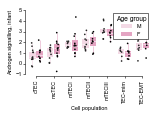

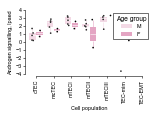

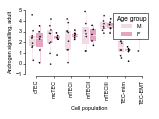

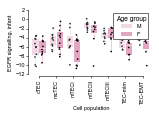

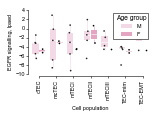

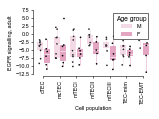

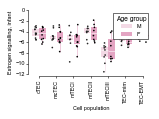

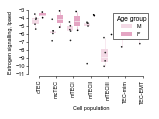

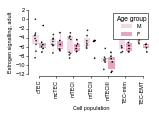

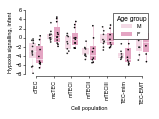

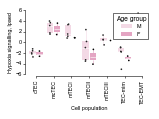

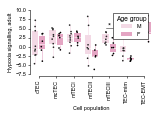

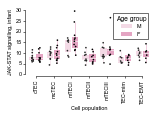

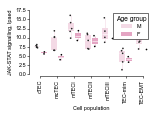

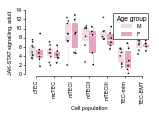

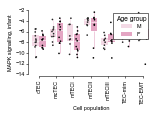

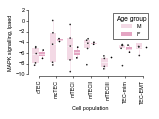

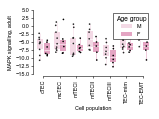

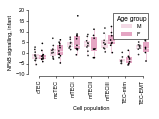

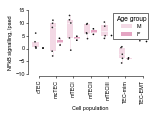

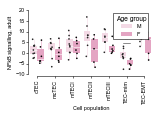

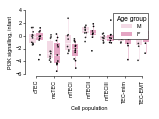

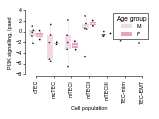

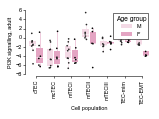

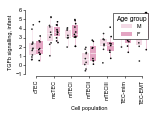

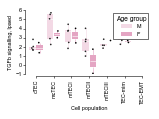

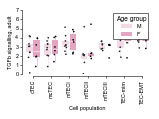

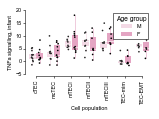

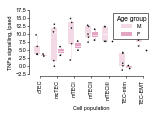

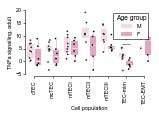

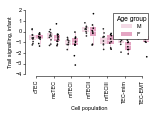

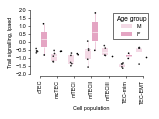

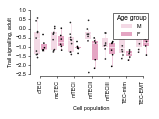

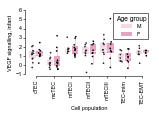

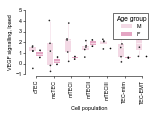

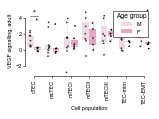

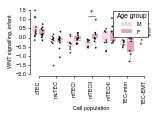

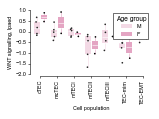

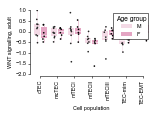

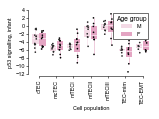

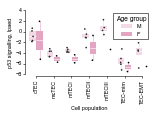

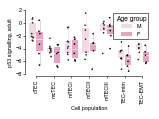

In [38]:
for path in progeny_paths:
    plot_grouped_boxplot(data = progeny2donor_freq_tec_inf, x = 'taa_l3', y = path, hue = 'sex', 
                      order = tec_lev3, 
                     hue_order = ['M', 'F'], 
                     x_label = 'Cell population', y_label = f'{path} signalling, infant', 
                     legend_title = 'Age group', add_stats = True, format_percent = False, 
                     figsize = (2.0, 1.5), remove_legend = False,
                     palette  = get_tint_palette(thyAgeing_colors['magenta']), 
                     save_stats = f'{results_path}/thyAgeing_TEC_taa_l3_{path}_sex_infant')
    plt.savefig(f'{plot_path}/thyAgeing_TEC_taa_l3_{path}_sex_infant_LM_style_boxplot_pink.pdf')
    plot_grouped_boxplot(data = progeny2donor_freq_tec_paed, x = 'taa_l3', y = path, hue = 'sex', 
                      order = tec_lev3, 
                     hue_order = ['M', 'F'], 
                     x_label = 'Cell population', y_label = f'{path} signalling, lpaed', 
                     legend_title = 'Age group', add_stats = True, format_percent = False, 
                     figsize = (2.0, 1.5), remove_legend = False,
                     palette  = get_tint_palette(thyAgeing_colors['magenta']), 
                     save_stats = f'{results_path}/thyAgeing_TEC_taa_l3_{path}_sex_lpaed')
    plt.savefig(f'{plot_path}/thyAgeing_TEC_taa_l3_{path}_sex_lpaed_LM_style_boxplot_pink.pdf')
    plot_grouped_boxplot(data = progeny2donor_freq_tec_adult, x = 'taa_l3', y = path, hue = 'sex', 
                      order = tec_lev3, 
                     hue_order = ['M', 'F'], 
                     x_label = 'Cell population', y_label = f'{path} signalling, adult', 
                     legend_title = 'Age group', add_stats = True, format_percent = False, 
                     figsize = (2.0, 1.5), remove_legend = False,
                     palette  = get_tint_palette(thyAgeing_colors['magenta']), 
                     save_stats = f'{results_path}/thyAgeing_TEC_taa_l3_{path}_sex_adult')
    plt.savefig(f'{plot_path}/thyAgeing_TEC_taa_l3_{path}_sex_adult_LM_style_boxplot_pink.pdf')

    

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Androgen signalling'>

2025-11-17 13:50:47 | [INFO] maxp pruned
2025-11-17 13:50:47 | [INFO] LTSH dropped
2025-11-17 13:50:47 | [INFO] cmap pruned
2025-11-17 13:50:47 | [INFO] kern pruned
2025-11-17 13:50:47 | [INFO] post pruned
2025-11-17 13:50:47 | [INFO] PCLT dropped
2025-11-17 13:50:47 | [INFO] JSTF dropped
2025-11-17 13:50:47 | [INFO] DSIG dropped
2025-11-17 13:50:47 | [INFO] GSUB pruned
2025-11-17 13:50:47 | [INFO] glyf pruned
2025-11-17 13:50:47 | [INFO] Added gid0 to subset
2025-11-17 13:50:47 | [INFO] Added first four glyphs to subset
2025-11-17 13:50:47 | [INFO] Closing glyph list over 'GSUB': 32 glyphs before
2025-11-17 13:50:47 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'I', 'M', 'T', 'a', 'asterisk', 'c', 'd', 'e', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'zero']
2025-11-17 13:50:47 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 21, 23, 25, 36, 38, 40, 44, 48, 55, 68, 70, 71, 72, 74, 76, 79, 80, 81

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='EGFR signalling'>

2025-11-17 13:50:50 | [INFO] maxp pruned
2025-11-17 13:50:50 | [INFO] LTSH dropped
2025-11-17 13:50:50 | [INFO] cmap pruned
2025-11-17 13:50:50 | [INFO] kern pruned
2025-11-17 13:50:50 | [INFO] post pruned
2025-11-17 13:50:50 | [INFO] PCLT dropped
2025-11-17 13:50:50 | [INFO] JSTF dropped
2025-11-17 13:50:50 | [INFO] DSIG dropped
2025-11-17 13:50:50 | [INFO] GSUB pruned
2025-11-17 13:50:50 | [INFO] glyf pruned
2025-11-17 13:50:50 | [INFO] Added gid0 to subset
2025-11-17 13:50:50 | [INFO] Added first four glyphs to subset
2025-11-17 13:50:50 | [INFO] Closing glyph list over 'GSUB': 31 glyphs before
2025-11-17 13:50:50 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'G', 'I', 'M', 'R', 'T', 'a', 'asterisk', 'c', 'e', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 's', 'space', 't', 'u', 'zero']
2025-11-17 13:50:50 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 24, 38, 40, 41, 42, 44, 48, 53, 55, 68, 70, 72, 74, 76, 79, 80, 81, 82, 8

Performing Kruskal-Wallis and Dunn tests
No significant results found


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Estrogen signalling'>

2025-11-17 13:50:52 | [INFO] maxp pruned
2025-11-17 13:50:52 | [INFO] LTSH dropped
2025-11-17 13:50:52 | [INFO] cmap pruned
2025-11-17 13:50:52 | [INFO] kern pruned
2025-11-17 13:50:52 | [INFO] post pruned
2025-11-17 13:50:52 | [INFO] PCLT dropped
2025-11-17 13:50:52 | [INFO] JSTF dropped
2025-11-17 13:50:52 | [INFO] DSIG dropped
2025-11-17 13:50:52 | [INFO] GSUB pruned
2025-11-17 13:50:52 | [INFO] glyf pruned
2025-11-17 13:50:52 | [INFO] Added gid0 to subset
2025-11-17 13:50:52 | [INFO] Added first four glyphs to subset
2025-11-17 13:50:52 | [INFO] Closing glyph list over 'GSUB': 31 glyphs before
2025-11-17 13:50:52 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'I', 'M', 'T', 'a', 'c', 'e', 'eight', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'zero']
2025-11-17 13:50:52 | [INFO] Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 23, 25, 27, 38, 40, 44, 48, 55, 68, 70, 72, 74, 76, 79, 80, 81, 82, 83, 

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Hypoxia signalling'>

2025-11-17 13:50:55 | [INFO] maxp pruned
2025-11-17 13:50:55 | [INFO] LTSH dropped
2025-11-17 13:50:55 | [INFO] cmap pruned
2025-11-17 13:50:55 | [INFO] kern pruned
2025-11-17 13:50:55 | [INFO] post pruned
2025-11-17 13:50:55 | [INFO] PCLT dropped
2025-11-17 13:50:55 | [INFO] JSTF dropped
2025-11-17 13:50:55 | [INFO] DSIG dropped
2025-11-17 13:50:55 | [INFO] GSUB pruned
2025-11-17 13:50:55 | [INFO] glyf pruned
2025-11-17 13:50:55 | [INFO] Added gid0 to subset
2025-11-17 13:50:55 | [INFO] Added first four glyphs to subset
2025-11-17 13:50:55 | [INFO] Closing glyph list over 'GSUB': 31 glyphs before
2025-11-17 13:50:55 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'H', 'I', 'M', 'T', 'a', 'asterisk', 'c', 'e', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 's', 'space', 't', 'u', 'x', 'y', 'zero']
2025-11-17 13:50:55 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 24, 38, 40, 43, 44, 48, 55, 68, 70, 72, 74, 76, 79, 80, 81, 82, 83, 86, 8

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='JAK-STAT signalling'>

2025-11-17 13:50:58 | [INFO] maxp pruned
2025-11-17 13:50:58 | [INFO] LTSH dropped
2025-11-17 13:50:58 | [INFO] cmap pruned
2025-11-17 13:50:58 | [INFO] kern pruned
2025-11-17 13:50:58 | [INFO] post pruned
2025-11-17 13:50:58 | [INFO] PCLT dropped
2025-11-17 13:50:58 | [INFO] JSTF dropped
2025-11-17 13:50:58 | [INFO] DSIG dropped
2025-11-17 13:50:58 | [INFO] GSUB pruned
2025-11-17 13:50:58 | [INFO] glyf pruned
2025-11-17 13:50:58 | [INFO] Added gid0 to subset
2025-11-17 13:50:58 | [INFO] Added first four glyphs to subset
2025-11-17 13:50:58 | [INFO] Closing glyph list over 'GSUB': 33 glyphs before
2025-11-17 13:50:58 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'I', 'J', 'K', 'M', 'S', 'T', 'a', 'asterisk', 'c', 'e', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 's', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-17 13:50:58 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 21, 22, 24, 36, 38, 40, 44, 45, 46, 48, 54, 55, 68, 70, 72, 7

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='MAPK signalling'>

2025-11-17 13:51:00 | [INFO] maxp pruned
2025-11-17 13:51:00 | [INFO] LTSH dropped
2025-11-17 13:51:00 | [INFO] cmap pruned
2025-11-17 13:51:00 | [INFO] kern pruned
2025-11-17 13:51:00 | [INFO] post pruned
2025-11-17 13:51:00 | [INFO] PCLT dropped
2025-11-17 13:51:00 | [INFO] JSTF dropped
2025-11-17 13:51:00 | [INFO] DSIG dropped
2025-11-17 13:51:00 | [INFO] GSUB pruned
2025-11-17 13:51:00 | [INFO] glyf pruned
2025-11-17 13:51:00 | [INFO] Added gid0 to subset
2025-11-17 13:51:00 | [INFO] Added first four glyphs to subset
2025-11-17 13:51:00 | [INFO] Closing glyph list over 'GSUB': 33 glyphs before
2025-11-17 13:51:00 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'I', 'K', 'M', 'P', 'T', 'a', 'c', 'e', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 's', 'seven', 'space', 't', 'two', 'u', 'zero']
2025-11-17 13:51:00 | [INFO] Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 24, 26, 36, 38, 40, 44, 46, 48, 51, 55, 68, 70, 72, 74,

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='NFkB signalling'>

2025-11-17 13:51:02 | [INFO] maxp pruned
2025-11-17 13:51:02 | [INFO] LTSH dropped
2025-11-17 13:51:02 | [INFO] cmap pruned
2025-11-17 13:51:02 | [INFO] kern pruned
2025-11-17 13:51:02 | [INFO] post pruned
2025-11-17 13:51:02 | [INFO] PCLT dropped
2025-11-17 13:51:02 | [INFO] JSTF dropped
2025-11-17 13:51:02 | [INFO] DSIG dropped
2025-11-17 13:51:02 | [INFO] GSUB pruned
2025-11-17 13:51:02 | [INFO] glyf pruned
2025-11-17 13:51:02 | [INFO] Added gid0 to subset
2025-11-17 13:51:02 | [INFO] Added first four glyphs to subset
2025-11-17 13:51:02 | [INFO] Closing glyph list over 'GSUB': 33 glyphs before
2025-11-17 13:51:02 | [INFO] Glyph names: ['.notdef', '.null', 'B', 'C', 'E', 'F', 'I', 'M', 'N', 'T', 'a', 'asterisk', 'c', 'e', 'five', 'g', 'hyphen', 'i', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 's', 'space', 't', 'two', 'u', 'zero']
2025-11-17 13:51:02 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 21, 24, 37, 38, 40, 41, 44, 48, 49, 55, 68, 70, 72, 74, 76, 7

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='PI3K signalling'>

2025-11-17 13:51:04 | [INFO] maxp pruned
2025-11-17 13:51:04 | [INFO] LTSH dropped
2025-11-17 13:51:04 | [INFO] cmap pruned
2025-11-17 13:51:04 | [INFO] kern pruned
2025-11-17 13:51:04 | [INFO] post pruned
2025-11-17 13:51:04 | [INFO] PCLT dropped
2025-11-17 13:51:04 | [INFO] JSTF dropped
2025-11-17 13:51:04 | [INFO] DSIG dropped
2025-11-17 13:51:04 | [INFO] GSUB pruned
2025-11-17 13:51:04 | [INFO] glyf pruned
2025-11-17 13:51:04 | [INFO] Added gid0 to subset
2025-11-17 13:51:04 | [INFO] Added first four glyphs to subset
2025-11-17 13:51:04 | [INFO] Closing glyph list over 'GSUB': 33 glyphs before
2025-11-17 13:51:04 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'I', 'K', 'M', 'P', 'T', 'a', 'asterisk', 'c', 'e', 'eight', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'p', 's', 'six', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-17 13:51:04 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 21, 22, 23, 25, 27, 38, 40, 44, 46, 48, 51, 55, 68, 70, 7

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='TGFb signalling'>

2025-11-17 13:51:06 | [INFO] maxp pruned
2025-11-17 13:51:06 | [INFO] LTSH dropped
2025-11-17 13:51:06 | [INFO] cmap pruned
2025-11-17 13:51:06 | [INFO] kern pruned
2025-11-17 13:51:06 | [INFO] post pruned
2025-11-17 13:51:06 | [INFO] PCLT dropped
2025-11-17 13:51:06 | [INFO] JSTF dropped
2025-11-17 13:51:06 | [INFO] DSIG dropped
2025-11-17 13:51:06 | [INFO] GSUB pruned
2025-11-17 13:51:06 | [INFO] glyf pruned
2025-11-17 13:51:06 | [INFO] Added gid0 to subset
2025-11-17 13:51:06 | [INFO] Added first four glyphs to subset
2025-11-17 13:51:06 | [INFO] Closing glyph list over 'GSUB': 35 glyphs before
2025-11-17 13:51:06 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'G', 'I', 'M', 'T', 'a', 'asterisk', 'b', 'c', 'e', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-17 13:51:06 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 21, 22, 23, 24, 25, 26, 38, 40, 41, 42, 44

Performing Kruskal-Wallis and Dunn tests
No significant results found


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='TNFa signalling'>

2025-11-17 13:51:07 | [INFO] maxp pruned
2025-11-17 13:51:07 | [INFO] LTSH dropped
2025-11-17 13:51:07 | [INFO] cmap pruned
2025-11-17 13:51:07 | [INFO] kern pruned
2025-11-17 13:51:07 | [INFO] post pruned
2025-11-17 13:51:07 | [INFO] PCLT dropped
2025-11-17 13:51:07 | [INFO] JSTF dropped
2025-11-17 13:51:07 | [INFO] DSIG dropped
2025-11-17 13:51:07 | [INFO] GSUB pruned
2025-11-17 13:51:07 | [INFO] glyf pruned
2025-11-17 13:51:07 | [INFO] Added gid0 to subset
2025-11-17 13:51:07 | [INFO] Added first four glyphs to subset
2025-11-17 13:51:07 | [INFO] Closing glyph list over 'GSUB': 30 glyphs before
2025-11-17 13:51:07 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'I', 'M', 'N', 'T', 'a', 'c', 'e', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 's', 'space', 't', 'two', 'u', 'zero']
2025-11-17 13:51:07 | [INFO] Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 24, 38, 40, 41, 44, 48, 49, 55, 68, 70, 72, 74, 76, 79, 80, 81, 82, 83, 86, 87, 88,

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Trail signalling'>

2025-11-17 13:51:09 | [INFO] maxp pruned
2025-11-17 13:51:09 | [INFO] LTSH dropped
2025-11-17 13:51:09 | [INFO] cmap pruned
2025-11-17 13:51:09 | [INFO] kern pruned
2025-11-17 13:51:09 | [INFO] post pruned
2025-11-17 13:51:09 | [INFO] PCLT dropped
2025-11-17 13:51:09 | [INFO] JSTF dropped
2025-11-17 13:51:09 | [INFO] DSIG dropped
2025-11-17 13:51:09 | [INFO] GSUB pruned
2025-11-17 13:51:09 | [INFO] glyf pruned
2025-11-17 13:51:09 | [INFO] Added gid0 to subset
2025-11-17 13:51:09 | [INFO] Added first four glyphs to subset
2025-11-17 13:51:09 | [INFO] Closing glyph list over 'GSUB': 31 glyphs before
2025-11-17 13:51:09 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'I', 'M', 'T', 'a', 'asterisk', 'c', 'e', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-17 13:51:09 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 21, 22, 23, 38, 40, 44, 48, 55, 68, 70, 72, 74, 76, 79, 80, 81, 82,

Performing Kruskal-Wallis and Dunn tests
No significant results found


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='VEGF signalling'>

2025-11-17 13:51:10 | [INFO] maxp pruned
2025-11-17 13:51:10 | [INFO] LTSH dropped
2025-11-17 13:51:10 | [INFO] cmap pruned
2025-11-17 13:51:10 | [INFO] kern pruned
2025-11-17 13:51:10 | [INFO] post pruned
2025-11-17 13:51:10 | [INFO] PCLT dropped
2025-11-17 13:51:10 | [INFO] JSTF dropped
2025-11-17 13:51:10 | [INFO] DSIG dropped
2025-11-17 13:51:10 | [INFO] GSUB pruned
2025-11-17 13:51:10 | [INFO] glyf pruned
2025-11-17 13:51:10 | [INFO] Added gid0 to subset
2025-11-17 13:51:10 | [INFO] Added first four glyphs to subset
2025-11-17 13:51:10 | [INFO] Closing glyph list over 'GSUB': 31 glyphs before
2025-11-17 13:51:10 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'G', 'I', 'M', 'T', 'V', 'a', 'c', 'e', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'p', 's', 'six', 'space', 't', 'two', 'u', 'zero']
2025-11-17 13:51:10 | [INFO] Glyph IDs:   [0, 1, 2, 3, 16, 19, 21, 23, 25, 38, 40, 41, 42, 44, 48, 55, 57, 68, 70, 72, 74, 76, 79, 80, 81, 82, 83, 86

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='WNT signalling'>

2025-11-17 13:51:12 | [INFO] maxp pruned
2025-11-17 13:51:12 | [INFO] LTSH dropped
2025-11-17 13:51:12 | [INFO] cmap pruned
2025-11-17 13:51:12 | [INFO] kern pruned
2025-11-17 13:51:12 | [INFO] post pruned
2025-11-17 13:51:12 | [INFO] PCLT dropped
2025-11-17 13:51:12 | [INFO] JSTF dropped
2025-11-17 13:51:12 | [INFO] DSIG dropped
2025-11-17 13:51:12 | [INFO] GSUB pruned
2025-11-17 13:51:12 | [INFO] glyf pruned
2025-11-17 13:51:12 | [INFO] Added gid0 to subset
2025-11-17 13:51:12 | [INFO] Added first four glyphs to subset
2025-11-17 13:51:12 | [INFO] Closing glyph list over 'GSUB': 30 glyphs before
2025-11-17 13:51:12 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'I', 'M', 'N', 'T', 'W', 'a', 'asterisk', 'c', 'e', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 's', 'space', 't', 'two', 'u', 'zero']
2025-11-17 13:51:12 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 20, 21, 38, 40, 44, 48, 49, 55, 58, 68, 70, 72, 74, 76, 79, 80, 81, 82, 83, 86, 87,

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='p53 signalling'>

2025-11-17 13:51:17 | [INFO] maxp pruned
2025-11-17 13:51:17 | [INFO] LTSH dropped
2025-11-17 13:51:17 | [INFO] cmap pruned
2025-11-17 13:51:17 | [INFO] kern pruned
2025-11-17 13:51:17 | [INFO] post pruned
2025-11-17 13:51:17 | [INFO] PCLT dropped
2025-11-17 13:51:17 | [INFO] JSTF dropped
2025-11-17 13:51:17 | [INFO] DSIG dropped
2025-11-17 13:51:17 | [INFO] GSUB pruned
2025-11-17 13:51:17 | [INFO] glyf pruned
2025-11-17 13:51:17 | [INFO] Added gid0 to subset
2025-11-17 13:51:17 | [INFO] Added first four glyphs to subset
2025-11-17 13:51:17 | [INFO] Closing glyph list over 'GSUB': 32 glyphs before
2025-11-17 13:51:17 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'I', 'M', 'T', 'a', 'c', 'e', 'eight', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 's', 'six', 'space', 't', 'three', 'two', 'u', 'zero']
2025-11-17 13:51:17 | [INFO] Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 23, 24, 25, 27, 38, 40, 44, 48, 55, 68, 70, 72, 74, 76, 

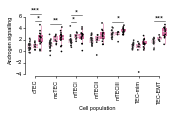

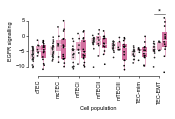

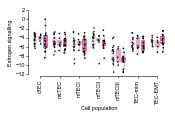

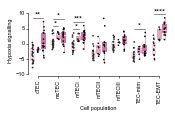

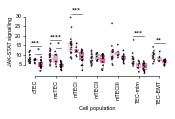

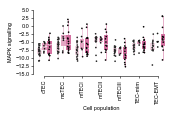

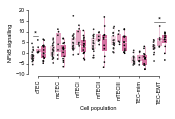

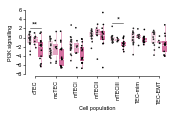

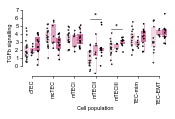

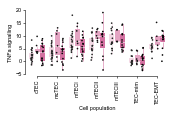

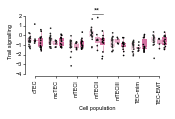

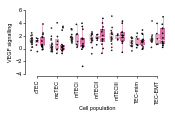

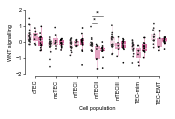

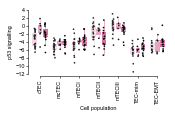

In [91]:
for path in progeny_paths:
    plot_grouped_boxplot(data = progeny2donor_freq_tec, x = 'taa_l3', y = path, hue = 'age_group', 
                      order = tec_lev3, 
                     hue_order = ['infant', 'paed', 'adult'], 
                     x_label = 'Cell population', y_label = f'{path} signalling', 
                     legend_title = 'Age group', add_stats = True, format_percent = False, 
                     figsize = (2.2, 1.5), remove_legend = True,
                     palette  = get_tint_palette(thyAgeing_colors['magenta']), 
                     save_stats = f'{results_path}/thyAgeing_TEC_taa_l3_{path}')
    plt.savefig(f'{plot_path}/thyAgeing_TEC_taa_l3_{path}_LM_style_boxplot_pink.pdf')
    

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Androgen signalling'>

2025-11-17 12:34:24 | [INFO] maxp pruned
2025-11-17 12:34:24 | [INFO] LTSH dropped
2025-11-17 12:34:24 | [INFO] cmap pruned
2025-11-17 12:34:24 | [INFO] kern pruned
2025-11-17 12:34:24 | [INFO] post pruned
2025-11-17 12:34:24 | [INFO] PCLT dropped
2025-11-17 12:34:24 | [INFO] JSTF dropped
2025-11-17 12:34:24 | [INFO] DSIG dropped
2025-11-17 12:34:24 | [INFO] GSUB pruned
2025-11-17 12:34:24 | [INFO] glyf pruned
2025-11-17 12:34:24 | [INFO] Added gid0 to subset
2025-11-17 12:34:24 | [INFO] Added first four glyphs to subset
2025-11-17 12:34:24 | [INFO] Closing glyph list over 'GSUB': 42 glyphs before
2025-11-17 12:34:24 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'P', 'S', 'T', 'a', 'asterisk', 'b', 'c', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-17 12:34:24 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 19, 21, 23,

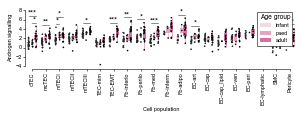

In [62]:
from plotting.utils import plot_grouped_boxplot,thyAgeing_colors,thyAgeing_greys,get_tint_palette

plot_grouped_boxplot(data = progeny2donor_freq, x = 'taa_l3', y = 'Androgen', hue = 'age_group', 
                      order = stroma_lev3, 
                     hue_order = ['infant', 'paed', 'adult'], 
                     x_label = 'Cell population', y_label = 'Androgen signalling', 
                     legend_title = 'Age group', add_stats = True, format_percent = False, 
                     figsize = (3.8, 1.5), remove_legend = False,
                     palette  = get_tint_palette(thyAgeing_colors['magenta']), 
                     save_stats = f'{results_path}/thyAgeing_stroma_taa_l3_Androgen')

plt.savefig(f'{plot_path}/thyAgeing_stroma_taa_l3_Androgen_LM_style_boxplot_pink.pdf')

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:130: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:156: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Androgen signalling'>

2025-11-17 12:35:44 | [INFO] maxp pruned
2025-11-17 12:35:44 | [INFO] LTSH dropped
2025-11-17 12:35:44 | [INFO] cmap pruned
2025-11-17 12:35:44 | [INFO] kern pruned
2025-11-17 12:35:44 | [INFO] post pruned
2025-11-17 12:35:44 | [INFO] PCLT dropped
2025-11-17 12:35:44 | [INFO] JSTF dropped
2025-11-17 12:35:44 | [INFO] DSIG dropped
2025-11-17 12:35:44 | [INFO] GSUB pruned
2025-11-17 12:35:44 | [INFO] glyf pruned
2025-11-17 12:35:44 | [INFO] Added gid0 to subset
2025-11-17 12:35:44 | [INFO] Added first four glyphs to subset
2025-11-17 12:35:44 | [INFO] Closing glyph list over 'GSUB': 43 glyphs before
2025-11-17 12:35:44 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'I', 'M', 'P', 'S', 'T', 'a', 'asterisk', 'b', 'c', 'd', 'e', 'f', 'five', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'space', 't', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2025-11-17 12:35:44 | [INFO] Glyph IDs:   [0, 1, 2, 3, 13, 16, 1

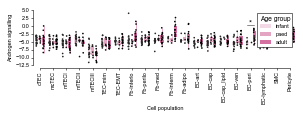

In [65]:
from plotting.utils import plot_grouped_boxplot,thyAgeing_colors,thyAgeing_greys,get_tint_palette

plot_grouped_boxplot(data = progeny2donor_freq, x = 'taa_l3', y = 'Estrogen', hue = 'age_group', 
                      order = stroma_lev3, 
                     hue_order = ['infant', 'paed', 'adult'], 
                     x_label = 'Cell population', y_label = 'Androgen signalling', 
                     legend_title = 'Age group', add_stats = True, format_percent = False, 
                     figsize = (3.8, 1.5), remove_legend = False,
                     palette  = get_tint_palette(thyAgeing_colors['magenta']), 
                     save_stats = f'{results_path}/thyAgeing_stroma_taa_l3_Estrogen')

plt.savefig(f'{plot_path}/thyAgeing_stroma_taa_l3_Estrogen_LM_style_boxplot_pink.pdf')

adata_ssample = sc.pp.subsample(adata, fraction=0.1, copy=True, random_state=42)

In [26]:
import gc 
gc.collect()

56

In [27]:
%%time
dc.mt.ulm(data=adata_tec, net=progeny)

CPU times: user 41.5 s, sys: 27.7 s, total: 1min 9s
Wall time: 56.4 s


In [70]:
import gc
gc.collect()

81844

In [71]:
adata_stroma.X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 472013189 stored elements and shape (236206, 35530)>

In [72]:
%%time
dc.mt.ulm(data=adata_stroma, net=progeny, bsize = 100000)

CPU times: user 2min, sys: 1min 24s, total: 3min 24s
Wall time: 2min 50s


In [73]:
gc.collect()

0

In [86]:
adata_stroma.obsm['score_ulm']

Androgen       EGFR  Estrogen    Hypoxia  \
TA13072046-ACACCCTTCAGCACAT  5.723330  18.889823  5.955359 -10.966470   
TA13072046-GCATGTACATGTAGTC  5.175547  21.911262  8.421347 -17.438901   
TA13072046-CCGGTAGTCAGCTTAG  4.994696  -2.571438  1.083196  -4.796849   
TA13072046-GGCCGATCAGTCGTGC  3.839148   9.709379  5.900349 -13.346672   
TA13072046-CGATCGGGTACGCTGC  4.363679  19.958759  9.543467 -17.348928   
...                               ...        ...       ...        ...   
TEC_96-ATACCTTCATCGATAC      3.717330  -3.300511 -2.716713   2.213081   
TEC_96-TTACGTTCAGTGTGCC     -0.116620 -11.529975 -3.130931   0.775991   
TEC_96-AACAAAGCATCGCTCT      2.029935  -3.459917 -4.102277   2.458165   
TEC_96-GCCGTGACAGAGAAAG      2.896088  -2.805517 -3.015564   1.039937   
TEC_96-CGTTGGGTCGTTCTGC      5.105977   1.130758 -2.929637   0.887501   

                              JAK-STAT       MAPK      NFkB       PI3K  \
TA13072046-ACACCCTTCAGCACAT   3.757708  22.858144  5.013867  26.037896   
TA13072046-GCATGTACATGTAGTC   3.165181  24.665978  0.752334  25.614358   
TA13072046-CCGGTAGTCAGCTTAG   6.509517  -0.768248 -3.110987   7.185795   
TA13072046-GGCCGATCAGTCGTGC   3.365303  13.706016 -5.858808  18.660939   
TA13072046-CGATCGGGTACGCTGC   1.700634  23.929991 -1.848557  25.397587   
...                                ...        ...       ...        ...   
TEC_96-ATACCTTCATCGATAC       7.151270  -5.426008  2.924329  -0.070100   
TEC_96-TTACGTTCAGTGTGCC      11.483057 -10.465651  1.472397  -5.874874   
TEC_96-AACAAAGCATCGCTCT       7.300092  -2.674169  0.420310  -1.924239   
TEC_96-GCCGTGACAGAGAAAG       3.755963  -4.104006  1.684583  -2.857185   
TEC_96-CGTTGGGTCGTTCTGC       2.953973  -0.620448  4.387192   0.524382   

                                  TGFb       TNFa     Trail       VEGF  \
TA13072046-ACACCCTTCAGCACAT  13.406216  12.293842 -2.492391  13.963123   
TA13072046-GCATGTACATGTAGTC  10.047301   8.300882 -1.995330  12.483522   
TA13072046-CCGGTAGTCAGCTTAG   6.224601   3.253764 -2.016782   4.144771   
TA13072046-GGCCGATCAGTCGTGC   8.825740   2.241913 -2.853604   8.691756   
TA13072046-CGATCGGGTACGCTGC   8.835089   5.569907 -2.537733  11.238416   
...                                ...        ...       ...        ...   
TEC_96-ATACCTTCATCGATAC       2.243664   4.473487  0.218369  -1.605439   
TEC_96-TTACGTTCAGTGTGCC       2.570439   2.500469 -0.349614   0.688553   
TEC_96-AACAAAGCATCGCTCT       0.823739   2.768955 -0.767490   2.261459   
TEC_96-GCCGTGACAGAGAAAG       6.399324   3.086153 -0.676194   0.670164   
TEC_96-CGTTGGGTCGTTCTGC       2.805232   5.745070  0.258463   0.668363   

                                  WNT        p53  
TA13072046-ACACCCTTCAGCACAT -0.517162 -19.953788  
TA13072046-GCATGTACATGTAGTC -0.193564 -22.424775  
TA13072046-CCGGTAGTCAGCTTAG -0.020551 -16.535000  
TA13072046-GGCCGATCAGTCGTGC  0.503727 -24.103484  
TA13072046-CGATCGGGTACGCTGC -0.023185 -23.417157  
...                               ...        ...  
TEC_96-ATACCTTCATCGATAC     -0.997095  -1.617141  
TEC_96-TTACGTTCAGTGTGCC      0.252718  -4.265972  
TEC_96-AACAAAGCATCGCTCT      0.122480  -5.460887  
TEC_96-GCCGTGACAGAGAAAG      0.430599  -5.612116  
TEC_96-CGTTGGGTCGTTCTGC      0.553714  -5.070572  

[236206 rows x 14 columns]

In [74]:
score_stroma = dc.pp.get_obsm(adata=adata_stroma, key="score_ulm")

In [78]:
score_stroma

AnnData object with n_obs × n_vars = 236206 × 14
    obs: 'barcode', 'sample', 'library', 'index', 'library_tcr_ab', 'library_tcr_gd', 'library_bcr', 'path_raw_gex', 'starsolo_version', 'path_cellbender_gex', 'path_cellranger_arc', 'donor', 'chemistry_simple', 'chemistry_detail', 'chemistry_orig', 'origin_institute', 'research_no', 'study', 'sort', 'sort_type', 'in_HTSA', 'public_data', 'type', 'cite', 'health_status', 'age_group', 'age_group2', 'age', 'age_num', 'age_unit', 'age_cont', 'sex', 'age_months', 'path_tcr_ab', 'path_tcr_gd', 'path_bcr', 'comment', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'scrublet_score', 'predicted_doublet', 'anno_status', 'qc_status', 'taa_l0', 'taa_l1', 'taa_l2', 'taa_l2_v2', 'taa_l3', 'taa_l3_v2', 'taa_l4', 'taa_l5'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'chemistry_simple_colors', 'donor_colors', 'hvg', 'neighbors', 'sex_colors', 'umap', 'log1p'
    obsm: 'X_scVI', 'X_umap', 'score_ulm', 'padj_ulm'

In [30]:
score_tecs = dc.pp.get_obsm(adata=adata_tec, key="score_ulm")

In [38]:
sc.settings.set_figure_params(dpi=100)

In [43]:
tecs_lev4 = get_ct_levels(level='taa_l4', taa_l1=['TEC'])

Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx


In [75]:
stroma_lev3 = get_ct_levels(level='taa_l3', taa_l1=['TEC','Fb','EC','Mural'])

Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx


In [ ]:
from plotting.utils import thyAgeing_colors
from matplotlib import colors as mcolors
vmin, vmax, vcenter = -max_abs, score_tecs.X.max(), 0
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
cmap = sns.blend_palette([thyAgeing_colors['teal'], 'white', thyAgeing_colors['orange']], as_cmap=True)

In [44]:
tecs_lev4

['cTECIII',
 'cTECII',
 'cTECI',
 'mcTEC',
 'mTECI',
 'mTECII',
 'mTECIII',
 'mTECI-trans',
 'TEC-myo',
 'TEC-neuro',
 'TEC-cilliated',
 'TEC-iono',
 'TEC-tuft',
 'TEC-EMT']

In [64]:
score_tecs.obs['sex']

TA13072046-GGACGTCGTCTCTTAT    M
TA13072046-GAATGAATCGAGAGCA    M
TA13072046-CTGATAGAGAATCTCC    M
TA13072046-CTGGTCTTCCGAAGAG    M
TA13072046-TGAGAGGAGACAAAGG    M
                              ..
TEC_96-ACACTGAAGTAATACG        M
TEC_96-ATACCGATCATTGCCC        M
TEC_96-ATACCTTCATCGATAC        M
TEC_96-TTACGTTCAGTGTGCC        M
TEC_96-CGTTGGGTCGTTCTGC        M
Name: sex, Length: 89710, dtype: category
Categories (2, object): ['F', 'M']

In [95]:
adata_stroma.obsm['score_ulm']

Androgen       EGFR  Estrogen    Hypoxia  \
TA13072046-ACACCCTTCAGCACAT  5.723330  18.889823  5.955359 -10.966470   
TA13072046-GCATGTACATGTAGTC  5.175547  21.911262  8.421347 -17.438901   
TA13072046-CCGGTAGTCAGCTTAG  4.994696  -2.571438  1.083196  -4.796849   
TA13072046-GGCCGATCAGTCGTGC  3.839148   9.709379  5.900349 -13.346672   
TA13072046-CGATCGGGTACGCTGC  4.363679  19.958759  9.543467 -17.348928   
...                               ...        ...       ...        ...   
TEC_96-ATACCTTCATCGATAC      3.717330  -3.300511 -2.716713   2.213081   
TEC_96-TTACGTTCAGTGTGCC     -0.116620 -11.529975 -3.130931   0.775991   
TEC_96-AACAAAGCATCGCTCT      2.029935  -3.459917 -4.102277   2.458165   
TEC_96-GCCGTGACAGAGAAAG      2.896088  -2.805517 -3.015564   1.039937   
TEC_96-CGTTGGGTCGTTCTGC      5.105977   1.130758 -2.929637   0.887501   

                              JAK-STAT       MAPK      NFkB       PI3K  \
TA13072046-ACACCCTTCAGCACAT   3.757708  22.858144  5.013867  26.037896   
TA13072046-GCATGTACATGTAGTC   3.165181  24.665978  0.752334  25.614358   
TA13072046-CCGGTAGTCAGCTTAG   6.509517  -0.768248 -3.110987   7.185795   
TA13072046-GGCCGATCAGTCGTGC   3.365303  13.706016 -5.858808  18.660939   
TA13072046-CGATCGGGTACGCTGC   1.700634  23.929991 -1.848557  25.397587   
...                                ...        ...       ...        ...   
TEC_96-ATACCTTCATCGATAC       7.151270  -5.426008  2.924329  -0.070100   
TEC_96-TTACGTTCAGTGTGCC      11.483057 -10.465651  1.472397  -5.874874   
TEC_96-AACAAAGCATCGCTCT       7.300092  -2.674169  0.420310  -1.924239   
TEC_96-GCCGTGACAGAGAAAG       3.755963  -4.104006  1.684583  -2.857185   
TEC_96-CGTTGGGTCGTTCTGC       2.953973  -0.620448  4.387192   0.524382   

                                  TGFb       TNFa     Trail       VEGF  \
TA13072046-ACACCCTTCAGCACAT  13.406216  12.293842 -2.492391  13.963123   
TA13072046-GCATGTACATGTAGTC  10.047301   8.300882 -1.995330  12.483522   
TA13072046-CCGGTAGTCAGCTTAG   6.224601   3.253764 -2.016782   4.144771   
TA13072046-GGCCGATCAGTCGTGC   8.825740   2.241913 -2.853604   8.691756   
TA13072046-CGATCGGGTACGCTGC   8.835089   5.569907 -2.537733  11.238416   
...                                ...        ...       ...        ...   
TEC_96-ATACCTTCATCGATAC       2.243664   4.473487  0.218369  -1.605439   
TEC_96-TTACGTTCAGTGTGCC       2.570439   2.500469 -0.349614   0.688553   
TEC_96-AACAAAGCATCGCTCT       0.823739   2.768955 -0.767490   2.261459   
TEC_96-GCCGTGACAGAGAAAG       6.399324   3.086153 -0.676194   0.670164   
TEC_96-CGTTGGGTCGTTCTGC       2.805232   5.745070  0.258463   0.668363   

                                  WNT        p53  
TA13072046-ACACCCTTCAGCACAT -0.517162 -19.953788  
TA13072046-GCATGTACATGTAGTC -0.193564 -22.424775  
TA13072046-CCGGTAGTCAGCTTAG -0.020551 -16.535000  
TA13072046-GGCCGATCAGTCGTGC  0.503727 -24.103484  
TA13072046-CGATCGGGTACGCTGC -0.023185 -23.417157  
...                               ...        ...  
TEC_96-ATACCTTCATCGATAC     -0.997095  -1.617141  
TEC_96-TTACGTTCAGTGTGCC      0.252718  -4.265972  
TEC_96-AACAAAGCATCGCTCT      0.122480  -5.460887  
TEC_96-GCCGTGACAGAGAAAG      0.430599  -5.612116  
TEC_96-CGTTGGGTCGTTCTGC      0.553714  -5.070572  

[236206 rows x 14 columns]

In [92]:
score_stroma.obs

barcode                    sample  \
TA13072046-ACACCCTTCAGCACAT  ACACCCTTCAGCACAT  A67-THY-0-SC-FACS-3_5GEX   
TA13072046-GCATGTACATGTAGTC  GCATGTACATGTAGTC  A67-THY-0-SC-FACS-3_5GEX   
TA13072046-CCGGTAGTCAGCTTAG  CCGGTAGTCAGCTTAG  A67-THY-0-SC-FACS-3_5GEX   
TA13072046-GGCCGATCAGTCGTGC  GGCCGATCAGTCGTGC  A67-THY-0-SC-FACS-3_5GEX   
TA13072046-CGATCGGGTACGCTGC  CGATCGGGTACGCTGC  A67-THY-0-SC-FACS-3_5GEX   
...                                       ...                       ...   
TEC_96-ATACCTTCATCGATAC      ATACCTTCATCGATAC                    TEC_96   
TEC_96-TTACGTTCAGTGTGCC      TTACGTTCAGTGTGCC                    TEC_96   
TEC_96-AACAAAGCATCGCTCT      AACAAAGCATCGCTCT                    TEC_96   
TEC_96-GCCGTGACAGAGAAAG      GCCGTGACAGAGAAAG                    TEC_96   
TEC_96-CGTTGGGTCGTTCTGC      CGTTGGGTCGTTCTGC                    TEC_96   

                                library       index library_tcr_ab  \
TA13072046-ACACCCTTCAGCACAT  TA13072046  TA13072046            NaN   
TA13072046-GCATGTACATGTAGTC  TA13072046  TA13072046            NaN   
TA13072046-CCGGTAGTCAGCTTAG  TA13072046  TA13072046            NaN   
TA13072046-GGCCGATCAGTCGTGC  TA13072046  TA13072046            NaN   
TA13072046-CGATCGGGTACGCTGC  TA13072046  TA13072046            NaN   
...                                 ...         ...            ...   
TEC_96-ATACCTTCATCGATAC       TEC_95_96      TEC_96            NaN   
TEC_96-TTACGTTCAGTGTGCC       TEC_95_96      TEC_96            NaN   
TEC_96-AACAAAGCATCGCTCT       TEC_95_96      TEC_96            NaN   
TEC_96-GCCGTGACAGAGAAAG       TEC_95_96      TEC_96            NaN   
TEC_96-CGTTGGGTCGTTCTGC       TEC_95_96      TEC_96            NaN   

                            library_tcr_gd library_bcr  \
TA13072046-ACACCCTTCAGCACAT            NaN         NaN   
TA13072046-GCATGTACATGTAGTC            NaN         NaN   
TA13072046-CCGGTAGTCAGCTTAG            NaN         NaN   
TA13072046-GGCCGATCAGTCGTGC            NaN         NaN   
TA13072046-CGATCGGGTACGCTGC            NaN         NaN   
...                                    ...         ...   
TEC_96-ATACCTTCATCGATAC                NaN         NaN   
TEC_96-TTACGTTCAGTGTGCC                NaN         NaN   
TEC_96-AACAAAGCATCGCTCT                NaN         NaN   
TEC_96-GCCGTGACAGAGAAAG                NaN         NaN   
TEC_96-CGTTGGGTCGTTCTGC                NaN         NaN   

                                                                  path_raw_gex  \
TA13072046-ACACCCTTCAGCACAT  /lustre/scratch126/cellgen/team205/vk8/irods_d...   
TA13072046-GCATGTACATGTAGTC  /lustre/scratch126/cellgen/team205/vk8/irods_d...   
TA13072046-CCGGTAGTCAGCTTAG  /lustre/scratch126/cellgen/team205/vk8/irods_d...   
TA13072046-GGCCGATCAGTCGTGC  /lustre/scratch126/cellgen/team205/vk8/irods_d...   
TA13072046-CGATCGGGTACGCTGC  /lustre/scratch126/cellgen/team205/vk8/irods_d...   
...                                                                        ...   
TEC_96-ATACCTTCATCGATAC      /lustre/scratch126/cellgen/team205/lm25/raw_da...   
TEC_96-TTACGTTCAGTGTGCC      /lustre/scratch126/cellgen/team205/lm25/raw_da...   
TEC_96-AACAAAGCATCGCTCT      /lustre/scratch126/cellgen/team205/lm25/raw_da...   
TEC_96-GCCGTGACAGAGAAAG      /lustre/scratch126/cellgen/team205/lm25/raw_da...   
TEC_96-CGTTGGGTCGTTCTGC      /lustre/scratch126/cellgen/team205/lm25/raw_da...   

                            starsolo_version  \
TA13072046-ACACCCTTCAGCACAT           2.7.4a   
TA13072046-GCATGTACATGTAGTC           2.7.4a   
TA13072046-CCGGTAGTCAGCTTAG           2.7.4a   
TA13072046-GGCCGATCAGTCGTGC           2.7.4a   
TA13072046-CGATCGGGTACGCTGC           2.7.4a   
...                                      ...   
TEC_96-ATACCTTCATCGATAC                  NaN   
TEC_96-TTACGTTCAGTGTGCC                  NaN   
TEC_96-AACAAAGCATCGCTCT                  NaN   
TEC_96-GCCGTGACAGAGAAAG                  NaN   
TEC_96-CGTTGGGTCGTTCTGC                  NaN   

                                     

In [130]:
path_stroma_infant = sc.pl.matrixplot(
    adata=score_stroma[(score_stroma.obs['age_group'] == 'infant')],
    var_names=score_stroma.var_names,
    groupby="taa_l3",
    categories_order = stroma_lev3,
    dendrogram=True,
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r", vcenter = 0, vmin = -10, vmax = 10, swap_axes = True, return_fig = True
)

/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'sample' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'library' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'index' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'library

/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'taa_l0' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'taa_l1' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'taa_l2' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'taa_l2_

In [131]:
path_stroma_adult = sc.pl.matrixplot(
    adata=score_stroma[(score_stroma.obs['age_group'] == 'adult')],
    var_names=score_stroma.var_names,
    groupby="taa_l3",
    categories_order = stroma_lev3,
    dendrogram=True,
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r", vcenter = 0, vmin = -10, vmax = 10, swap_axes = True, return_fig = True
)

/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'sample' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'library' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'index' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'library

... storing 'qc_status' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'taa_l0' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'taa_l1' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'taa_l2' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as act

In [135]:
import math

In [146]:
path_stroma_dif = np.log2(path_stroma_adult.values_df)-np.log2(path_stroma_infant.values_df)

/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


In [157]:
path_stroma_dif = (path_stroma_adult.values_df-path_stroma_infant.values_df)

In [154]:
path_stroma_dif

Androgen       EGFR  Estrogen    Hypoxia  JAK-STAT      MAPK  \
taa_l3                                                                       
cTEC          0.855205  -0.228609  0.247092  -0.908938 -0.263225 -0.134980   
mcTEC         0.725899  -0.533028 -0.083208   0.197556 -0.514476 -0.501636   
mTECI         0.761317  -0.586876  0.084628  15.041700 -0.298024 -0.504472   
mTECII        0.341264  -0.110210  0.297100  -0.658022  0.204005  0.147587   
mTECIII       0.226143  -0.031177  0.265805   1.620053 -0.103823  0.074661   
TEC-mim       1.661102  -0.288808  0.320068  -0.663489 -0.341351 -0.193348   
TEC-EMT       1.386973  -2.113229 -0.558164  18.631178 -0.438531 -1.403472   
Fb-interlo    1.093694  -0.949251 -0.412356   0.134308  0.192888 -0.631859   
Fb-perilo     0.575551  -0.235705 -0.127616   0.207916  0.079584 -0.170314   
Fb-med        0.838778  -0.504537 -0.239081   0.421467 -0.200702 -0.239667   
Fb-interm     0.881102  -2.743133 -1.154132  -0.225781 -0.292461 -1.698028   
Fb-adipo      0.687997  -1.055733 -0.393056   0.147603  0.100613 -0.647331   
EC-art        0.250079  -0.930164 -0.115739   0.843318 -0.219244 -0.478858   
EC-cap        0.213462   0.170003 -0.026855   0.195876 -0.248130 -0.016454   
EC-cap_lipid  0.482567  -0.303349 -0.035778   0.436750  0.000430 -0.217255   
EC-ven        0.148339  -0.833468 -0.171790   0.040571 -0.228611 -0.610487   
EC-peri       0.541644 -11.099725 -0.767506  -0.290912 -0.339470 -3.347508   
EC-lymphatic  0.450874  -0.637229 -0.089687   0.202601 -0.165586 -0.586237   
SMC           2.834410  -0.860736 -0.054781   0.444857 -0.397350 -0.265579   
Pericyte      1.654346  -1.046702 -0.301289   0.295717 -0.204428 -0.449627   

                  NFkB      PI3K      TGFb       TNFa      Trail       VEGF  \
taa_l3                                                                        
cTEC          2.096919 -8.438527  0.176354   0.203933   0.026372   0.079296   
mcTEC        -0.121633  0.203195 -0.300069  -0.100784  -0.130068   5.551884   
mTECI         0.240904  0.750461  0.112074   0.114348   0.115816   0.538840   
mTECII        0.529986 -0.269051  1.003258   0.376432  25.684990   0.281027   
mTECIII       0.108623  5.224859  0.177795   0.184036   0.665376   0.295764   
TEC-mim      -0.578004 -2.956625  0.483763 -70.003597   0.160321   1.476784   
TEC-EMT       2.010973 -3.451856 -0.066228   0.799837   0.190640   1.985670   
Fb-interlo    6.333806 -1.197973 -0.174893   1.587019   0.279198  -4.863692   
Fb-perilo     1.806168  0.235698 -0.472950   0.512435  -0.154407  -1.211684   
Fb-med        0.678884  0.086117 -0.351665   0.338404  -0.473552  -9.117392   
Fb-interm     0.843563 -3.077921 -0.212914   0.522350  -0.551418  10.937266   
Fb-adipo      3.820937 -0.806201 -0.332742   0.917249  -0.465290  -2.961896   
EC-art        0.245252 -2.154751 -0.021290   0.179088   0.294476   0.199996   
EC-cap       -0.228816  1.177701 -0.329842  -0.109253   0.192772   0.052506   
EC-cap_lipid  0.884960  0.113797 -0.224078   0.332040   2.897767   0.600865   
EC-ven       -0.146490 -0.659660 -0.212127  -0.081352   0.462581   0.349271   
EC-peri       0.116428  0.883509 -0.294226   0.111780  -0.338563   0.837490   
EC-lymphatic  1.327318 -0.752108 -0.075807   0.352264   0.451108   4.130823   
SMC           0.729581  6.686672  0.033168   0.327024   2.976568  12.491394   
Pericyte      0.426693 -1.013259 -0.145249   0.278427  -5.842556   4.737387   

                    WNT       p53  
taa_l3                             
cTEC          -0.577362 -0.402264  
mcTEC          2.289937  0.049418  
mTECI         -3.758287 -0.222925  
mTECII         0.800987  0.130774  
mTECIII        0.933962 -0.497057  
TEC-mim        0.374405 -0.254739  
TEC-EMT        0.148404 -0.348227  
Fb-interlo    -0.536088 -0.111689  
Fb-perilo     -0.208913 -0.232350  
Fb-med        -0.706260 -0.136500  
Fb-interm      0.082256  0.061426  
Fb-adipo       0.543708 -0.074883  
EC-art        -0.318415 -0.181508  
EC-cap         1.7

<Axes: ylabel='taa_l3'>

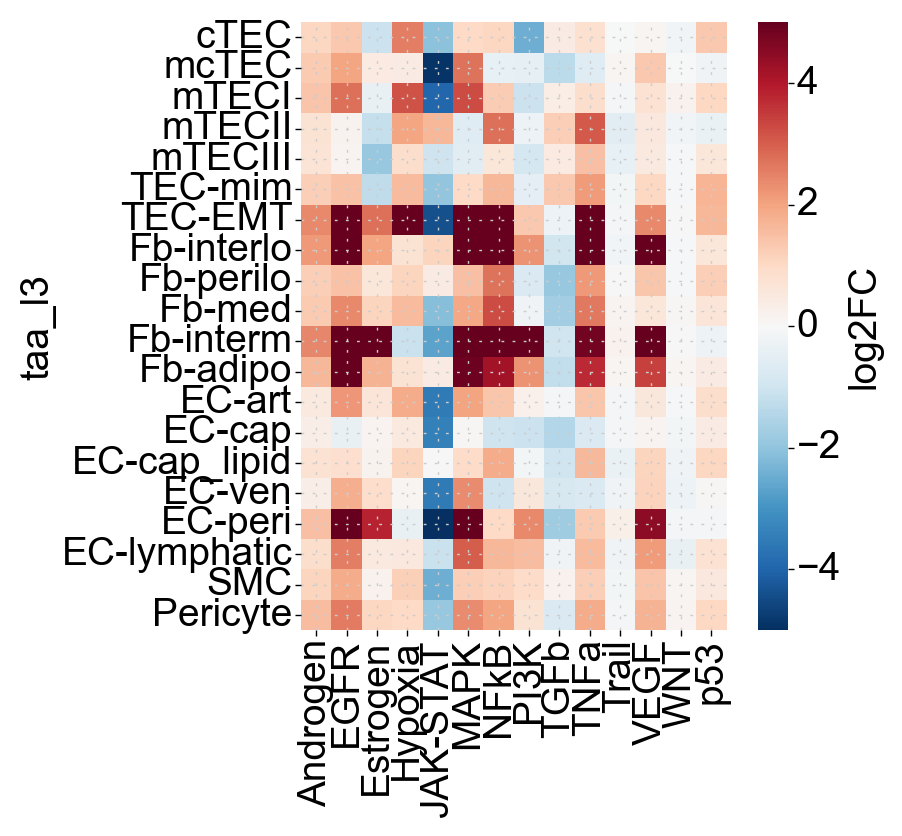

In [158]:
sns.heatmap(
        path_stroma_dif,
        center=0, vmax = 5, vmin = -5, cmap="RdBu_r",
        linewidths=0, 
        square = True, 
    xticklabels=True, 
    yticklabels=True,
        annot_kws={'size': 14, 'color': 'black'},
        cbar_kws={'label': 'log2FC'}, 
        )

<Axes: ylabel='taa_l3'>

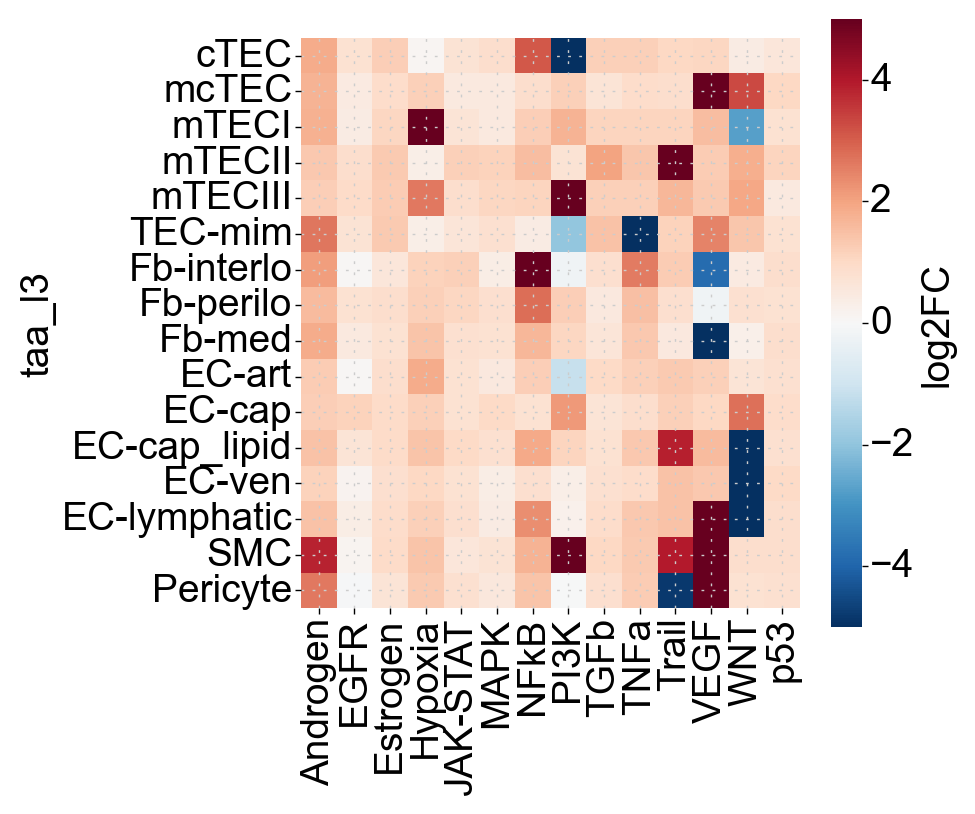

In [128]:
sns.heatmap(
        path_stroma_dif[~path_stroma_dif.index.isin(['TEC-EMT', 'Fb-interm', 'EC-peri', 'Fb-adipo'])],
        center=0, vmax = 5, vmin = -5, cmap="RdBu_r",
        linewidths=0, 
        square = True,
    xticklabels=True, 
    yticklabels=True,
        annot_kws={'size': 14, 'color': 'black'},
        cbar_kws={'label': 'log2FC'}, 
        )

<Axes: ylabel='taa_l3'>

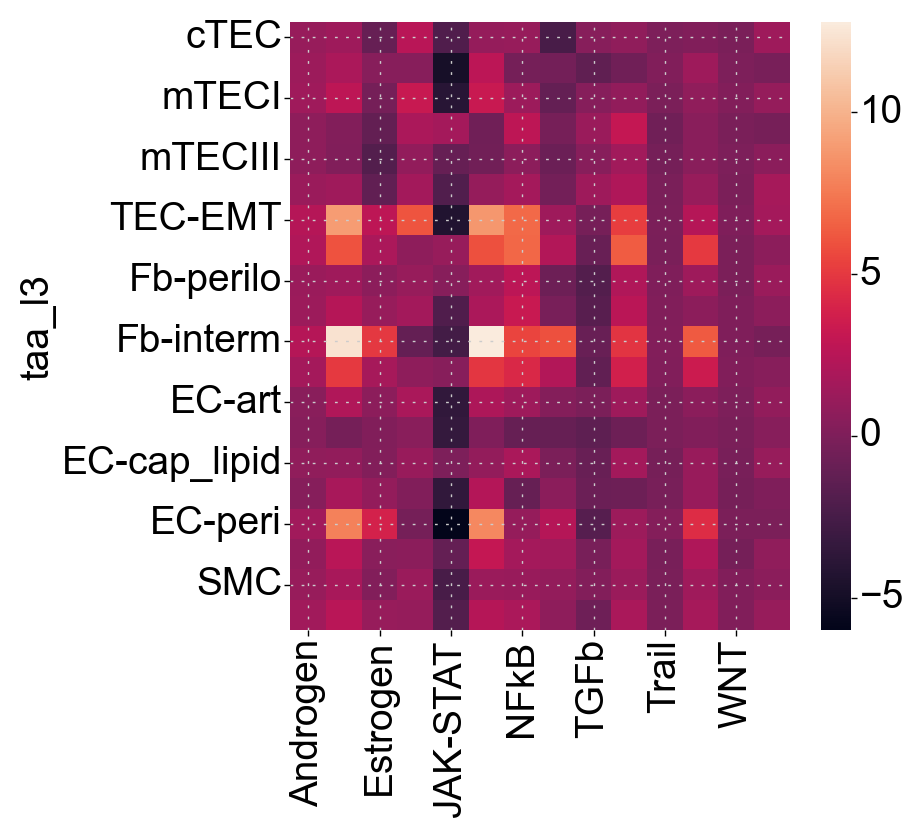

In [106]:
sns.heatmap(path_stroma_adult.values_df-path_stroma_infant.values_df)

In [102]:
path_stroma_infant.values_df

Androgen      EGFR  Estrogen   Hypoxia   JAK-STAT      MAPK  \
taa_l3                                                                      
cTEC          1.269074 -5.889619 -4.297982 -2.814246   7.849250 -7.365112   
mcTEC         1.784327 -3.681263 -5.413451  2.134851   9.514447 -5.392074   
mTECI         1.855720 -4.698467 -4.555596  0.212908  13.298318 -6.456001   
mTECII        2.144342 -1.694767 -3.995141 -2.973778   8.219572 -4.048081   
mTECIII       3.081613 -3.763592 -7.190468  0.544371   9.865236 -7.379620   
TEC-mim       0.730215 -5.030979 -4.017641 -2.383457   5.786783 -5.219180   
TEC-EMT       1.740343 -4.274392 -4.961006  0.327539   9.984946 -6.246618   
Fb-interlo    1.999813 -6.306014 -4.824587  5.495212   5.735787 -9.362229   
Fb-perilo     2.104884 -6.149715 -4.777942  5.340644   5.366404 -8.896132   
Fb-med        1.547151 -4.779879 -4.625212  3.781714  10.515684 -8.094024   
Fb-interm     2.756128 -4.481740 -4.331308  4.878655   9.178656 -7.525863   
Fb-adipo      2.414969 -4.802542 -4.425348  4.942528   4.262869 -7.563477   
EC-art        1.957764 -2.353768 -5.533048  2.198332  16.080353 -4.187910   
EC-cap        1.645263 -2.092964 -5.077777  2.509557  13.778335 -3.529210   
EC-cap_lipid  1.581716 -2.799896 -5.305841  2.557808   9.644491 -4.371881   
EC-ven        2.297534 -2.166558 -5.319360  2.183364  15.533247 -3.852503   
EC-peri       2.782259 -0.703716 -4.999688  1.293013  17.682413 -2.422447   
EC-lymphatic  1.908596 -4.009705 -5.568004  2.638482   6.617974 -5.162349   
SMC           0.392409 -2.142810 -4.030750  2.697340   6.137573 -4.697049   
Pericyte      0.937066 -2.463424 -3.617071  3.318865   9.274262 -5.258801   

                  NFkB      PI3K      TGFb       TNFa     Trail      VEGF  \
taa_l3                                                                      
cTEC          0.519761  0.290215  2.435192   3.955306 -0.783910  1.393298   
mcTEC         3.461406 -2.246400  4.496828   6.080768 -0.886043  0.240987   
mTECI         5.296532 -1.456137  3.147338   7.713830 -0.819784  1.436411   
mTECII        5.195553  1.142069  1.221159   8.178968 -0.022678  1.820592   
mTECIII       5.699140 -0.164790  2.537600   8.128447 -0.606938  1.688547   
TEC-mim      -2.898538  0.162170  2.795823  -0.030519 -0.931877  0.710163   
TEC-EMT       3.401929 -0.393980  4.252443   6.497217 -0.544341  1.206679   
Fb-interlo    1.071333 -1.886716  5.546309   4.026931 -0.564414 -1.039137   
Fb-perilo     1.502179 -3.195065  4.009266   4.225470 -0.106552 -1.133540   
Fb-med        4.811825 -2.622275  4.967415   7.821481 -0.250400 -0.067810   
Fb-interm     6.519013 -1.915602  4.643881   9.243258 -0.403241  0.574344   
Fb-adipo      1.098801 -2.768032  3.740745   4.047725 -0.230227 -1.160181   
EC-art        5.685899 -0.110559  4.847139   7.726360 -0.380740  2.882509   
EC-cap        4.562796 -0.911377  4.400722   6.716528 -0.449823  2.639516   
EC-cap_lipid  2.105901 -1.041518  4.424997   4.886556 -0.109614  1.862307   
EC-ven        7.124043 -0.846115  3.875760   9.349009 -0.451182  3.252537   
EC-peri       8.513638  2.731143  6.041832  11.579483 -0.897099  5.321974   
EC-lymphatic  1.246991 -2.057616  2.950914   4.501827 -0.469637  0.516455   
SMC           1.561586  0.141146  6.767747   3.772388 -0.046970  0.114714   
Pericyte      4.647984 -0.722734  4.852061   6.680107  0.013557  0.369204   

                   WNT       p53  
taa_l3                            
cTEC          0.312925 -3.350892  
mcTEC        -0.011996 -4.297721  
mTECI        -0.053757 -4.648219  
mTECII       -0.230328 -2.612425  
mTECIII      -0.046304 -1.193775  
TEC-mim      -0.167150 -6.720630  
TEC-EMT       0.166633 -4.796241  
Fb-interlo    0.121153 -5.414011  
Fb-perilo     0.324693 -5.378261  
Fb-med       -0.102104 -4.614502  
Fb-interm     0.327198 -4.680696  
Fb-adipo      0.214213 -5.227870  
EC-art        0.155395 -4.866128  
EC-cap       -0.079693 -5.301150  
EC-cap_lipid  0.029566 -5.355940  
EC-ven        0.025749 -4.982

/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'sample' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'library' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'index' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'library

... storing 'qc_status' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'taa_l0' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'taa_l1' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'taa_l2' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as act

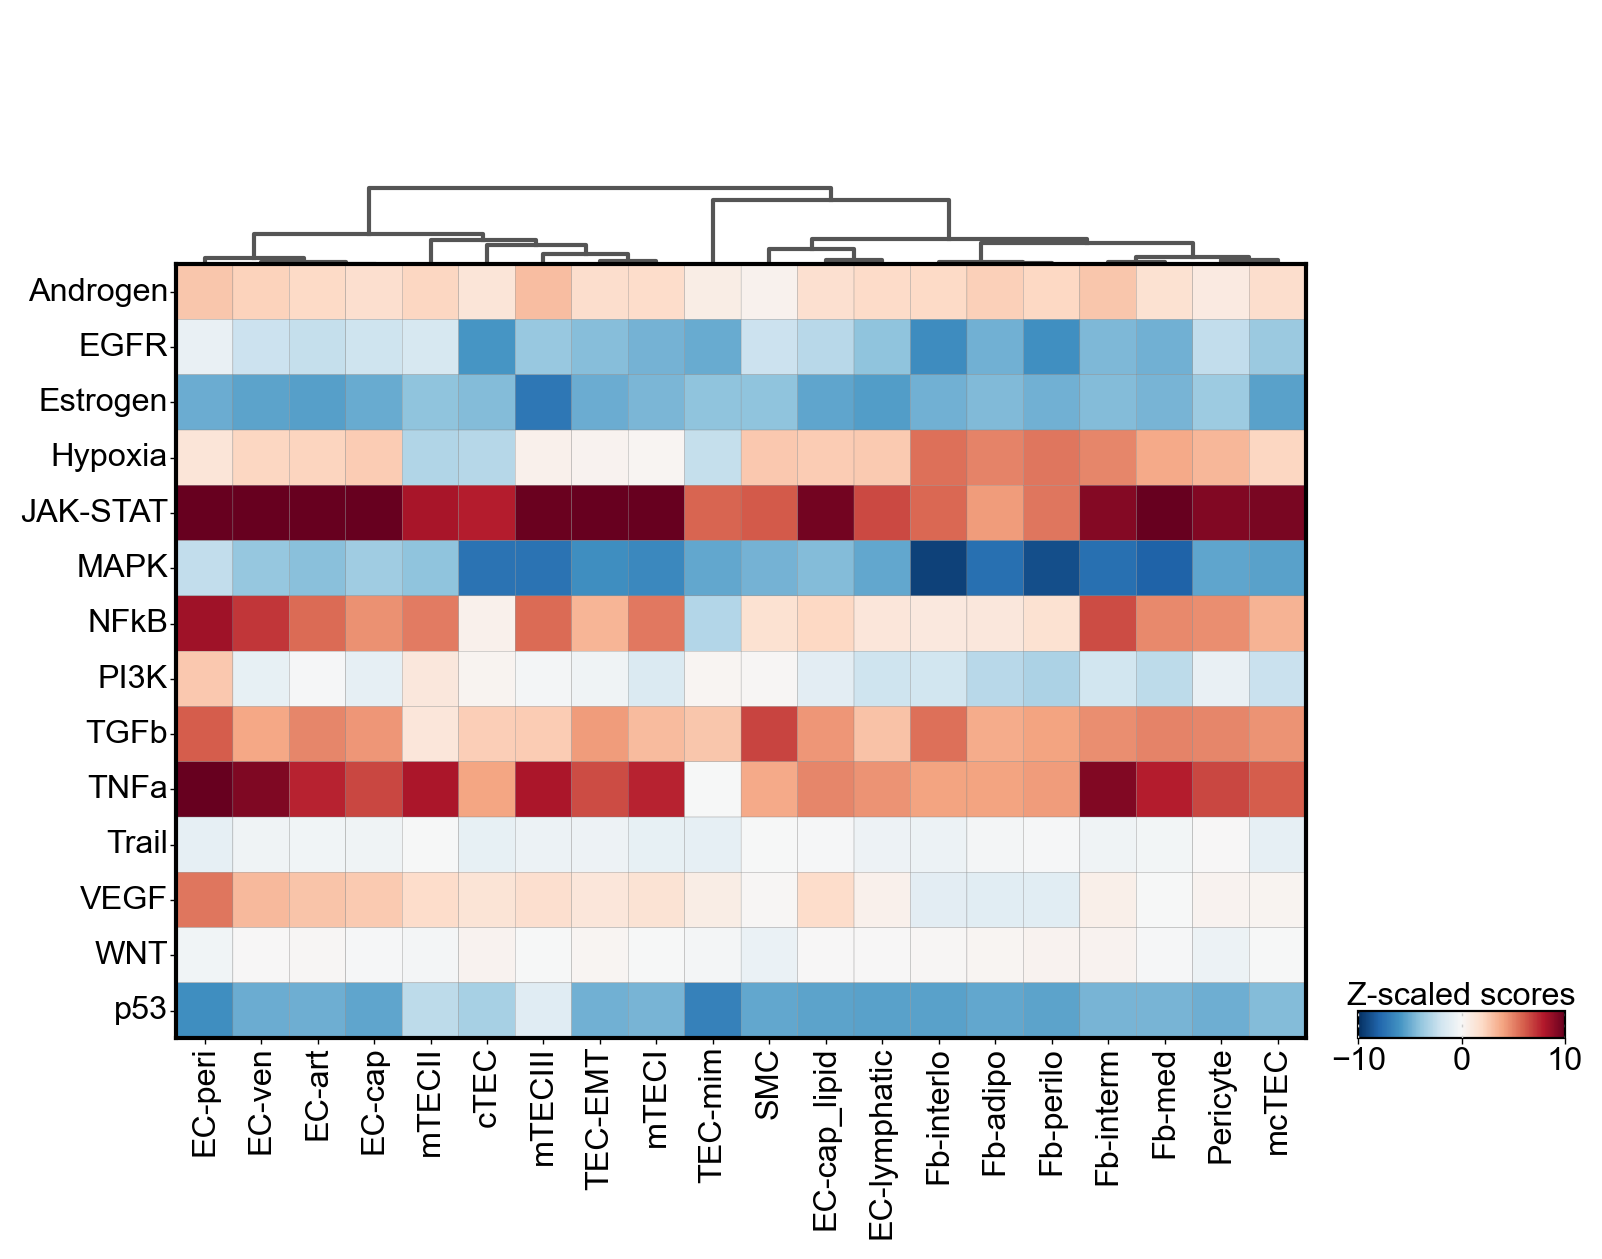

In [96]:
sc.pl.matrixplot(
    adata=score_stroma[(score_stroma.obs['age_group'] == 'infant')],
    var_names=score_stroma.var_names,
    groupby="taa_l3",
    categories_order = stroma_lev3,
    dendrogram=True,
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r", vcenter = 0, vmin = -10, vmax = 10, swap_axes = True
)

/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'sample' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'library' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'index' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'library

... storing 'qc_status' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'taa_l0' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'taa_l1' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'taa_l2' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as act

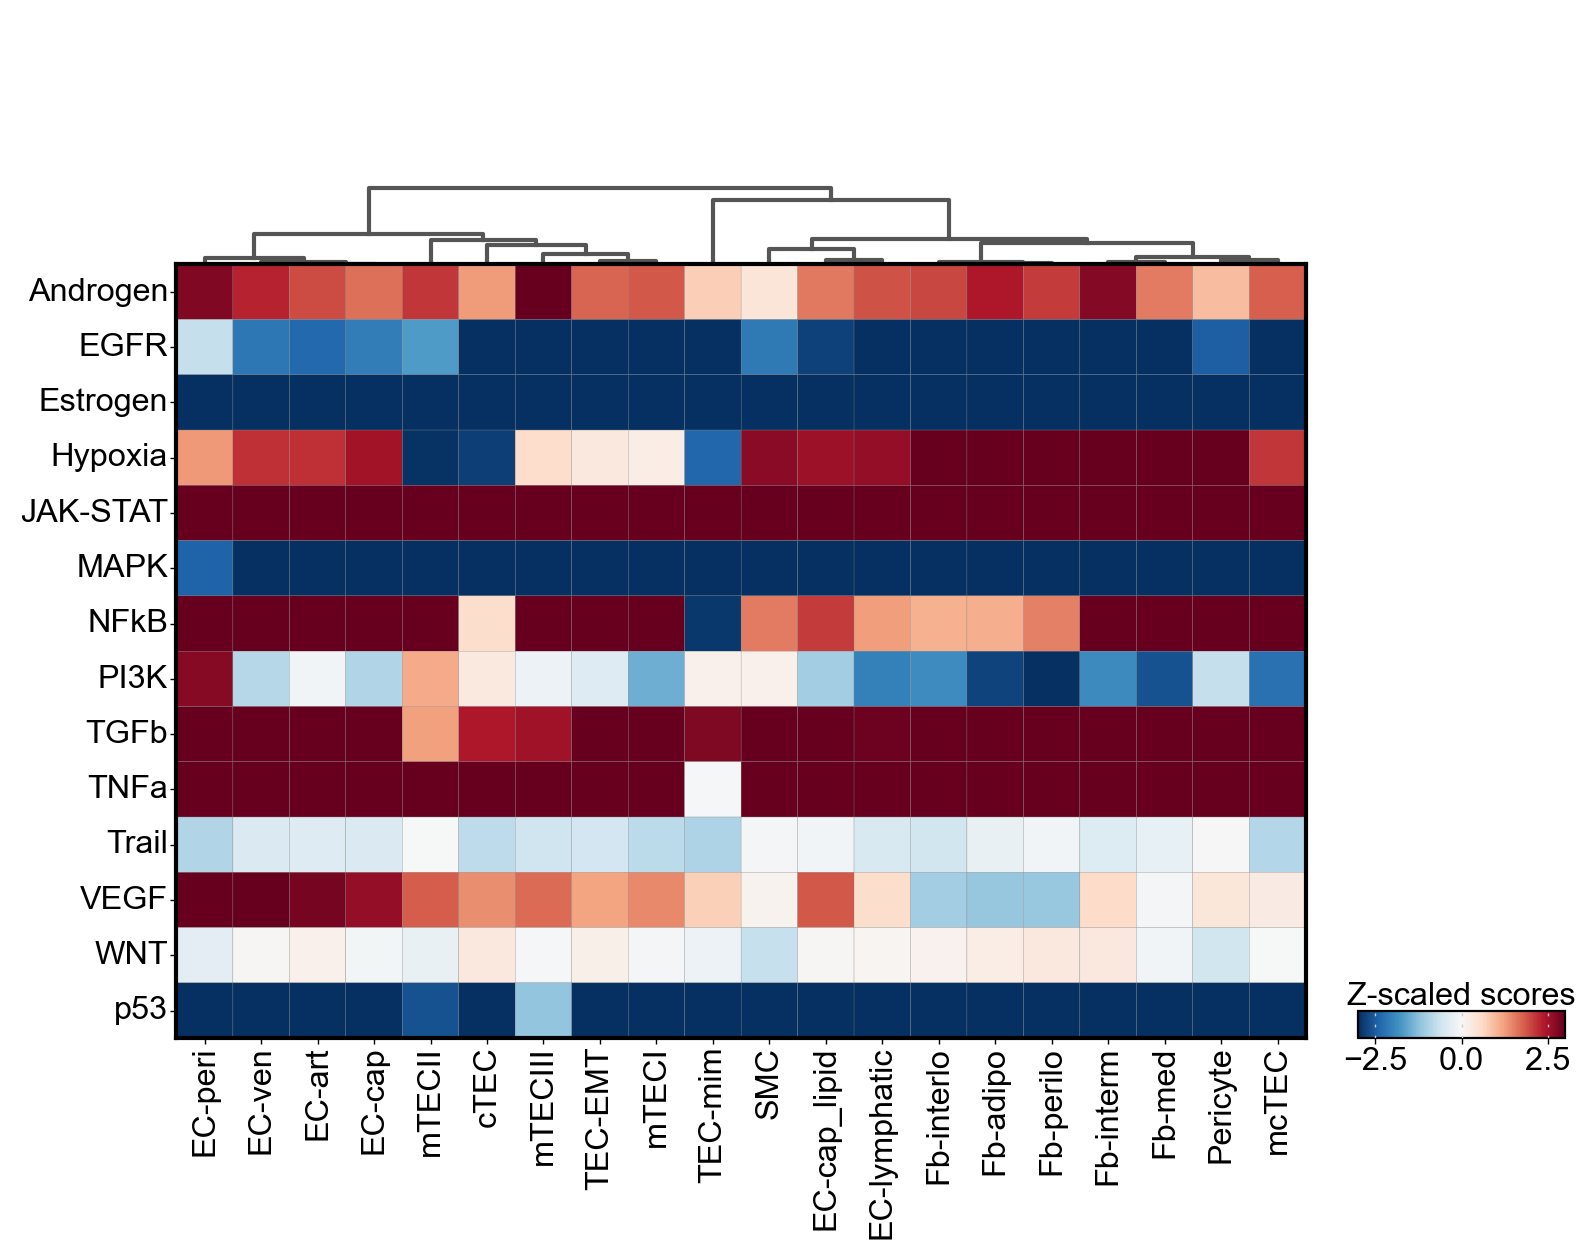

In [159]:
sc.pl.matrixplot(
    adata=score_stroma[(score_stroma.obs['age_group'] == 'infant')],
    var_names=score_stroma.var_names,
    groupby="taa_l3",
    categories_order = stroma_lev3,
    dendrogram=True,
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r", vcenter = 0, vmin = -3, vmax = 3, swap_axes = True
)

/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'sample' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'library' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'index' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'library

... storing 'qc_status' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'taa_l0' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'taa_l1' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'taa_l2' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as act

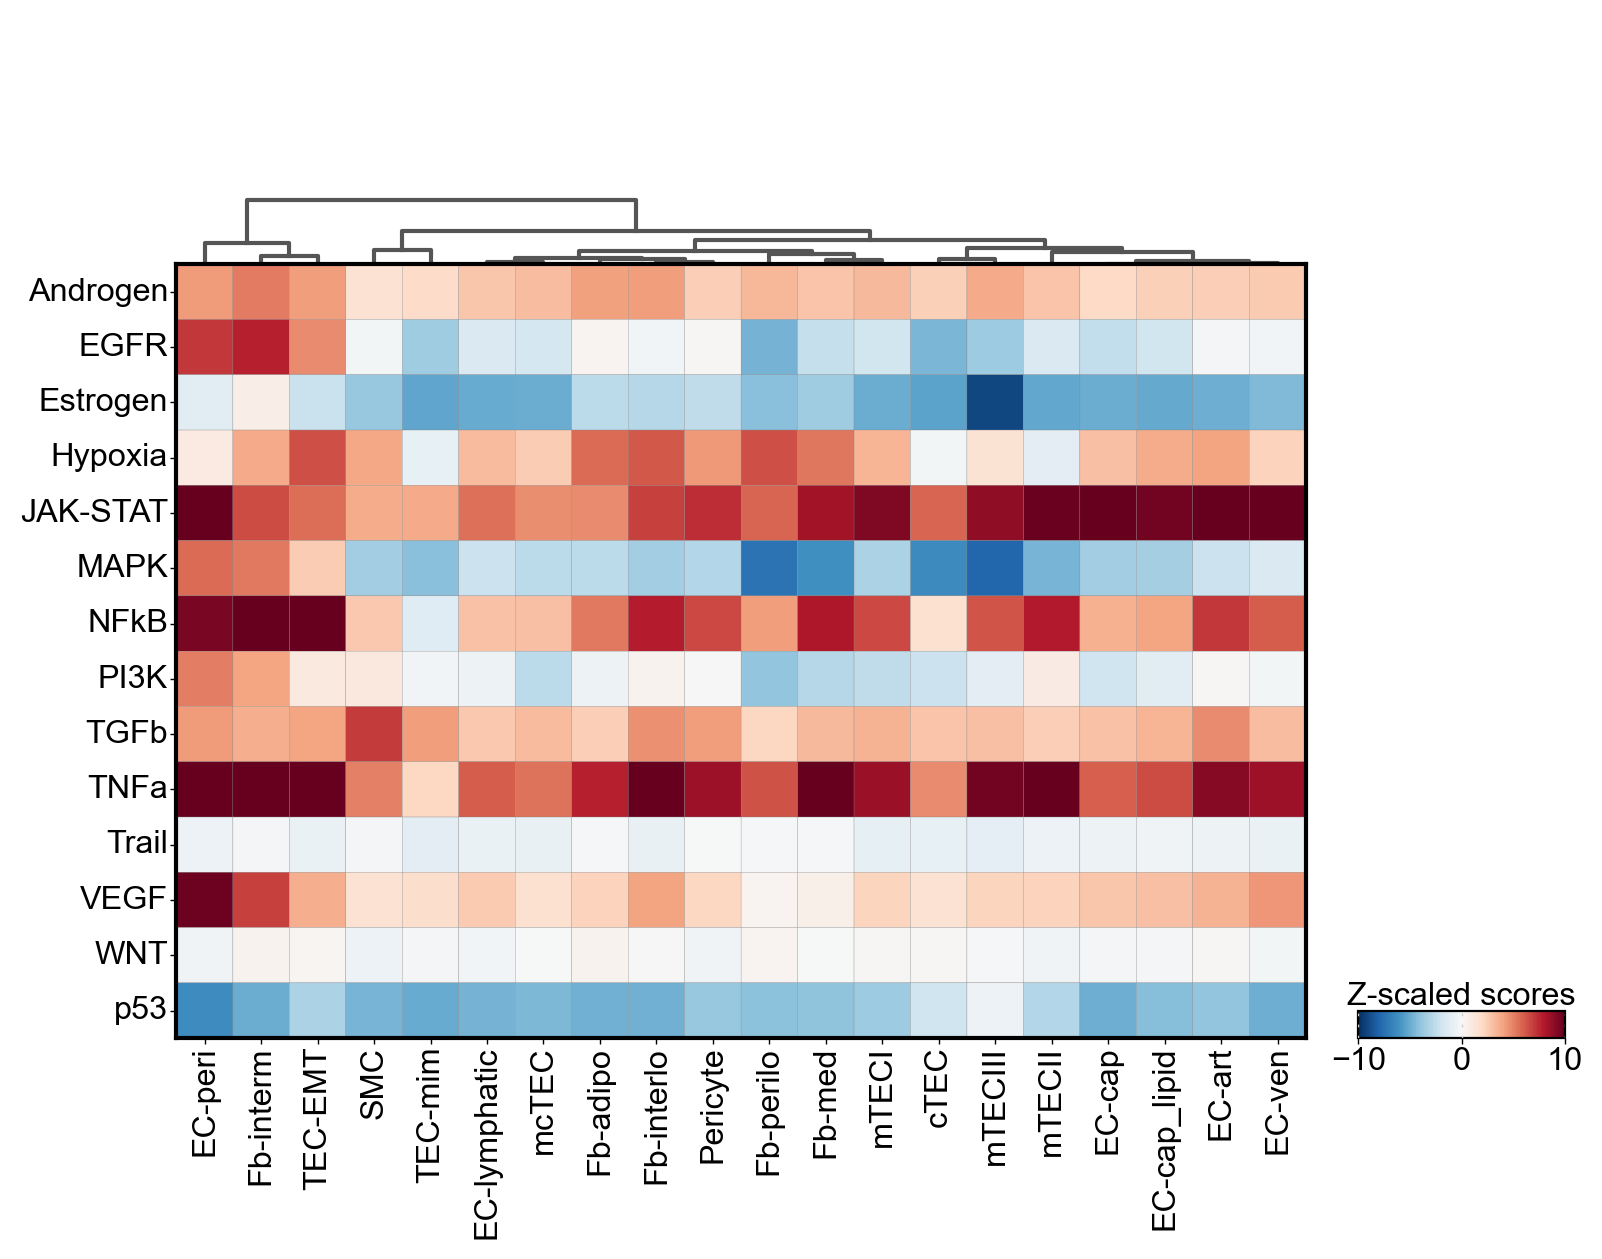

In [88]:
sc.pl.matrixplot(
    adata=score_stroma[(score_stroma.obs['age_group'] == 'adult')],
    var_names=score_stroma.var_names,
    groupby="taa_l3",
    categories_order = stroma_lev3,
    dendrogram=True,
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r", vcenter = 0, vmin = -10, vmax = 10, swap_axes = True
)

In [89]:
score_stroma.obs['age_group'].unique()

array(['adult', 'infant', 'paed', 'aged'], dtype=object)

/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'sample' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'library' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'index' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'library

... storing 'qc_status' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'taa_l0' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'taa_l1' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'taa_l2' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as act

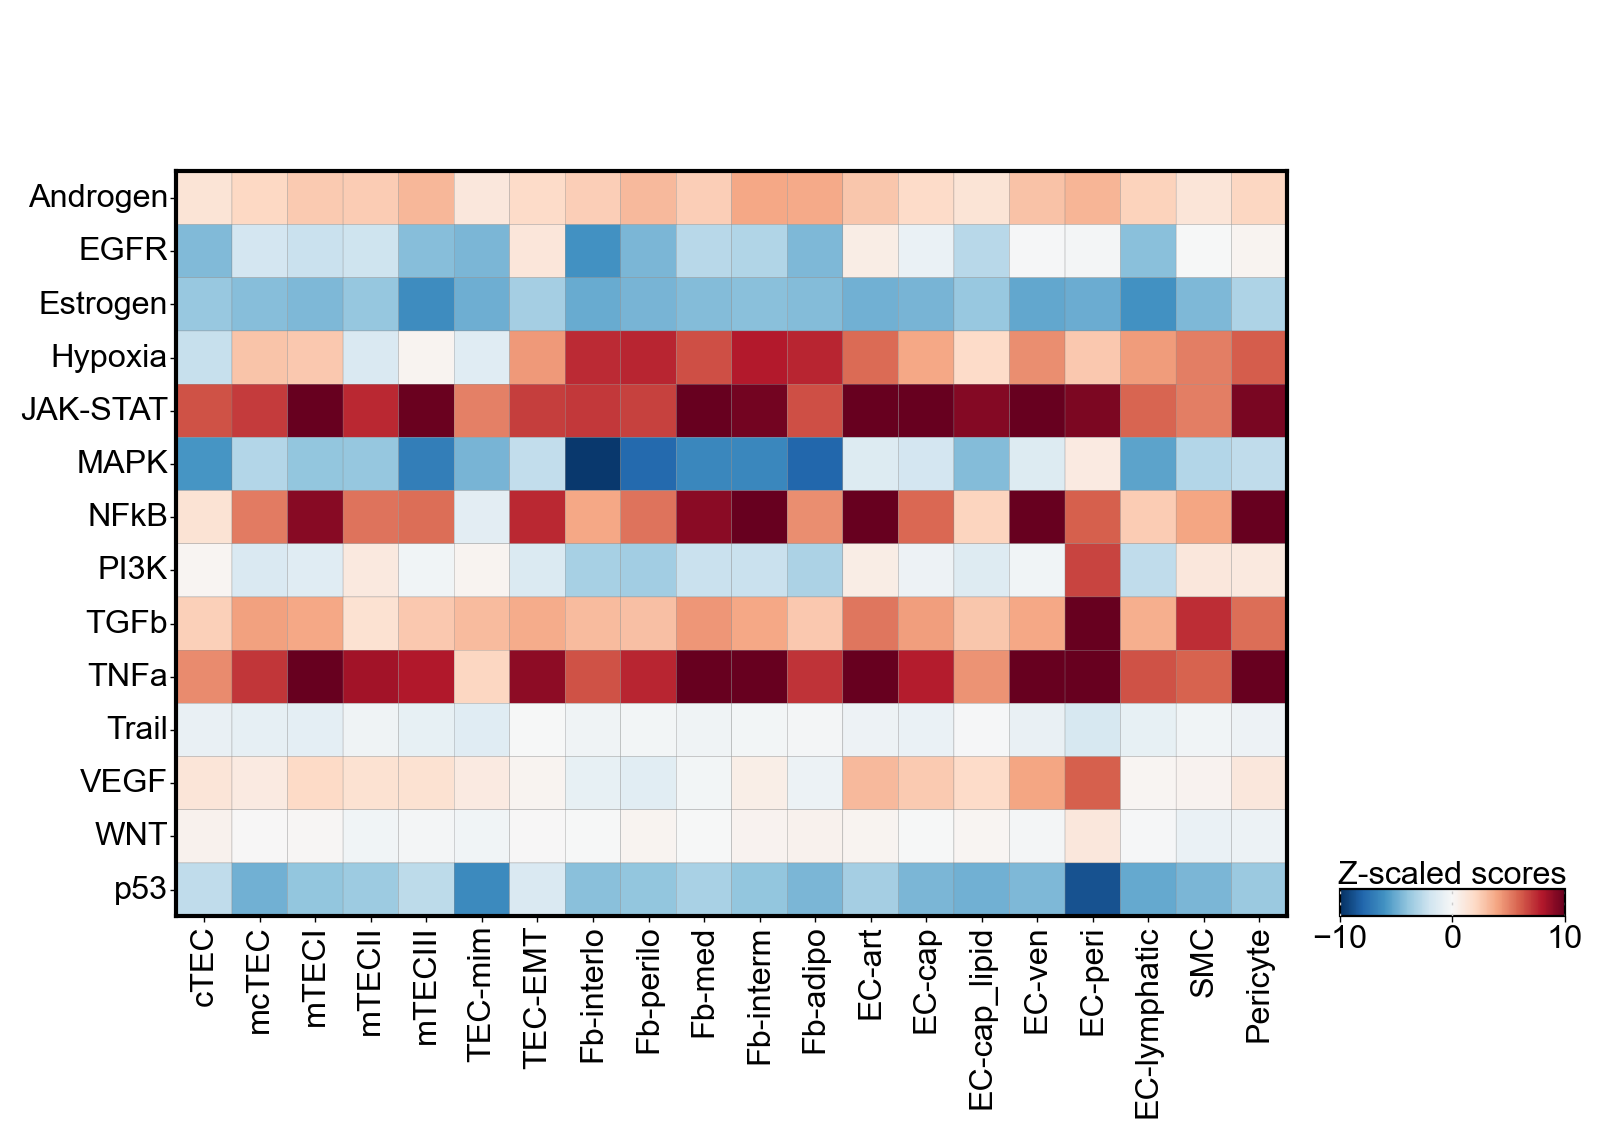

In [91]:
sc.pl.matrixplot(
    adata=score_stroma[(score_stroma.obs['age_group'] == 'paed')],
    var_names=score_stroma.var_names,
    groupby="taa_l3",
    categories_order = stroma_lev3,
    dendrogram=False,
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r", vcenter = 0, vmin = -10, vmax = 10, swap_axes = True
)

/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'sample' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'library' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'index' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'library

... storing 'qc_status' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'taa_l0' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'taa_l1' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'taa_l2' as categorical
/nfs/team205/vk8/mambaforge/envs/scvi-env3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as act

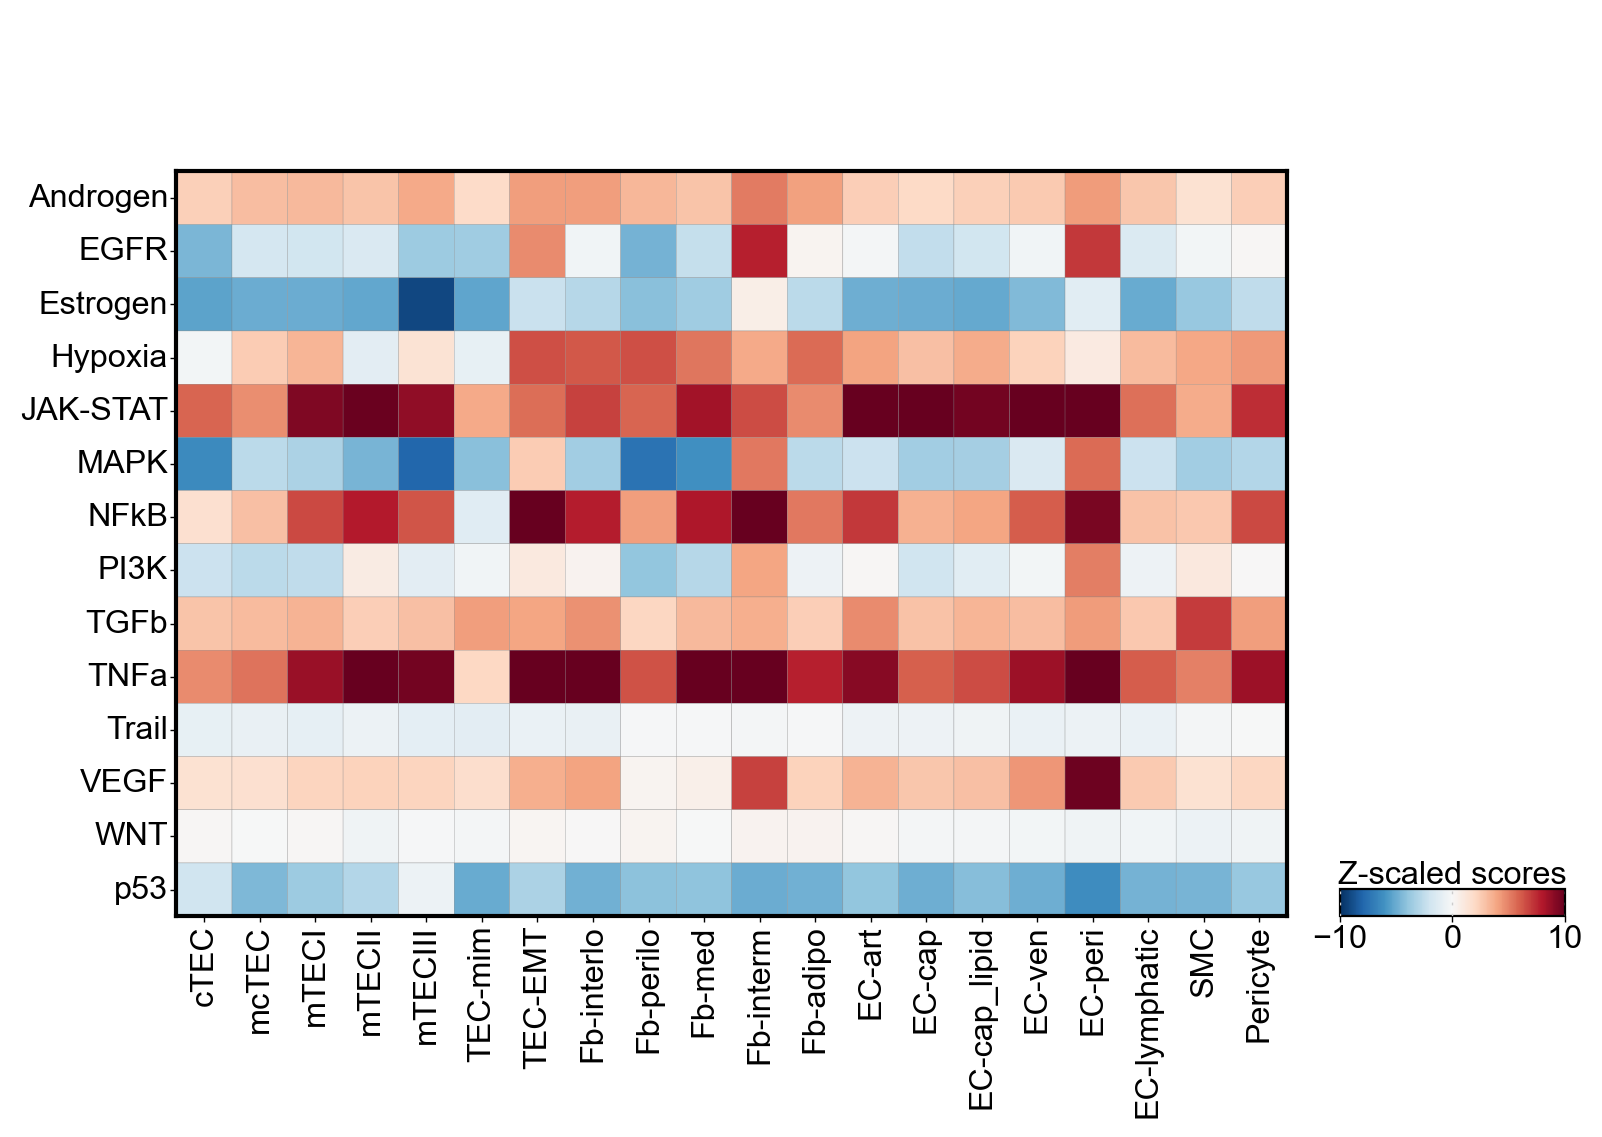

In [81]:
sc.pl.matrixplot(
    adata=score_stroma[(score_stroma.obs['age_group'] == 'adult')],
    var_names=score_stroma.var_names,
    groupby="taa_l3",
    categories_order = stroma_lev3,
    dendrogram=False,
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r", vcenter = 0, vmin = -10, vmax = 10, swap_axes = True
)

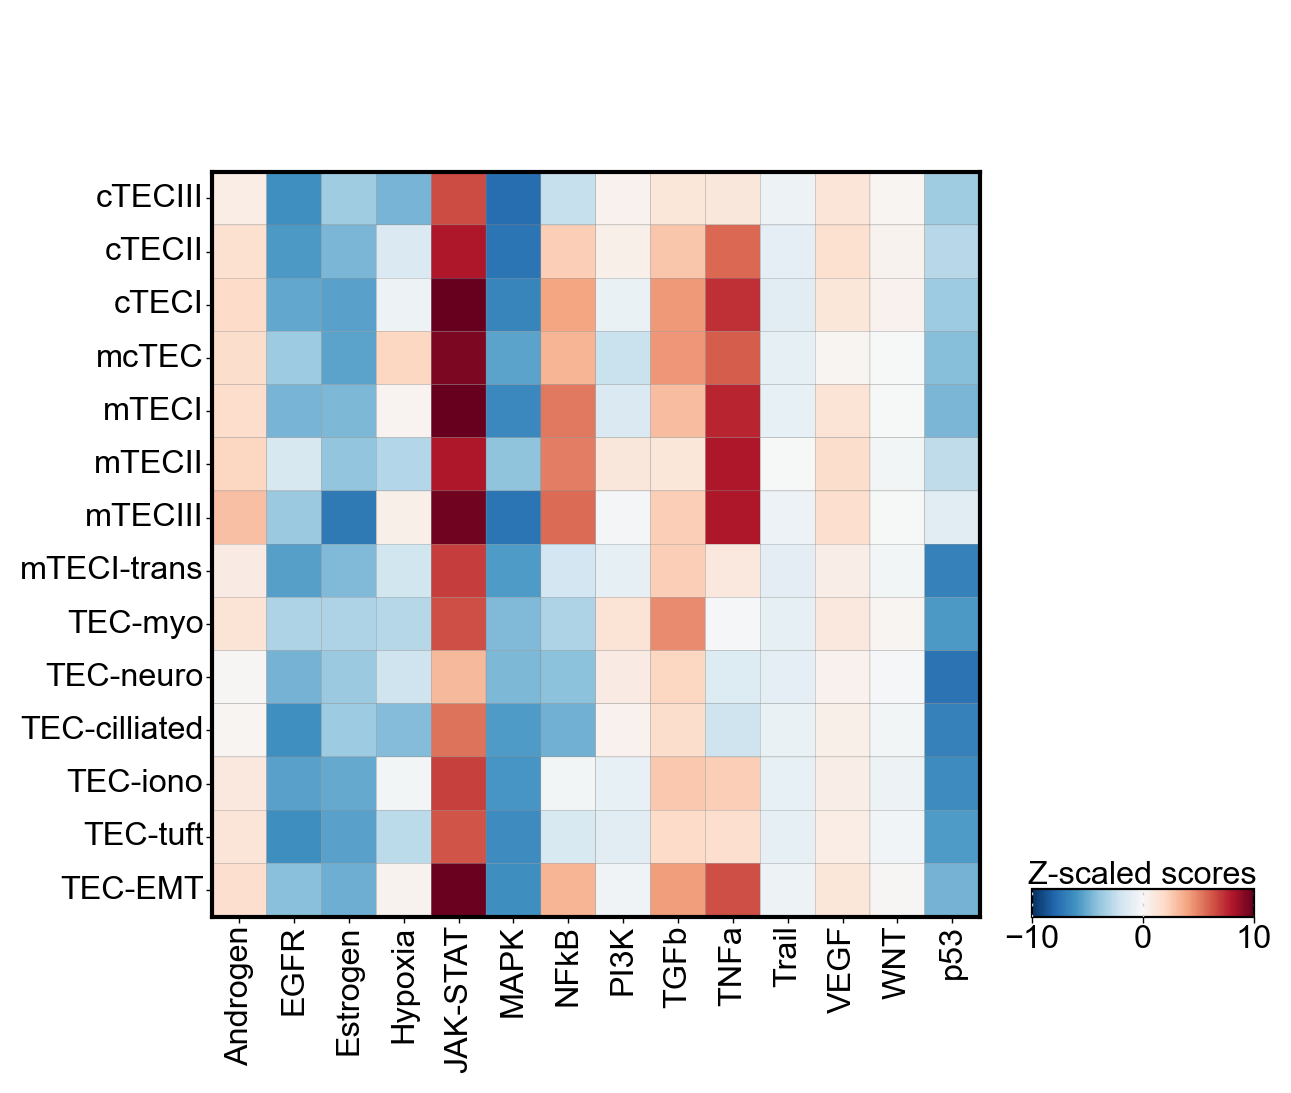

In [65]:
sc.pl.matrixplot(
    adata=score_tecs[(score_tecs.obs['age_group'] == 'infant')],
    var_names=score_tecs.var_names,
    groupby="taa_l4",
    categories_order = tecs_lev4,
    dendrogram=False,
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r", vcenter = 0, vmin = -10, vmax = 10
)

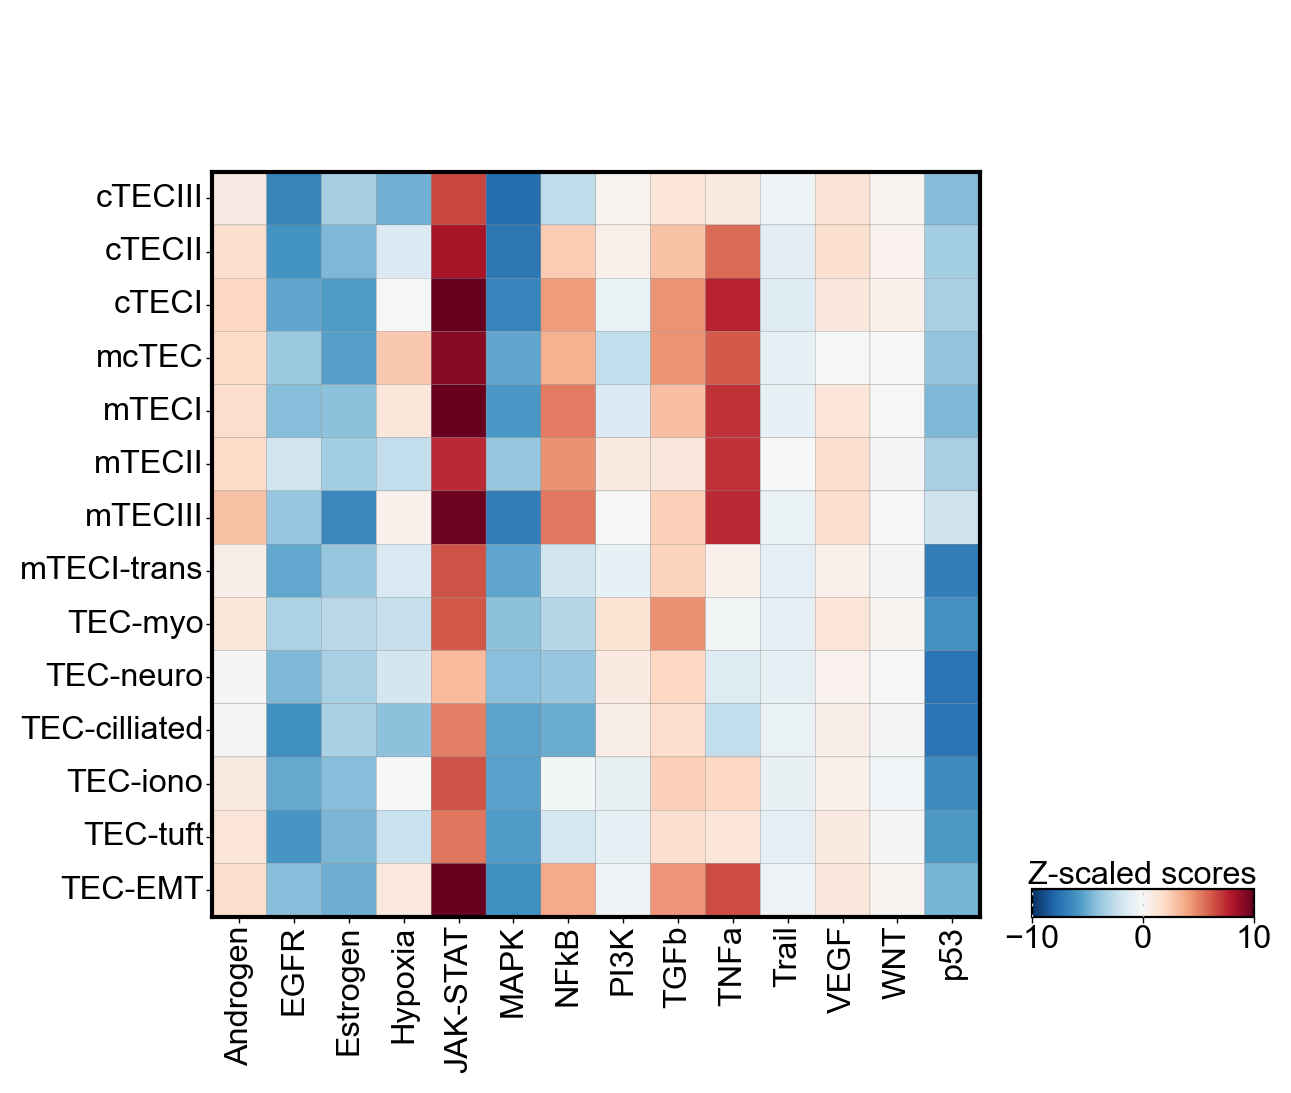

In [66]:
sc.pl.matrixplot(
    adata=score_tecs[(score_tecs.obs['age_group'] == 'infant') & (score_tecs.obs['sex'] == 'F')],
    var_names=score_tecs.var_names,
    groupby="taa_l4",
    categories_order = tecs_lev4,
    dendrogram=False,
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r", vcenter = 0, vmin = -10, vmax = 10
)

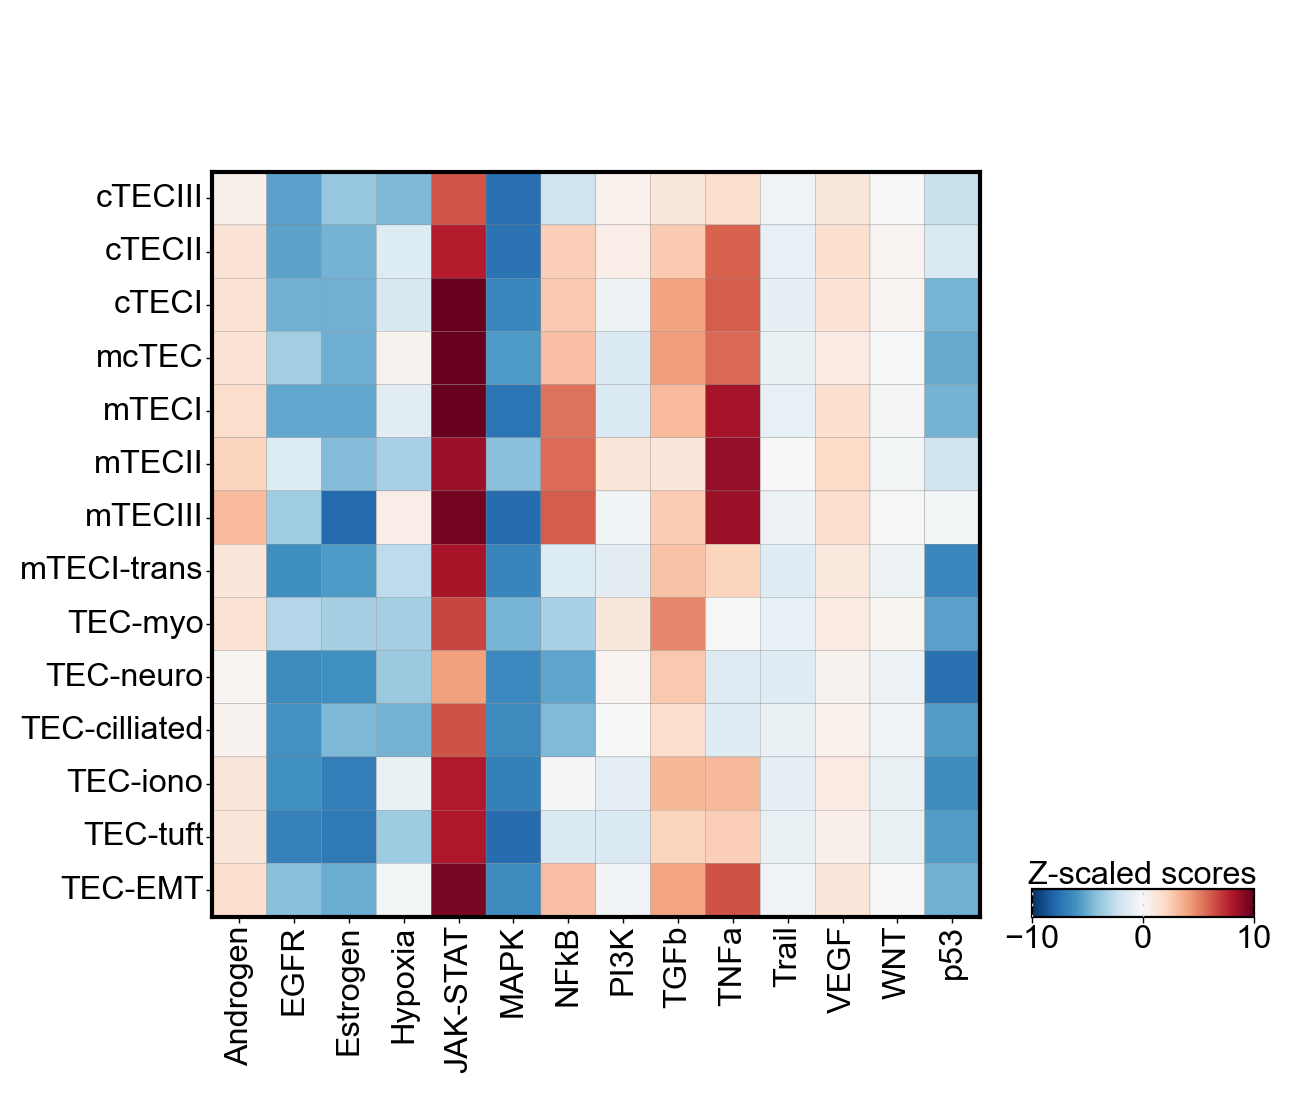

In [67]:
sc.pl.matrixplot(
    adata=score_tecs[(score_tecs.obs['age_group'] == 'infant') & (score_tecs.obs['sex'] == 'M')],
    var_names=score_tecs.var_names,
    groupby="taa_l4",
    categories_order = tecs_lev4,
    dendrogram=False,
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r", vcenter = 0, vmin = -10, vmax = 10
)

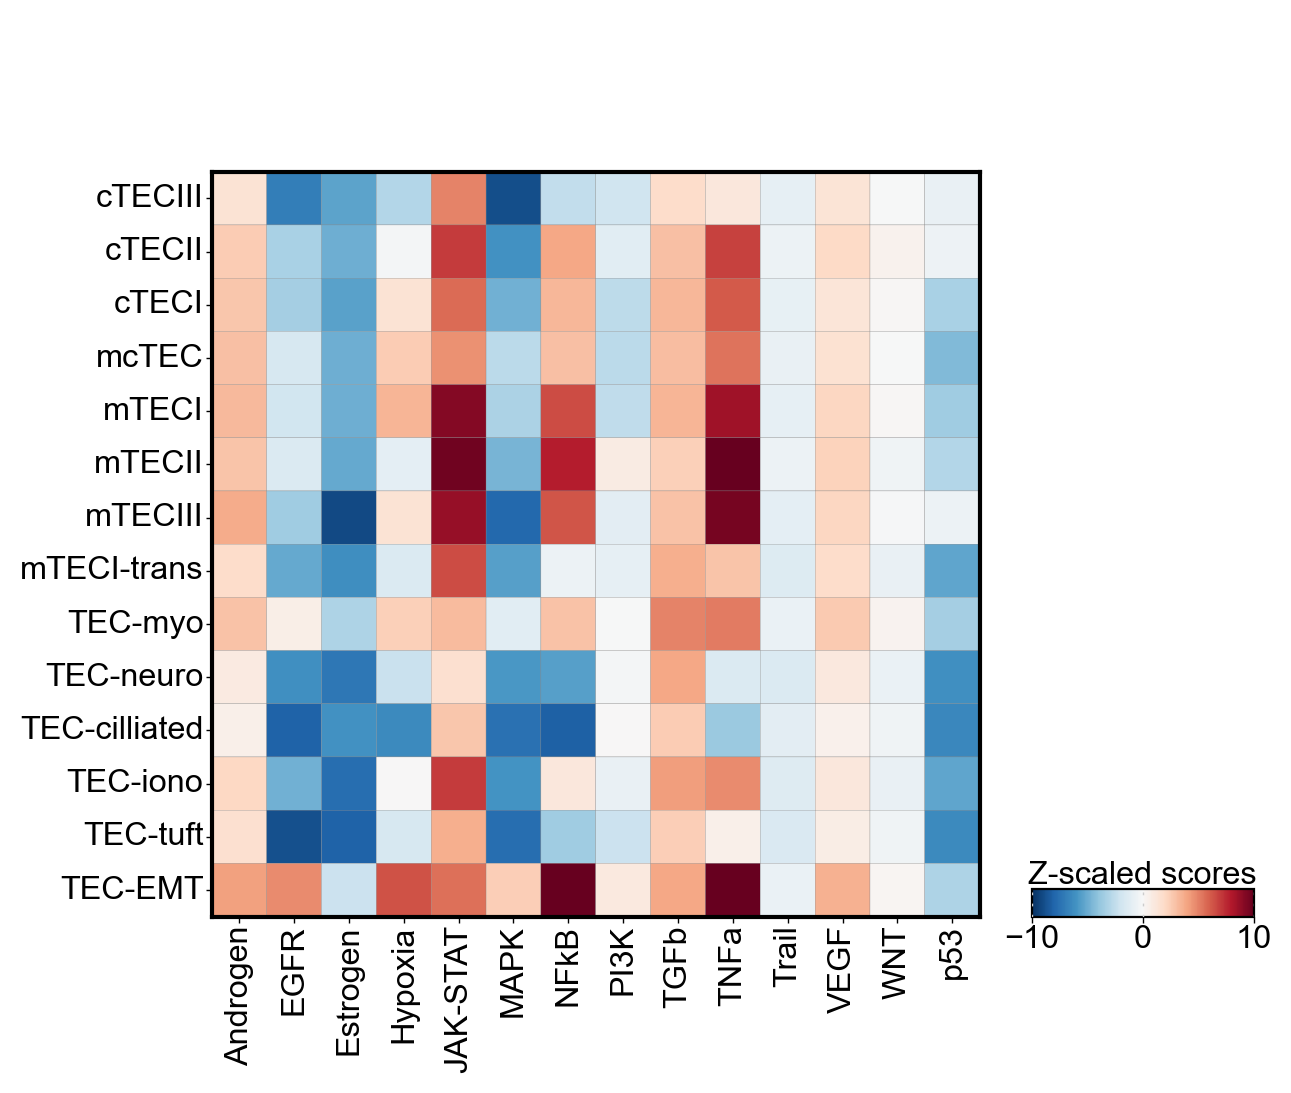

In [62]:
sc.pl.matrixplot(
    adata=score_tecs[score_tecs.obs['age_group'] == 'adult'],
    var_names=score_tecs.var_names,
    groupby="taa_l4",
    categories_order=tecs_lev4,
    dendrogram=False, vmin = -10, vcenter = 0, vmax = 10,
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r",
)

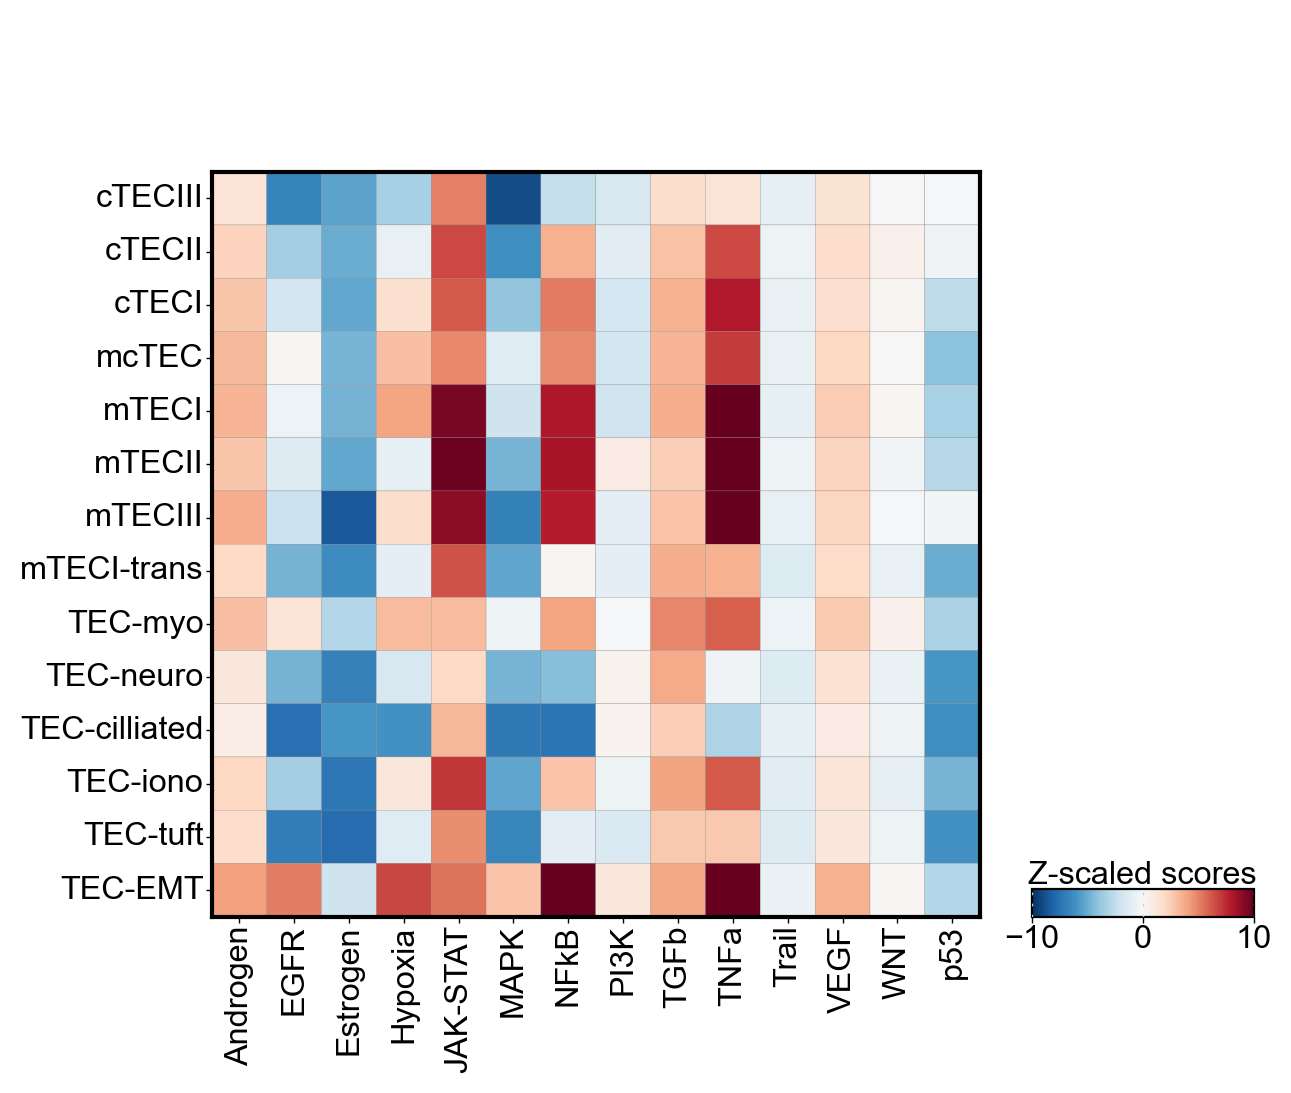

In [68]:
sc.pl.matrixplot(
    adata=score_tecs[(score_tecs.obs['age_group'] == 'adult') & (score_tecs.obs['sex'] == 'M')],
    var_names=score_tecs.var_names,
    groupby="taa_l4",
    categories_order = tecs_lev4,
    dendrogram=False,
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r", vcenter = 0, vmin = -10, vmax = 10
)

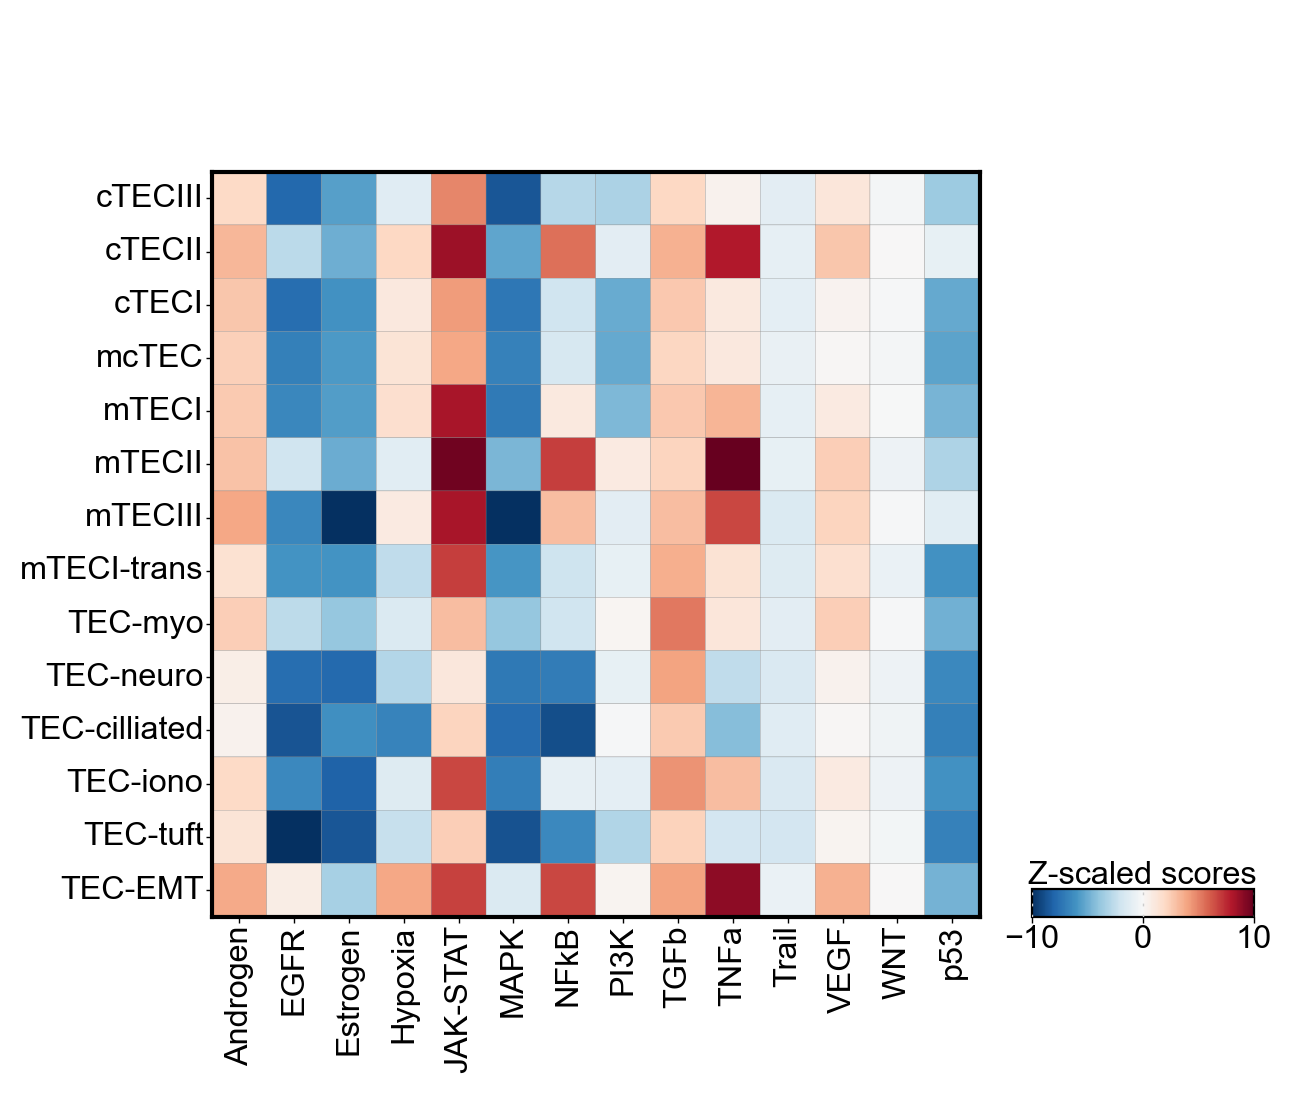

In [69]:
sc.pl.matrixplot(
    adata=score_tecs[(score_tecs.obs['age_group'] == 'adult') & (score_tecs.obs['sex'] == 'F')],
    var_names=score_tecs.var_names,
    groupby="taa_l4",
    categories_order = tecs_lev4,
    dendrogram=False,
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r", vcenter = 0, vmin = -10, vmax = 10
)

In [ ]:
%%time
dc.mt.ulm(data=adata, net=progeny, tmin = 5)

In [83]:
score_stroma

AnnData object with n_obs × n_vars = 236206 × 14
    obs: 'barcode', 'sample', 'library', 'index', 'library_tcr_ab', 'library_tcr_gd', 'library_bcr', 'path_raw_gex', 'starsolo_version', 'path_cellbender_gex', 'path_cellranger_arc', 'donor', 'chemistry_simple', 'chemistry_detail', 'chemistry_orig', 'origin_institute', 'research_no', 'study', 'sort', 'sort_type', 'in_HTSA', 'public_data', 'type', 'cite', 'health_status', 'age_group', 'age_group2', 'age', 'age_num', 'age_unit', 'age_cont', 'sex', 'age_months', 'path_tcr_ab', 'path_tcr_gd', 'path_bcr', 'comment', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'scrublet_score', 'predicted_doublet', 'anno_status', 'qc_status', 'taa_l0', 'taa_l1', 'taa_l2', 'taa_l2_v2', 'taa_l3', 'taa_l3_v2', 'taa_l4', 'taa_l5'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'chemistry_simple_colors', 'donor_colors', 'hvg', 'neighbors', 'sex_colors', 'umap', 'log1p'
    obsm: 'X_scVI', 'X_umap', 'score_ulm', 'padj_ulm'

In [20]:
sample_cnts = adata.obs['sample'].value_counts()
filtered_samples = sample_cnts[sample_cnts>100].index.tolist()
# Create anno df
anno_df = adata.obs[['sample', 'donor', 'sex', 'sort', 'study', col_age_group, 'age_months' ,col_cell_type_broad, col_cell_type_fine, 'pri_anno']].copy()
anno_df_filt = anno_df[(anno_df['sample'].isin(filtered_samples))].copy()
anno_df_filt.head()


Androgen       EGFR  Estrogen    Hypoxia  \
TA9260018-GGGATGAGTGATAAGT  -0.236416  -1.124804 -0.941138   1.598349   
TA9260018-TGCACCTGTCTCATCC   0.034251  -3.527471 -1.811813   0.922852   
TA9260110-CTCTGGTTCCGTAGTA   1.008243   8.873537  3.872877   9.805332   
TA9453198-ACACTGATCGGCATCG   3.994188   4.406847 -2.063157   6.731509   
GEX6-CACAAACGTATGAAAC       -0.263762  -0.396254 -1.724080   1.433218   
...                               ...        ...       ...        ...   
TA13072045-GGGAGATTCCGCATAA -0.266399  -1.290345 -0.829674   2.558482   
HRR1847507-TAAGCGTGTGCCTTGG -0.057690   0.155099 -2.245730  -0.983874   
TA10139060-CCTTCGACAAGCTGAG  3.070828  10.452748  1.724616  13.816322   
GEX3-TGACGGCAGAAGGTGA       -0.158264   0.001913 -0.409012   2.138973   
TA9459646-TCAGGTATCAAGATCC  -0.751638   5.130895  3.150768  -5.582250   

                             JAK-STAT      MAPK       NFkB      PI3K  \
TA9260018-GGGATGAGTGATAAGT   0.351261 -1.393188  -1.245800 -2.087548   
TA9260018-TGCACCTGTCTCATCC  -0.269565 -3.702689  -2.411884 -2.426781   
TA9260110-CTCTGGTTCCGTAGTA   0.668376  5.033420   5.651288 -0.423050   
TA9453198-ACACTGATCGGCATCG   2.057739  2.457147   6.516826 -3.695709   
GEX6-CACAAACGTATGAAAC        0.009165 -0.530032  -0.002628 -0.674614   
...                               ...       ...        ...       ...   
TA13072045-GGGAGATTCCGCATAA  0.548411 -2.522005  -1.371554 -3.538927   
HRR1847507-TAAGCGTGTGCCTTGG  1.930164 -2.274768  -0.421535 -2.462168   
TA10139060-CCTTCGACAAGCTGAG  4.777782  3.874667  20.058822 -0.107674   
GEX3-TGACGGCAGAAGGTGA       -0.216736 -0.716183  -0.170940 -0.999294   
TA9459646-TCAGGTATCAAGATCC  -0.652180  6.281335  -5.616945  2.149962   

                                 TGFb       TNFa     Trail      VEGF  \
TA9260018-GGGATGAGTGATAAGT  -0.050338   0.362001  0.804964 -0.506937   
TA9260018-TGCACCTGTCTCATCC  -0.228851  -0.752567  1.451299  0.412261   
TA9260110-CTCTGGTTCCGTAGTA   1.008523   5.299259  0.036429 -6.519723   
TA9453198-ACACTGATCGGCATCG   0.559783   6.842064  0.320979  5.306400   
GEX6-CACAAACGTATGAAAC        0.156981   0.692505  0.477576 -0.987447   
...                               ...        ...       ...       ...   
TA13072045-GGGAGATTCCGCATAA -0.313103  -0.205597  0.935848 -0.891675   
HRR1847507-TAAGCGTGTGCCTTGG  0.074290   1.416714  2.057336  0.090757   
TA10139060-CCTTCGACAAGCTGAG  4.662261  19.609042 -0.218339 -2.024768   
GEX3-TGACGGCAGAAGGTGA        0.488963   0.365758  0.670790 -2.585342   
TA9459646-TCAGGTATCAAGATCC  -1.060313  -2.315217  0.186617 -0.000262   

                                  WNT        p53  
TA9260018-GGGATGAGTGATAAGT   0.188391  -2.785628  
TA9260018-TGCACCTGTCTCATCC   0.606194  -1.450954  
TA9260110-CTCTGGTTCCGTAGTA  -0.041459  -0.150831  
TA9453198-ACACTGATCGGCATCG   0.472414  -0.353859  
GEX6-CACAAACGTATGAAAC       -0.200848  -0.938629  
...                               ...        ...  
TA13072045-GGGAGATTCCGCATAA  0.193842  -0.818637  
HRR1847507-TAAGCGTGTGCCTTGG  0.160132  -2.232259  
TA10139060-CCTTCGACAAGCTGAG -0.189574  -1.375272  
GEX3-TGACGGCAGAAGGTGA        0.146542  -0.672059  
TA9459646-TCAGGTATCAAGATCC  -0.040672 -10.730744  

[102529 rows x 14 columns]

In [15]:
adata_stroma.shape

(236206, 35530)

## Load DE results

In [8]:
## Load all DE results level 4 (adult vs infant)
import pickle as pkl
with open(f'{general_data_path}/analyses/dea/thyAgeing_dea_taa_l4_adult_vs_infant_ageEffect.pkl', 'rb') as f:
    de_ad2inf_lev4_dict = pkl.load(f)

de_ad2inf_lev4 = pd.concat([v for k,v in de_ad2inf_lev4_dict.items()], keys = de_ad2inf_lev4_dict.keys(), names = ['cell_type']).reset_index().rename(columns = {'level_1':'gene_name'})
## Load DE results for priming (adult vs infant)
with open(f'{results_path}/thyAgeing_TEC_dea_4cnts_TECpri_annos.pkl', 'rb') as de_pri:
    de_res_dict_pri = pkl.load(de_pri)
    
de_df_pri = pd.concat([v for k,v in de_res_dict_pri['de_df'].items() if k in ['cTEC-pri:adult-vs-infant', 'unpri:adult-vs-infant',
                                                    'mTEC-pri:adult-vs-infant']], 
           keys = ['cTEC-pri:adult-vs-infant', 'unpri:adult-vs-infant','mTEC-pri:adult-vs-infant'], 
           names = ['cell_type:cont']).reset_index().rename(columns = {'level_1':'gene_name'})
de_df_pri[['cell_type', 'cont']] = de_df_pri['cell_type:cont'].str.split(':', expand = True)
de_ad2inf_lev4_pri = pd.concat([de_ad2inf_lev4, de_df_pri])

de_ad2inf_lev4_pri['contrast'] = 'adult-vs-infant'
de_ad2inf_lev4_pri['change'] = de_ad2inf_lev4_pri.apply(lambda x: 'sign_up' if (x['padj'] <0.05) & (x['log2FoldChange'] >0) else
                               'sign_dw' if (x['padj'] <0.05) & (x['log2FoldChange'] < 0) else
                                'non_sign', axis = 1)

In [9]:
## Load all DE results level 3 (adult vs infant)
with open(f'{general_data_path}/analyses/dea/thyAgeing_dea_taa_l3_adult_vs_infant_ageEffect.pkl', 'rb') as f:
    de_ad2inf_lev3_dict = pkl.load(f)

de_ad2inf_lev3 = pd.concat([v for k,v in de_ad2inf_lev3_dict.items()], keys = de_ad2inf_lev3_dict.keys(), names = ['cell_type']).reset_index().rename(columns = {'level_1':'gene_name'})


with open(f'{general_data_path}/analyses/dea/thyAgeing_dea_taa_l3_paed_vs_infant_ageEffect.pkl', 'rb') as f:
    de_paed2inf_lev3_dict = pkl.load(f)

de_paed2inf_lev3 = pd.concat([v for k,v in de_paed2inf_lev3_dict.items()], keys = de_paed2inf_lev3_dict.keys(), names = ['cell_type']).reset_index().rename(columns = {'level_1':'gene_name'})


In [10]:
for df in [de_ad2inf_lev4, de_ad2inf_lev3, de_paed2inf_lev3, de_df_pri]:
    df['change'] = df.apply(lambda x: 'sign_up' if (x['padj'] <0.05) & (x['log2FoldChange'] >0) else
                               'sign_dw' if (x['padj'] <0.05) & (x['log2FoldChange'] < 0) else
                                'non_sign', axis = 1)